name: Razan Maree, ID: 314893520

name: Abed Alftah Abed Alftah, ID: 206529836

# Deep Q-Network for Atari Breakout.

In this assignment you are required to implement a Deep Q-Network agent, for the Atari game Breakout.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install stable-baselines3[extra] ale-py==0.7.4 gym==0.21.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

  Using cached stable_baselines3-2.2.1-py3-none-any.whl (181 kB)
  Using cached ale_py-0.7.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Using cached Shimmy-1.3.0-py3-none-any.whl (37 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 24.0 MB/s eta 0:00:00
     ━━━

In [ ]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

## Breakout

This is an environment emulating the Atari game *Breakout*. The goal is to break all the bricks in the wall without letting the ball touch the floor. You have 5 lives and get points more points for higher brick than for the lower ones.

The observation is an image with dimensions (210, 160, 3).

There are 4 actions defined as NOOP, FIRE, LEFT and RIGHT.

See full description [here](https://www.gymlibrary.dev/environments/atari/breakout/).




observation dim (210, 160, 3) number of actions 4


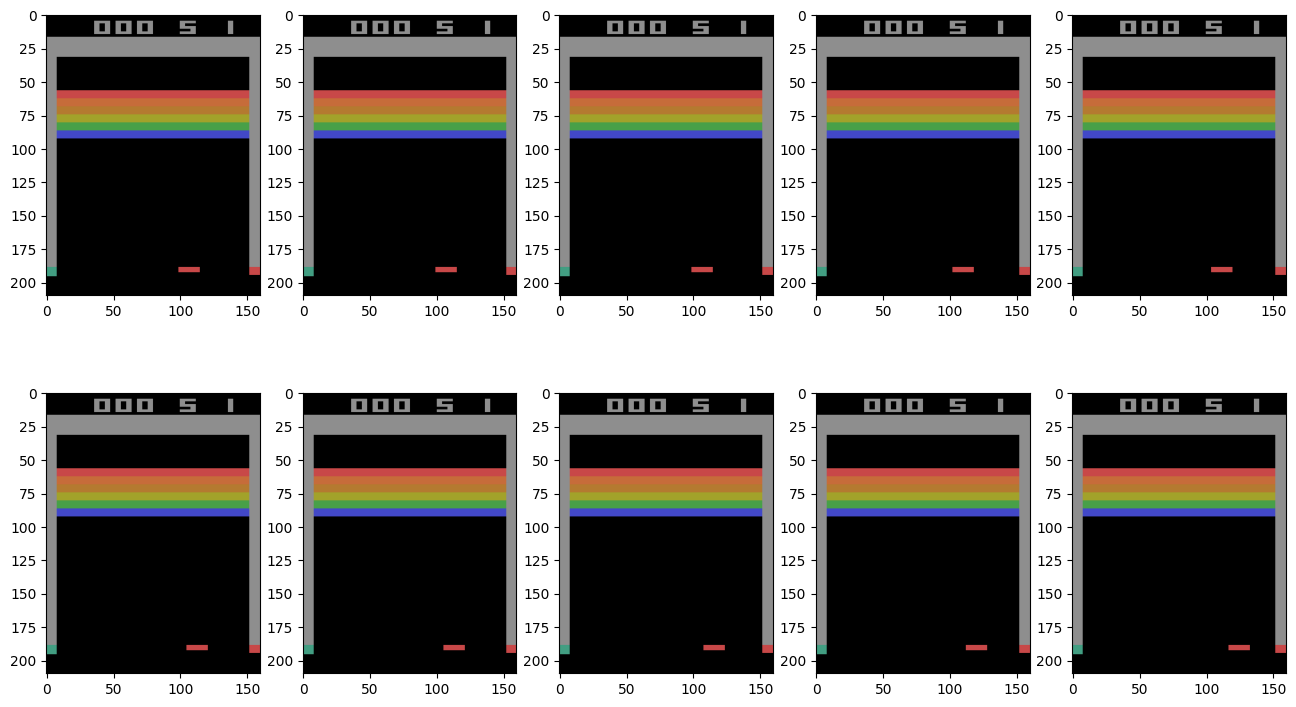

In [ ]:
ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Wrappers

In order to make the environment more suitable for RL training, we make the following updates to the environment, using environment wrappers:
1. Preprocess the images to contain only the relevant part of the image, converted to grayscale. The raw images are large and we can do with 64x64 images.
2. Concatenate the 4 previous images (in order to capture dynamics)
3. Start the fire action automatically when starting the episode
4. Repeat the same action for 4 time steps
5. Output the maximum values of the last 2 frames per pixel (in order to prevent blinking)
6. Ouput a "done" signal every time a life is reduced but only reset the environment when all lives are gone
7. Bin the rewards to the values {-1, 0, 1}




In [ ]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 84, 84)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

## Check observations under wrappers

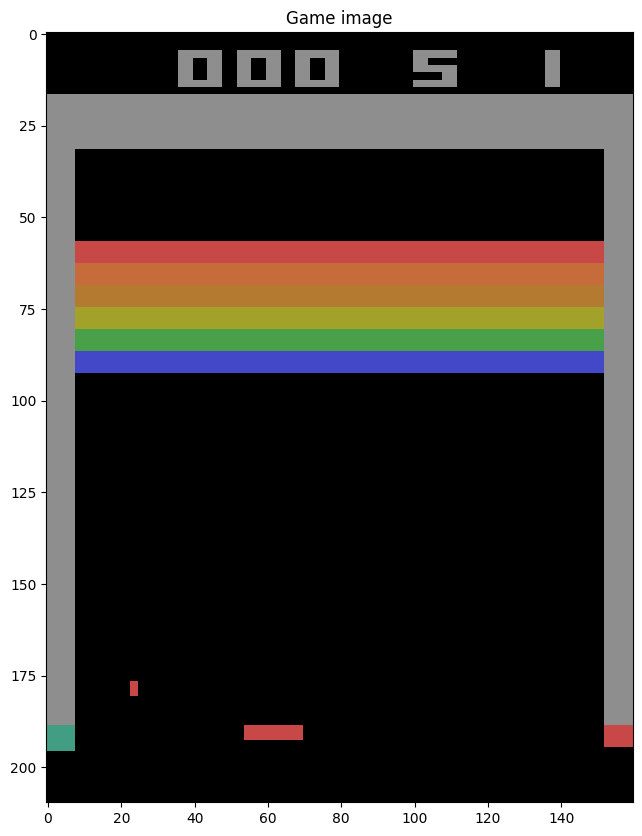

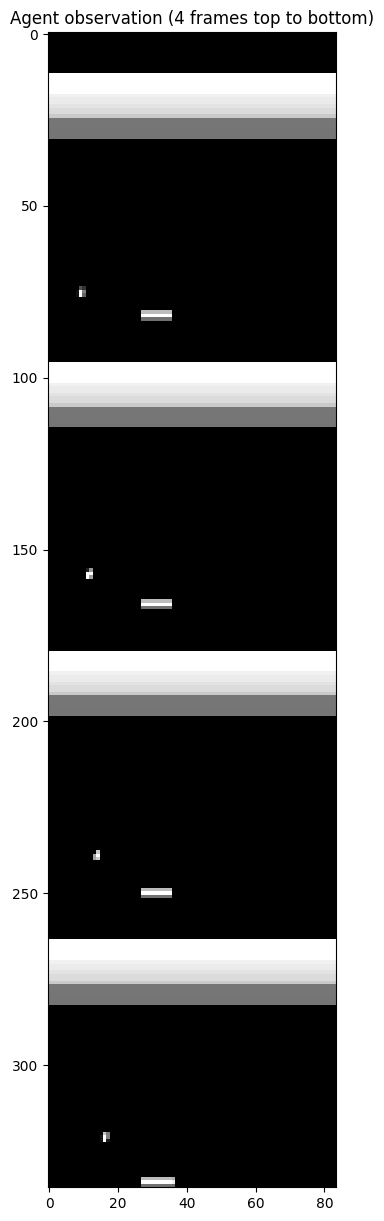

In [ ]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [ ]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=3, greedy=False) for _ in range(10)]


In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class DQN(nn.Module):
    def __init__(self, action_space):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, action_space)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class DQNAgent:
    def __init__(self, input_size, lr=0.00025, gamma=0.99, epsilon=1.0, epsilon_min=0.1,
                 epsilon_random_frames=50000, epsilon_greedy_frames=1000000.0, target_update=10000, batch_size=32,
                 capacity=10000):
        self.input_size = input_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_random_frames = epsilon_random_frames
        self.epsilon_greedy_frames = epsilon_greedy_frames
        self.target_update = target_update
        self.batch_size = batch_size
        self.memory = []
        self.capacity = capacity
        self.steps = -1

        # Initialize main and target networks
        self.q_network = DQN(input_size)
        self.target_network = DQN(input_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.q_network.to(device)
        self.target_network.to(device)

        # Define optimizer and loss function
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.HuberLoss()

    def select_action(self, selected_state):
        self.steps += 1
        if torch.rand(1) < self.epsilon or self.steps < self.epsilon_random_frames:
            return torch.randint(self.input_size, (1, 1))
        else:
            with torch.no_grad():
                q_values = self.q_network(selected_state).detach()
                return torch.argmax(q_values, dim=-1, keepdim=True)

    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory.pop(0)
            self.memory.append(experience)

    def sample(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.tensor(states).to(device)
        actions = torch.tensor(actions).unsqueeze(1).to(device)
        next_states = torch.tensor(next_states).to(device)
        rewards = torch.tensor(rewards).to(device)
        dones = torch.tensor(dones).to(device)

        return states.squeeze(), actions, next_states.squeeze(), rewards, dones

    def replay(self):
        self.epsilon = max(self.epsilon_min, self.epsilon - (0.9 / self.epsilon_greedy_frames))
        if len(self.memory) < self.batch_size or self.steps % 4 != 0:
            return

        states, actions, next_states, rewards, dones = self.sample()
        q_values = self.q_network(states).gather(1, actions)

        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards.unsqueeze(1).float() + (
                1 - dones.unsqueeze(1).float()) * self.gamma * next_q_values.unsqueeze(1).float()

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        if self.steps % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
            torch.save(self.q_network.state_dict(), f'{self.steps}_model.pth')
            plt.plot(episode_rewards)
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.title("Reward per Episode")
            plt.show()

agent = DQNAgent(n_actions)

Episode 0, Reward: 0.0
Episode 10, Reward: 0.0
Episode 20, Reward: 0.0
Episode 30, Reward: 0.0
Episode 40, Reward: 0.0
Episode 50, Reward: 0.0
Episode 60, Reward: 0.0
Episode 70, Reward: 0.0
Episode 80, Reward: 0.0
Episode 90, Reward: 0.0
Episode 100, Reward: 0.0
Episode 110, Reward: 0.0
Episode 120, Reward: 0.0
Episode 130, Reward: 0.0
Episode 140, Reward: 0.0
Episode 150, Reward: 1.0
Episode 160, Reward: 0.0
Episode 170, Reward: 0.0
Episode 180, Reward: 0.0
Episode 190, Reward: 0.0
Episode 200, Reward: 0.0
Episode 210, Reward: 0.0
Episode 220, Reward: 0.0
Episode 230, Reward: 0.0
Episode 240, Reward: 0.0
Episode 250, Reward: 3.0
Episode 260, Reward: 0.0
Episode 270, Reward: 0.0
Episode 280, Reward: 0.0
Episode 290, Reward: 0.0
Episode 300, Reward: 0.0
Episode 310, Reward: 0.0
Episode 320, Reward: 0.0


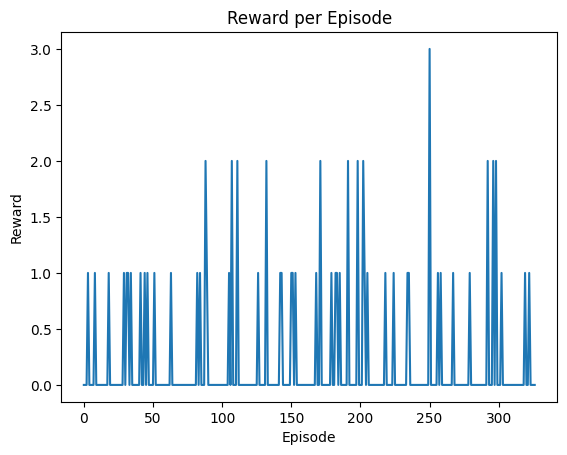

Episode 330, Reward: 0.0
Episode 340, Reward: 0.0
Episode 350, Reward: 1.0
Episode 360, Reward: 0.0
Episode 370, Reward: 0.0
Episode 380, Reward: 0.0
Episode 390, Reward: 0.0
Episode 400, Reward: 0.0
Episode 410, Reward: 0.0
Episode 420, Reward: 0.0
Episode 430, Reward: 0.0
Episode 440, Reward: 0.0
Episode 450, Reward: 0.0
Episode 460, Reward: 0.0
Episode 470, Reward: 0.0
Episode 480, Reward: 0.0
Episode 490, Reward: 0.0
Episode 500, Reward: 0.0
Episode 510, Reward: 0.0
Episode 520, Reward: 0.0
Episode 530, Reward: 0.0
Episode 540, Reward: 0.0
Episode 550, Reward: 0.0
Episode 560, Reward: 0.0
Episode 570, Reward: 0.0
Episode 580, Reward: 0.0
Episode 590, Reward: 0.0
Episode 600, Reward: 0.0
Episode 610, Reward: 0.0
Episode 620, Reward: 0.0
Episode 630, Reward: 0.0
Episode 640, Reward: 0.0
Episode 650, Reward: 0.0


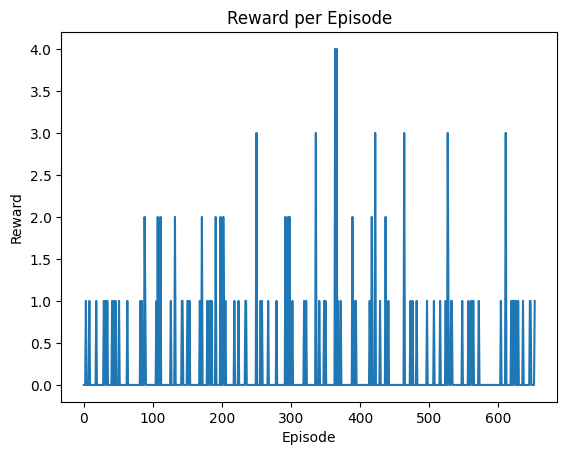

Episode 660, Reward: 0.0
Episode 670, Reward: 0.0
Episode 680, Reward: 0.0
Episode 690, Reward: 0.0
Episode 700, Reward: 0.0
Episode 710, Reward: 0.0
Episode 720, Reward: 0.0
Episode 730, Reward: 0.0
Episode 740, Reward: 0.0
Episode 750, Reward: 0.0
Episode 760, Reward: 0.0
Episode 770, Reward: 0.0
Episode 780, Reward: 0.0
Episode 790, Reward: 0.0
Episode 800, Reward: 0.0
Episode 810, Reward: 0.0
Episode 820, Reward: 0.0
Episode 830, Reward: 0.0
Episode 840, Reward: 0.0
Episode 850, Reward: 0.0
Episode 860, Reward: 0.0
Episode 870, Reward: 0.0
Episode 880, Reward: 0.0
Episode 890, Reward: 0.0
Episode 900, Reward: 0.0
Episode 910, Reward: 0.0
Episode 920, Reward: 0.0
Episode 930, Reward: 0.0
Episode 940, Reward: 0.0
Episode 950, Reward: 0.0
Episode 960, Reward: 0.0
Episode 970, Reward: 0.0
Episode 980, Reward: 0.0


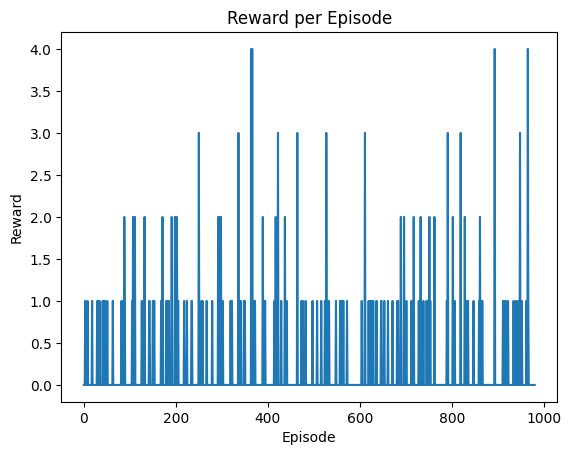

Episode 990, Reward: 0.0
Episode 1000, Reward: 0.0
Episode 1010, Reward: 0.0
Episode 1020, Reward: 0.0
Episode 1030, Reward: 0.0
Episode 1040, Reward: 0.0
Episode 1050, Reward: 0.0
Episode 1060, Reward: 0.0
Episode 1070, Reward: 0.0
Episode 1080, Reward: 0.0
Episode 1090, Reward: 0.0
Episode 1100, Reward: 0.0
Episode 1110, Reward: 0.0
Episode 1120, Reward: 0.0
Episode 1130, Reward: 0.0
Episode 1140, Reward: 0.0
Episode 1150, Reward: 0.0
Episode 1160, Reward: 0.0
Episode 1170, Reward: 0.0
Episode 1180, Reward: 0.0
Episode 1190, Reward: 0.0
Episode 1200, Reward: 0.0
Episode 1210, Reward: 0.0
Episode 1220, Reward: 0.0
Episode 1230, Reward: 0.0
Episode 1240, Reward: 0.0
Episode 1250, Reward: 0.0
Episode 1260, Reward: 0.0
Episode 1270, Reward: 0.0
Episode 1280, Reward: 0.0
Episode 1290, Reward: 0.0
Episode 1300, Reward: 0.0


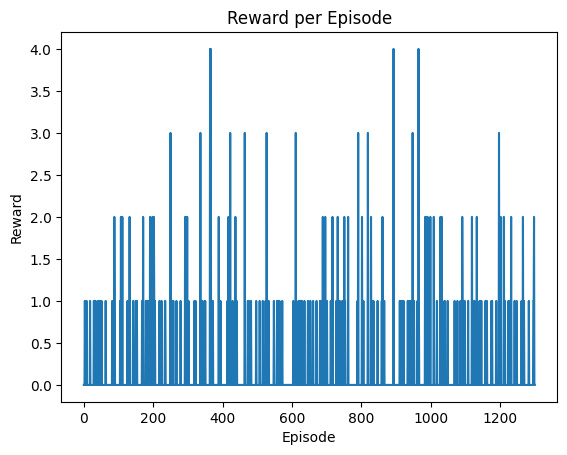

Episode 1310, Reward: 0.0
Episode 1320, Reward: 0.0
Episode 1330, Reward: 0.0
Episode 1340, Reward: 0.0
Episode 1350, Reward: 0.0
Episode 1360, Reward: 0.0
Episode 1370, Reward: 0.0
Episode 1380, Reward: 0.0
Episode 1390, Reward: 0.0
Episode 1400, Reward: 0.0
Episode 1410, Reward: 0.0
Episode 1420, Reward: 1.0
Episode 1430, Reward: 0.0
Episode 1440, Reward: 0.0
Episode 1450, Reward: 0.0
Episode 1460, Reward: 0.0
Episode 1470, Reward: 0.0
Episode 1480, Reward: 0.0
Episode 1490, Reward: 0.0
Episode 1500, Reward: 0.0
Episode 1510, Reward: 0.0
Episode 1520, Reward: 0.0
Episode 1530, Reward: 0.0
Episode 1540, Reward: 0.0
Episode 1550, Reward: 0.0
Episode 1560, Reward: 0.0
Episode 1570, Reward: 0.0
Episode 1580, Reward: 0.0
Episode 1590, Reward: 1.0
Episode 1600, Reward: 0.0
Episode 1610, Reward: 0.0
Episode 1620, Reward: 0.0
Episode 1630, Reward: 0.0


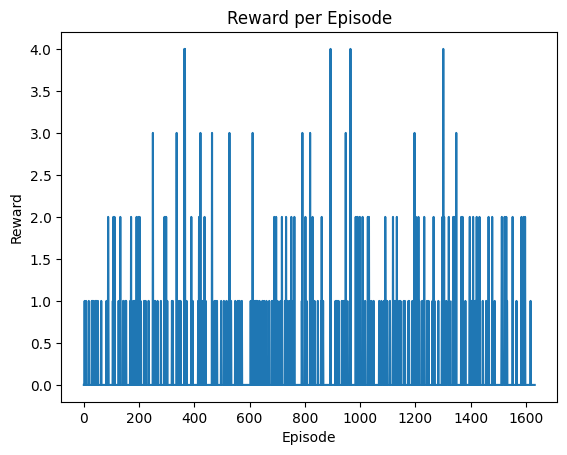

Episode 1640, Reward: 0.0
Episode 1650, Reward: 0.0
Episode 1660, Reward: 0.0
Episode 1670, Reward: 0.0
Episode 1680, Reward: 0.0
Episode 1690, Reward: 0.0
Episode 1700, Reward: 0.0
Episode 1710, Reward: 0.0
Episode 1720, Reward: 0.0
Episode 1730, Reward: 0.0
Episode 1740, Reward: 0.0
Episode 1750, Reward: 0.0
Episode 1760, Reward: 0.0
Episode 1770, Reward: 0.0
Episode 1780, Reward: 0.0
Episode 1790, Reward: 0.0
Episode 1800, Reward: 0.0
Episode 1810, Reward: 0.0
Episode 1820, Reward: 0.0
Episode 1830, Reward: 0.0
Episode 1840, Reward: 0.0
Episode 1850, Reward: 0.0
Episode 1860, Reward: 0.0
Episode 1870, Reward: 0.0
Episode 1880, Reward: 1.0
Episode 1890, Reward: 0.0
Episode 1900, Reward: 0.0
Episode 1910, Reward: 0.0
Episode 1920, Reward: 0.0
Episode 1930, Reward: 0.0
Episode 1940, Reward: 0.0
Episode 1950, Reward: 0.0
Episode 1960, Reward: 0.0
Episode 1970, Reward: 0.0
Episode 1980, Reward: 0.0


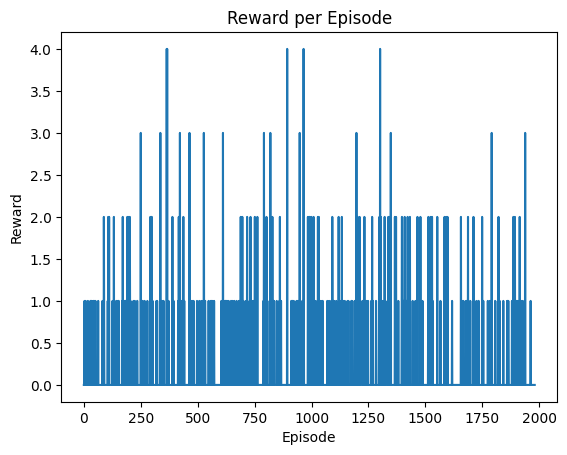

Episode 1990, Reward: 0.0
Episode 2000, Reward: 0.0
Episode 2010, Reward: 0.0
Episode 2020, Reward: 0.0
Episode 2030, Reward: 0.0
Episode 2040, Reward: 0.0
Episode 2050, Reward: 0.0
Episode 2060, Reward: 0.0
Episode 2070, Reward: 0.0
Episode 2080, Reward: 0.0
Episode 2090, Reward: 0.0
Episode 2100, Reward: 0.0
Episode 2110, Reward: 0.0
Episode 2120, Reward: 0.0
Episode 2130, Reward: 0.0
Episode 2140, Reward: 0.0
Episode 2150, Reward: 0.0
Episode 2160, Reward: 0.0
Episode 2170, Reward: 0.0
Episode 2180, Reward: 0.0
Episode 2190, Reward: 0.0
Episode 2200, Reward: 0.0
Episode 2210, Reward: 0.0
Episode 2220, Reward: 1.0
Episode 2230, Reward: 0.0
Episode 2240, Reward: 0.0
Episode 2250, Reward: 0.0
Episode 2260, Reward: 0.0
Episode 2270, Reward: 0.0
Episode 2280, Reward: 0.0
Episode 2290, Reward: 0.0
Episode 2300, Reward: 1.0
Episode 2310, Reward: 0.0


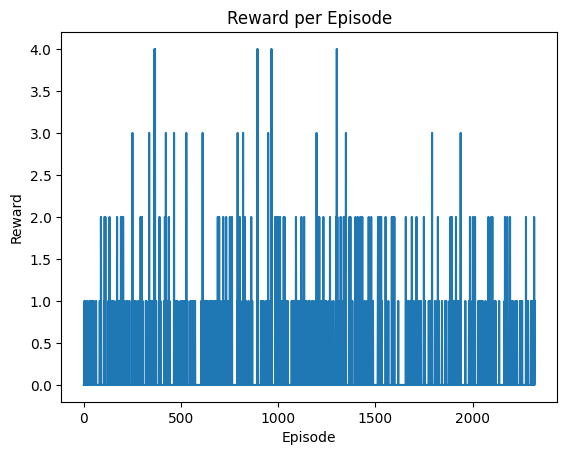

Episode 2320, Reward: 0.0
Episode 2330, Reward: 0.0
Episode 2340, Reward: 0.0
Episode 2350, Reward: 0.0
Episode 2360, Reward: 0.0
Episode 2370, Reward: 0.0
Episode 2380, Reward: 0.0
Episode 2390, Reward: 0.0
Episode 2400, Reward: 0.0
Episode 2410, Reward: 2.0
Episode 2420, Reward: 0.0
Episode 2430, Reward: 0.0
Episode 2440, Reward: 0.0
Episode 2450, Reward: 0.0
Episode 2460, Reward: 0.0
Episode 2470, Reward: 0.0
Episode 2480, Reward: 0.0
Episode 2490, Reward: 0.0
Episode 2500, Reward: 0.0
Episode 2510, Reward: 0.0
Episode 2520, Reward: 0.0
Episode 2530, Reward: 0.0
Episode 2540, Reward: 0.0
Episode 2550, Reward: 0.0
Episode 2560, Reward: 0.0
Episode 2570, Reward: 0.0
Episode 2580, Reward: 0.0
Episode 2590, Reward: 0.0
Episode 2600, Reward: 0.0
Episode 2610, Reward: 0.0
Episode 2620, Reward: 0.0
Episode 2630, Reward: 0.0


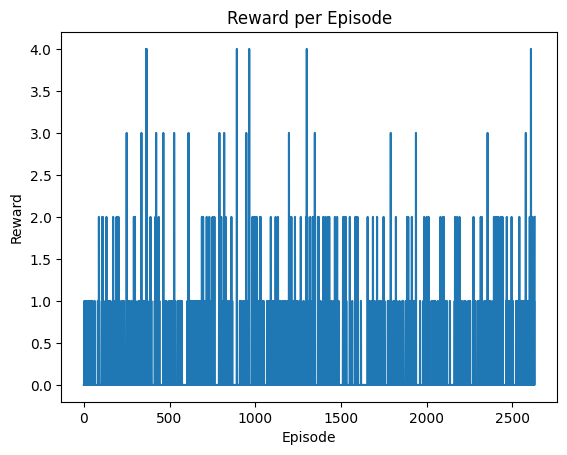

Episode 2640, Reward: 0.0
Episode 2650, Reward: 1.0
Episode 2660, Reward: 0.0
Episode 2670, Reward: 0.0
Episode 2680, Reward: 1.0
Episode 2690, Reward: 4.0
Episode 2700, Reward: 0.0
Episode 2710, Reward: 0.0
Episode 2720, Reward: 1.0
Episode 2730, Reward: 0.0
Episode 2740, Reward: 1.0
Episode 2750, Reward: 0.0
Episode 2760, Reward: 0.0
Episode 2770, Reward: 0.0
Episode 2780, Reward: 0.0
Episode 2790, Reward: 0.0
Episode 2800, Reward: 0.0
Episode 2810, Reward: 0.0
Episode 2820, Reward: 0.0
Episode 2830, Reward: 0.0
Episode 2840, Reward: 0.0
Episode 2850, Reward: 0.0
Episode 2860, Reward: 0.0
Episode 2870, Reward: 1.0
Episode 2880, Reward: 0.0
Episode 2890, Reward: 0.0
Episode 2900, Reward: 0.0
Episode 2910, Reward: 0.0
Episode 2920, Reward: 0.0
Episode 2930, Reward: 0.0
Episode 2940, Reward: 0.0


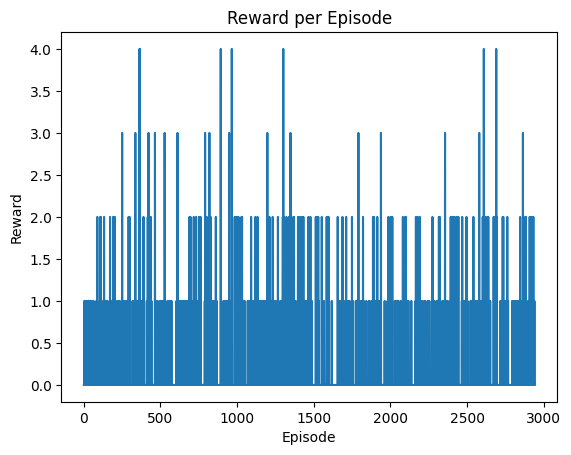

Episode 2950, Reward: 0.0
Episode 2960, Reward: 0.0
Episode 2970, Reward: 0.0
Episode 2980, Reward: 0.0
Episode 2990, Reward: 0.0
Episode 3000, Reward: 0.0
Episode 3010, Reward: 0.0
Episode 3020, Reward: 0.0
Episode 3030, Reward: 0.0
Episode 3040, Reward: 1.0
Episode 3050, Reward: 0.0
Episode 3060, Reward: 0.0
Episode 3070, Reward: 0.0
Episode 3080, Reward: 0.0
Episode 3090, Reward: 0.0
Episode 3100, Reward: 0.0
Episode 3110, Reward: 0.0
Episode 3120, Reward: 0.0
Episode 3130, Reward: 0.0
Episode 3140, Reward: 0.0
Episode 3150, Reward: 0.0
Episode 3160, Reward: 0.0
Episode 3170, Reward: 0.0
Episode 3180, Reward: 0.0
Episode 3190, Reward: 0.0
Episode 3200, Reward: 0.0
Episode 3210, Reward: 0.0
Episode 3220, Reward: 0.0
Episode 3230, Reward: 0.0
Episode 3240, Reward: 0.0
Episode 3250, Reward: 0.0


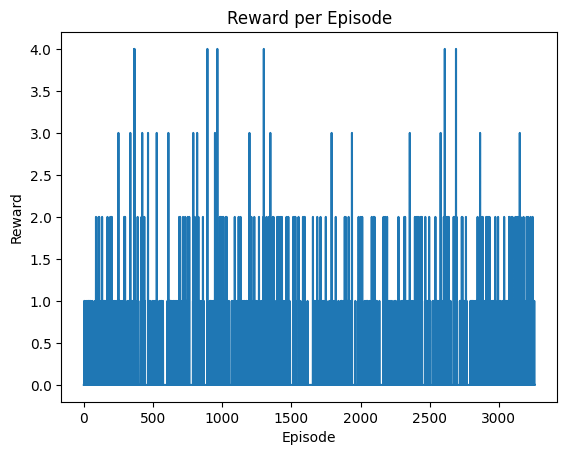

Episode 3260, Reward: 0.0
Episode 3270, Reward: 0.0
Episode 3280, Reward: 1.0
Episode 3290, Reward: 0.0
Episode 3300, Reward: 0.0
Episode 3310, Reward: 0.0
Episode 3320, Reward: 0.0
Episode 3330, Reward: 0.0
Episode 3340, Reward: 0.0
Episode 3350, Reward: 0.0
Episode 3360, Reward: 0.0
Episode 3370, Reward: 0.0
Episode 3380, Reward: 0.0
Episode 3390, Reward: 0.0
Episode 3400, Reward: 0.0
Episode 3410, Reward: 0.0
Episode 3420, Reward: 0.0
Episode 3430, Reward: 0.0
Episode 3440, Reward: 0.0
Episode 3450, Reward: 0.0
Episode 3460, Reward: 0.0
Episode 3470, Reward: 0.0
Episode 3480, Reward: 0.0
Episode 3490, Reward: 0.0
Episode 3500, Reward: 0.0
Episode 3510, Reward: 0.0
Episode 3520, Reward: 0.0
Episode 3530, Reward: 0.0
Episode 3540, Reward: 0.0
Episode 3550, Reward: 0.0
Episode 3560, Reward: 0.0


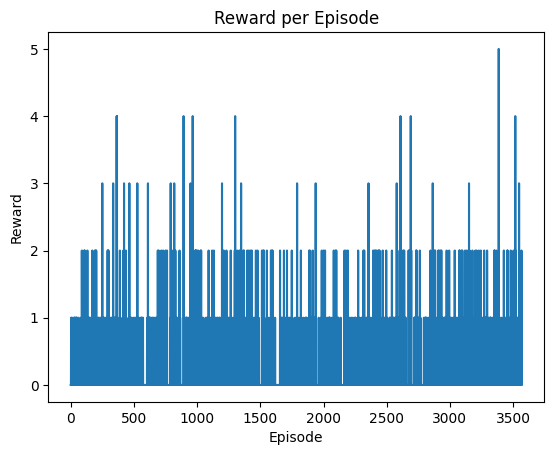

Episode 3570, Reward: 0.0
Episode 3580, Reward: 0.0
Episode 3590, Reward: 0.0
Episode 3600, Reward: 0.0
Episode 3610, Reward: 0.0
Episode 3620, Reward: 0.0
Episode 3630, Reward: 0.0
Episode 3640, Reward: 0.0
Episode 3650, Reward: 0.0
Episode 3660, Reward: 0.0
Episode 3670, Reward: 0.0
Episode 3680, Reward: 0.0
Episode 3690, Reward: 0.0
Episode 3700, Reward: 0.0
Episode 3710, Reward: 0.0
Episode 3720, Reward: 0.0
Episode 3730, Reward: 0.0
Episode 3740, Reward: 0.0
Episode 3750, Reward: 0.0
Episode 3760, Reward: 0.0
Episode 3770, Reward: 0.0
Episode 3780, Reward: 0.0
Episode 3790, Reward: 0.0
Episode 3800, Reward: 0.0
Episode 3810, Reward: 0.0
Episode 3820, Reward: 0.0
Episode 3830, Reward: 0.0
Episode 3840, Reward: 0.0
Episode 3850, Reward: 0.0
Episode 3860, Reward: 0.0
Episode 3870, Reward: 0.0
Episode 3880, Reward: 0.0
Episode 3890, Reward: 0.0
Episode 3900, Reward: 0.0


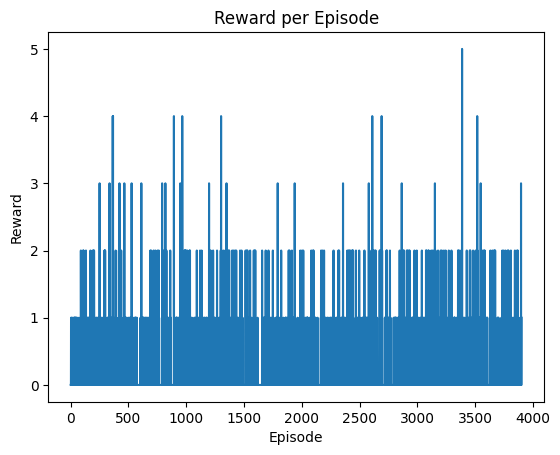

Episode 3910, Reward: 0.0
Episode 3920, Reward: 0.0
Episode 3930, Reward: 1.0
Episode 3940, Reward: 0.0
Episode 3950, Reward: 0.0
Episode 3960, Reward: 0.0
Episode 3970, Reward: 0.0
Episode 3980, Reward: 0.0
Episode 3990, Reward: 0.0
Episode 4000, Reward: 0.0
Episode 4010, Reward: 0.0
Episode 4020, Reward: 1.0
Episode 4030, Reward: 0.0
Episode 4040, Reward: 0.0
Episode 4050, Reward: 0.0
Episode 4060, Reward: 0.0
Episode 4070, Reward: 0.0
Episode 4080, Reward: 0.0
Episode 4090, Reward: 0.0
Episode 4100, Reward: 0.0
Episode 4110, Reward: 0.0
Episode 4120, Reward: 0.0
Episode 4130, Reward: 1.0
Episode 4140, Reward: 0.0
Episode 4150, Reward: 0.0
Episode 4160, Reward: 0.0
Episode 4170, Reward: 1.0
Episode 4180, Reward: 0.0
Episode 4190, Reward: 0.0
Episode 4200, Reward: 0.0
Episode 4210, Reward: 0.0
Episode 4220, Reward: 0.0


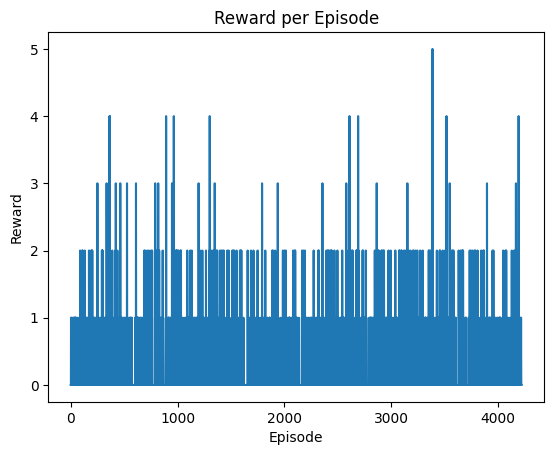

Episode 4230, Reward: 0.0
Episode 4240, Reward: 0.0
Episode 4250, Reward: 0.0
Episode 4260, Reward: 0.0
Episode 4270, Reward: 0.0
Episode 4280, Reward: 0.0
Episode 4290, Reward: 0.0
Episode 4300, Reward: 0.0
Episode 4310, Reward: 1.0
Episode 4320, Reward: 0.0
Episode 4330, Reward: 0.0
Episode 4340, Reward: 0.0
Episode 4350, Reward: 0.0
Episode 4360, Reward: 0.0
Episode 4370, Reward: 0.0
Episode 4380, Reward: 0.0
Episode 4390, Reward: 0.0
Episode 4400, Reward: 0.0
Episode 4410, Reward: 0.0
Episode 4420, Reward: 0.0
Episode 4430, Reward: 0.0
Episode 4440, Reward: 0.0
Episode 4450, Reward: 0.0
Episode 4460, Reward: 0.0
Episode 4470, Reward: 0.0
Episode 4480, Reward: 0.0
Episode 4490, Reward: 0.0
Episode 4500, Reward: 0.0
Episode 4510, Reward: 0.0
Episode 4520, Reward: 0.0
Episode 4530, Reward: 0.0
Episode 4540, Reward: 0.0


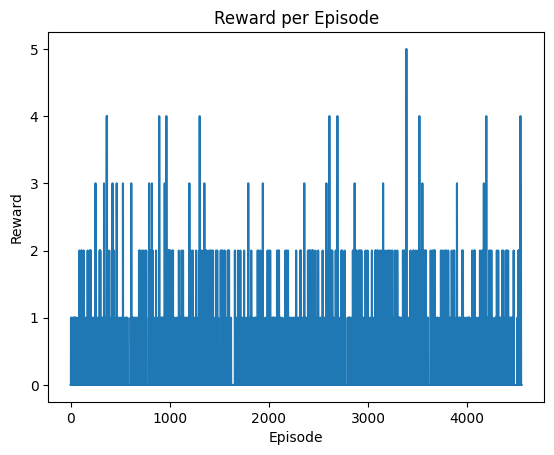

Episode 4550, Reward: 0.0
Episode 4560, Reward: 0.0
Episode 4570, Reward: 0.0
Episode 4580, Reward: 0.0
Episode 4590, Reward: 0.0
Episode 4600, Reward: 0.0
Episode 4610, Reward: 0.0
Episode 4620, Reward: 0.0
Episode 4630, Reward: 0.0
Episode 4640, Reward: 0.0
Episode 4650, Reward: 0.0
Episode 4660, Reward: 0.0
Episode 4670, Reward: 0.0
Episode 4680, Reward: 0.0
Episode 4690, Reward: 0.0
Episode 4700, Reward: 0.0
Episode 4710, Reward: 0.0
Episode 4720, Reward: 0.0
Episode 4730, Reward: 0.0
Episode 4740, Reward: 0.0
Episode 4750, Reward: 0.0
Episode 4760, Reward: 0.0
Episode 4770, Reward: 0.0
Episode 4780, Reward: 0.0
Episode 4790, Reward: 0.0
Episode 4800, Reward: 0.0
Episode 4810, Reward: 0.0
Episode 4820, Reward: 0.0
Episode 4830, Reward: 0.0
Episode 4840, Reward: 0.0
Episode 4850, Reward: 0.0
Episode 4860, Reward: 0.0
Episode 4870, Reward: 0.0


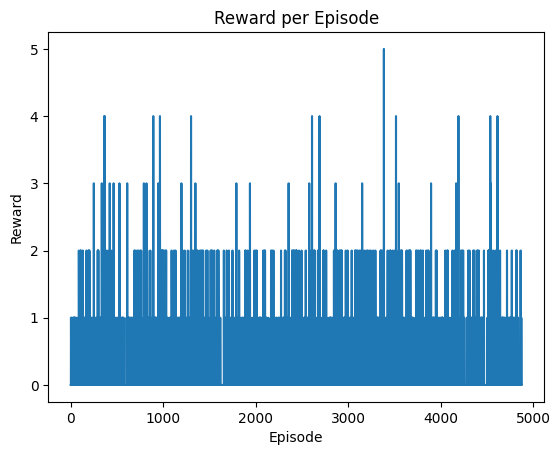

Episode 4880, Reward: 0.0
Episode 4890, Reward: 0.0
Episode 4900, Reward: 0.0
Episode 4910, Reward: 0.0
Episode 4920, Reward: 0.0
Episode 4930, Reward: 0.0
Episode 4940, Reward: 0.0
Episode 4950, Reward: 0.0
Episode 4960, Reward: 0.0
Episode 4970, Reward: 0.0
Episode 4980, Reward: 0.0
Episode 4990, Reward: 0.0
Episode 5000, Reward: 0.0
Episode 5010, Reward: 0.0
Episode 5020, Reward: 0.0
Episode 5030, Reward: 0.0
Episode 5040, Reward: 0.0
Episode 5050, Reward: 0.0
Episode 5060, Reward: 0.0
Episode 5070, Reward: 0.0
Episode 5080, Reward: 0.0
Episode 5090, Reward: 0.0
Episode 5100, Reward: 0.0
Episode 5110, Reward: 0.0
Episode 5120, Reward: 0.0
Episode 5130, Reward: 0.0
Episode 5140, Reward: 0.0
Episode 5150, Reward: 0.0
Episode 5160, Reward: 0.0
Episode 5170, Reward: 0.0
Episode 5180, Reward: 0.0
Episode 5190, Reward: 0.0
Episode 5200, Reward: 0.0


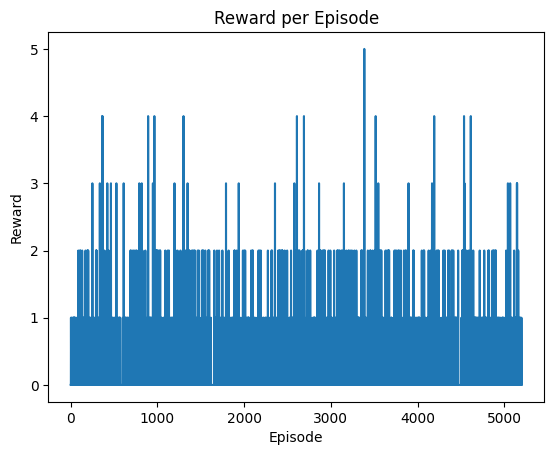

Episode 5210, Reward: 0.0
Episode 5220, Reward: 1.0
Episode 5230, Reward: 0.0
Episode 5240, Reward: 0.0
Episode 5250, Reward: 0.0
Episode 5260, Reward: 0.0
Episode 5270, Reward: 0.0
Episode 5280, Reward: 0.0
Episode 5290, Reward: 0.0
Episode 5300, Reward: 0.0
Episode 5310, Reward: 0.0
Episode 5320, Reward: 0.0
Episode 5330, Reward: 0.0
Episode 5340, Reward: 0.0
Episode 5350, Reward: 0.0
Episode 5360, Reward: 0.0
Episode 5370, Reward: 1.0
Episode 5380, Reward: 0.0
Episode 5390, Reward: 0.0
Episode 5400, Reward: 0.0
Episode 5410, Reward: 0.0
Episode 5420, Reward: 0.0
Episode 5430, Reward: 0.0
Episode 5440, Reward: 0.0
Episode 5450, Reward: 0.0
Episode 5460, Reward: 0.0
Episode 5470, Reward: 0.0
Episode 5480, Reward: 0.0
Episode 5490, Reward: 0.0
Episode 5500, Reward: 0.0
Episode 5510, Reward: 0.0


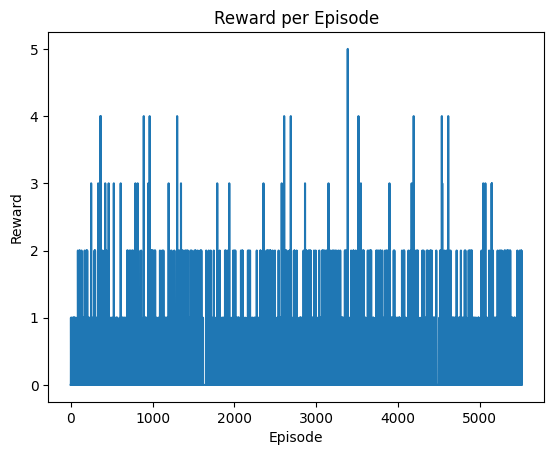

Episode 5520, Reward: 0.0
Episode 5530, Reward: 0.0
Episode 5540, Reward: 0.0
Episode 5550, Reward: 0.0
Episode 5560, Reward: 1.0
Episode 5570, Reward: 0.0
Episode 5580, Reward: 0.0
Episode 5590, Reward: 0.0
Episode 5600, Reward: 0.0
Episode 5610, Reward: 0.0
Episode 5620, Reward: 0.0
Episode 5630, Reward: 0.0
Episode 5640, Reward: 0.0
Episode 5650, Reward: 0.0
Episode 5660, Reward: 0.0
Episode 5670, Reward: 2.0
Episode 5680, Reward: 0.0
Episode 5690, Reward: 0.0
Episode 5700, Reward: 0.0
Episode 5710, Reward: 0.0
Episode 5720, Reward: 0.0
Episode 5730, Reward: 0.0
Episode 5740, Reward: 0.0
Episode 5750, Reward: 0.0
Episode 5760, Reward: 0.0
Episode 5770, Reward: 0.0
Episode 5780, Reward: 0.0
Episode 5790, Reward: 0.0
Episode 5800, Reward: 0.0
Episode 5810, Reward: 0.0
Episode 5820, Reward: 0.0


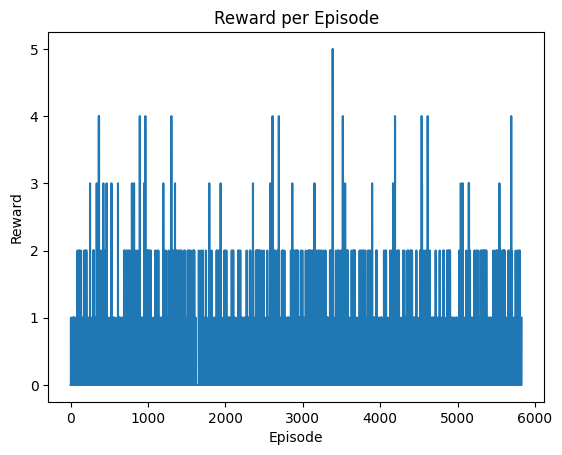

Episode 5830, Reward: 0.0
Episode 5840, Reward: 0.0
Episode 5850, Reward: 0.0
Episode 5860, Reward: 0.0
Episode 5870, Reward: 0.0
Episode 5880, Reward: 0.0
Episode 5890, Reward: 0.0
Episode 5900, Reward: 0.0
Episode 5910, Reward: 2.0
Episode 5920, Reward: 0.0
Episode 5930, Reward: 0.0
Episode 5940, Reward: 0.0
Episode 5950, Reward: 0.0
Episode 5960, Reward: 0.0
Episode 5970, Reward: 0.0
Episode 5980, Reward: 0.0
Episode 5990, Reward: 0.0
Episode 6000, Reward: 0.0
Episode 6010, Reward: 0.0
Episode 6020, Reward: 0.0
Episode 6030, Reward: 0.0
Episode 6040, Reward: 0.0
Episode 6050, Reward: 0.0
Episode 6060, Reward: 0.0
Episode 6070, Reward: 0.0
Episode 6080, Reward: 0.0
Episode 6090, Reward: 0.0
Episode 6100, Reward: 0.0
Episode 6110, Reward: 0.0
Episode 6120, Reward: 0.0


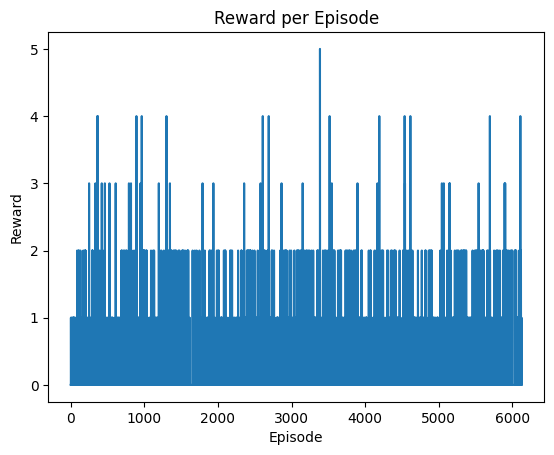

Episode 6130, Reward: 0.0
Episode 6140, Reward: 0.0
Episode 6150, Reward: 0.0
Episode 6160, Reward: 0.0
Episode 6170, Reward: 0.0
Episode 6180, Reward: 0.0
Episode 6190, Reward: 0.0
Episode 6200, Reward: 0.0
Episode 6210, Reward: 0.0
Episode 6220, Reward: 0.0
Episode 6230, Reward: 0.0
Episode 6240, Reward: 0.0
Episode 6250, Reward: 1.0
Episode 6260, Reward: 0.0
Episode 6270, Reward: 0.0
Episode 6280, Reward: 0.0
Episode 6290, Reward: 0.0
Episode 6300, Reward: 0.0
Episode 6310, Reward: 1.0
Episode 6320, Reward: 3.0
Episode 6330, Reward: 0.0
Episode 6340, Reward: 0.0
Episode 6350, Reward: 0.0
Episode 6360, Reward: 1.0
Episode 6370, Reward: 0.0
Episode 6380, Reward: 0.0
Episode 6390, Reward: 0.0
Episode 6400, Reward: 0.0
Episode 6410, Reward: 0.0
Episode 6420, Reward: 1.0


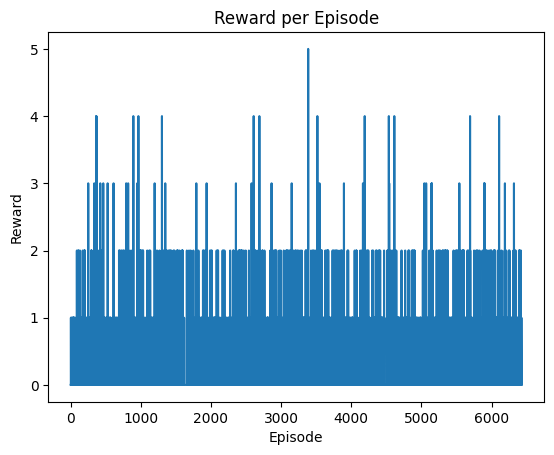

Episode 6430, Reward: 0.0
Episode 6440, Reward: 0.0
Episode 6450, Reward: 1.0
Episode 6460, Reward: 0.0
Episode 6470, Reward: 0.0
Episode 6480, Reward: 0.0
Episode 6490, Reward: 0.0
Episode 6500, Reward: 2.0
Episode 6510, Reward: 0.0
Episode 6520, Reward: 0.0
Episode 6530, Reward: 0.0
Episode 6540, Reward: 0.0
Episode 6550, Reward: 0.0
Episode 6560, Reward: 1.0
Episode 6570, Reward: 0.0
Episode 6580, Reward: 0.0
Episode 6590, Reward: 0.0
Episode 6600, Reward: 0.0
Episode 6610, Reward: 0.0
Episode 6620, Reward: 0.0
Episode 6630, Reward: 1.0
Episode 6640, Reward: 0.0
Episode 6650, Reward: 0.0
Episode 6660, Reward: 0.0
Episode 6670, Reward: 0.0
Episode 6680, Reward: 0.0
Episode 6690, Reward: 0.0
Episode 6700, Reward: 1.0
Episode 6710, Reward: 0.0
Episode 6720, Reward: 0.0
Episode 6730, Reward: 0.0


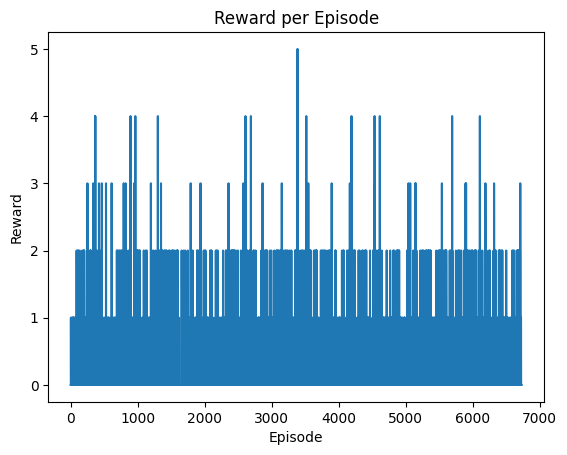

Episode 6740, Reward: 0.0
Episode 6750, Reward: 0.0
Episode 6760, Reward: 0.0
Episode 6770, Reward: 0.0
Episode 6780, Reward: 1.0
Episode 6790, Reward: 0.0
Episode 6800, Reward: 0.0
Episode 6810, Reward: 0.0
Episode 6820, Reward: 0.0
Episode 6830, Reward: 1.0
Episode 6840, Reward: 0.0
Episode 6850, Reward: 0.0
Episode 6860, Reward: 0.0
Episode 6870, Reward: 0.0
Episode 6880, Reward: 1.0
Episode 6890, Reward: 0.0
Episode 6900, Reward: 0.0
Episode 6910, Reward: 0.0
Episode 6920, Reward: 0.0
Episode 6930, Reward: 0.0
Episode 6940, Reward: 0.0
Episode 6950, Reward: 0.0
Episode 6960, Reward: 0.0
Episode 6970, Reward: 0.0
Episode 6980, Reward: 0.0
Episode 6990, Reward: 1.0
Episode 7000, Reward: 1.0
Episode 7010, Reward: 0.0
Episode 7020, Reward: 1.0


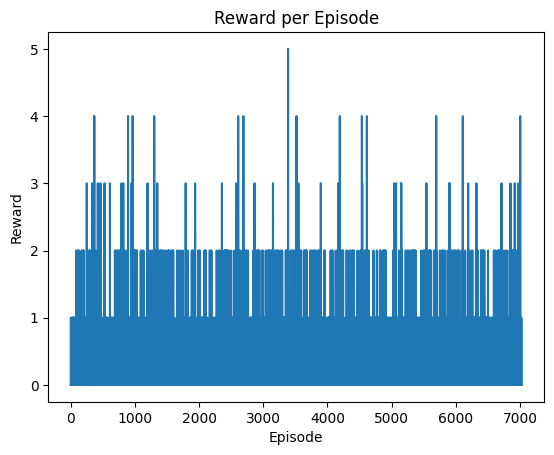

Episode 7030, Reward: 0.0
Episode 7040, Reward: 0.0
Episode 7050, Reward: 0.0
Episode 7060, Reward: 1.0
Episode 7070, Reward: 0.0
Episode 7080, Reward: 0.0
Episode 7090, Reward: 0.0
Episode 7100, Reward: 0.0
Episode 7110, Reward: 1.0
Episode 7120, Reward: 0.0
Episode 7130, Reward: 1.0
Episode 7140, Reward: 0.0
Episode 7150, Reward: 0.0
Episode 7160, Reward: 0.0
Episode 7170, Reward: 0.0
Episode 7180, Reward: 1.0
Episode 7190, Reward: 0.0
Episode 7200, Reward: 0.0
Episode 7210, Reward: 0.0
Episode 7220, Reward: 0.0
Episode 7230, Reward: 0.0
Episode 7240, Reward: 0.0
Episode 7250, Reward: 0.0
Episode 7260, Reward: 0.0
Episode 7270, Reward: 0.0
Episode 7280, Reward: 0.0
Episode 7290, Reward: 0.0
Episode 7300, Reward: 0.0
Episode 7310, Reward: 0.0


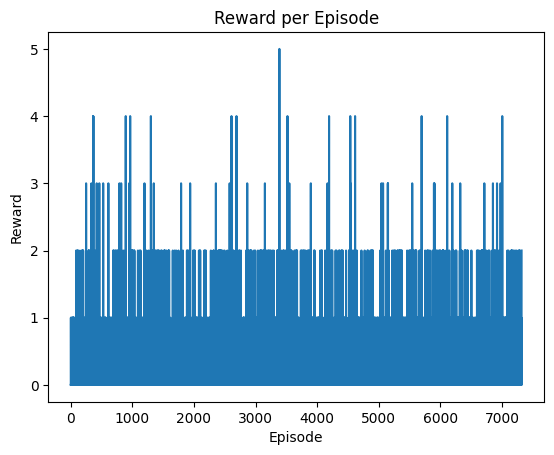

Episode 7320, Reward: 0.0
Episode 7330, Reward: 0.0
Episode 7340, Reward: 0.0
Episode 7350, Reward: 0.0
Episode 7360, Reward: 0.0
Episode 7370, Reward: 0.0
Episode 7380, Reward: 1.0
Episode 7390, Reward: 0.0
Episode 7400, Reward: 0.0
Episode 7410, Reward: 0.0
Episode 7420, Reward: 2.0
Episode 7430, Reward: 0.0
Episode 7440, Reward: 0.0
Episode 7450, Reward: 0.0
Episode 7460, Reward: 0.0
Episode 7470, Reward: 0.0
Episode 7480, Reward: 0.0
Episode 7490, Reward: 0.0
Episode 7500, Reward: 2.0
Episode 7510, Reward: 0.0
Episode 7520, Reward: 2.0
Episode 7530, Reward: 0.0
Episode 7540, Reward: 0.0
Episode 7550, Reward: 1.0
Episode 7560, Reward: 0.0
Episode 7570, Reward: 1.0
Episode 7580, Reward: 0.0
Episode 7590, Reward: 0.0
Episode 7600, Reward: 0.0


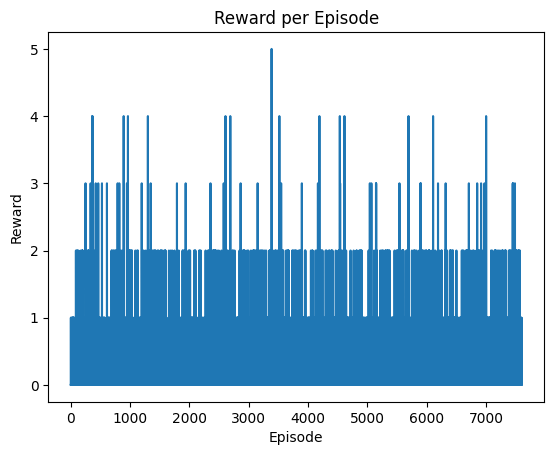

Episode 7610, Reward: 0.0
Episode 7620, Reward: 0.0
Episode 7630, Reward: 0.0
Episode 7640, Reward: 0.0
Episode 7650, Reward: 0.0
Episode 7660, Reward: 0.0
Episode 7670, Reward: 0.0
Episode 7680, Reward: 0.0
Episode 7690, Reward: 0.0
Episode 7700, Reward: 1.0
Episode 7710, Reward: 0.0
Episode 7720, Reward: 0.0
Episode 7730, Reward: 0.0
Episode 7740, Reward: 0.0
Episode 7750, Reward: 0.0
Episode 7760, Reward: 0.0
Episode 7770, Reward: 1.0
Episode 7780, Reward: 0.0
Episode 7790, Reward: 0.0
Episode 7800, Reward: 0.0
Episode 7810, Reward: 0.0
Episode 7820, Reward: 0.0
Episode 7830, Reward: 0.0
Episode 7840, Reward: 0.0
Episode 7850, Reward: 0.0
Episode 7860, Reward: 0.0
Episode 7870, Reward: 0.0
Episode 7880, Reward: 0.0


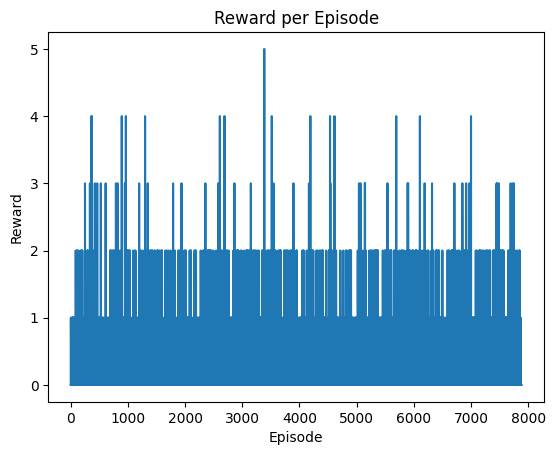

Episode 7890, Reward: 0.0
Episode 7900, Reward: 1.0
Episode 7910, Reward: 0.0
Episode 7920, Reward: 0.0
Episode 7930, Reward: 0.0
Episode 7940, Reward: 0.0
Episode 7950, Reward: 0.0
Episode 7960, Reward: 1.0
Episode 7970, Reward: 0.0
Episode 7980, Reward: 0.0
Episode 7990, Reward: 1.0
Episode 8000, Reward: 0.0
Episode 8010, Reward: 0.0
Episode 8020, Reward: 0.0
Episode 8030, Reward: 2.0
Episode 8040, Reward: 0.0
Episode 8050, Reward: 0.0
Episode 8060, Reward: 1.0
Episode 8070, Reward: 1.0
Episode 8080, Reward: 0.0
Episode 8090, Reward: 1.0
Episode 8100, Reward: 0.0
Episode 8110, Reward: 0.0
Episode 8120, Reward: 1.0
Episode 8130, Reward: 0.0
Episode 8140, Reward: 0.0
Episode 8150, Reward: 0.0


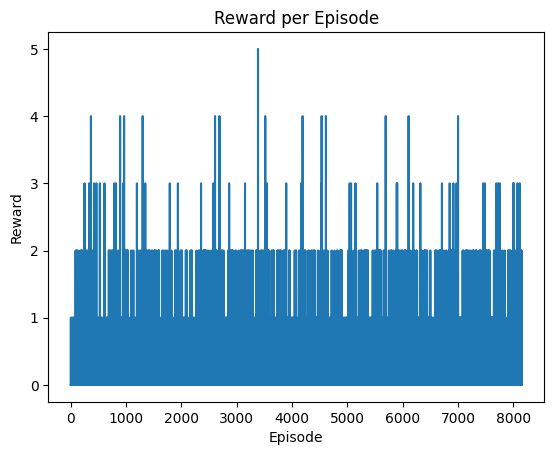

Episode 8160, Reward: 0.0
Episode 8170, Reward: 0.0
Episode 8180, Reward: 0.0
Episode 8190, Reward: 2.0
Episode 8200, Reward: 0.0
Episode 8210, Reward: 0.0
Episode 8220, Reward: 1.0
Episode 8230, Reward: 0.0
Episode 8240, Reward: 0.0
Episode 8250, Reward: 0.0
Episode 8260, Reward: 1.0
Episode 8270, Reward: 2.0
Episode 8280, Reward: 5.0
Episode 8290, Reward: 0.0
Episode 8300, Reward: 2.0
Episode 8310, Reward: 0.0
Episode 8320, Reward: 0.0
Episode 8330, Reward: 0.0
Episode 8340, Reward: 0.0
Episode 8350, Reward: 0.0
Episode 8360, Reward: 0.0
Episode 8370, Reward: 0.0
Episode 8380, Reward: 0.0
Episode 8390, Reward: 0.0
Episode 8400, Reward: 2.0


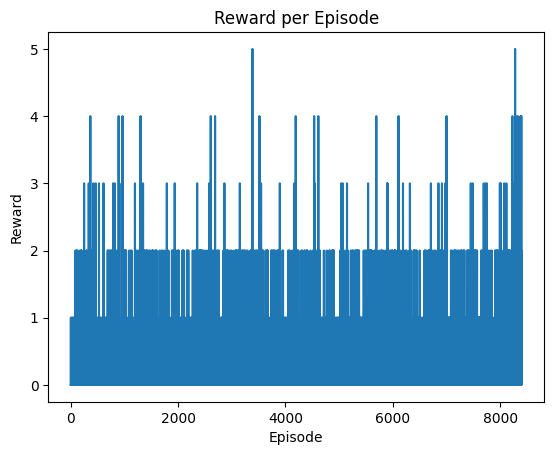

Episode 8410, Reward: 0.0
Episode 8420, Reward: 1.0
Episode 8430, Reward: 0.0
Episode 8440, Reward: 0.0
Episode 8450, Reward: 0.0
Episode 8460, Reward: 2.0
Episode 8470, Reward: 0.0
Episode 8480, Reward: 0.0
Episode 8490, Reward: 1.0
Episode 8500, Reward: 0.0
Episode 8510, Reward: 0.0
Episode 8520, Reward: 1.0
Episode 8530, Reward: 0.0
Episode 8540, Reward: 0.0
Episode 8550, Reward: 1.0
Episode 8560, Reward: 0.0
Episode 8570, Reward: 0.0
Episode 8580, Reward: 0.0
Episode 8590, Reward: 0.0
Episode 8600, Reward: 0.0
Episode 8610, Reward: 0.0
Episode 8620, Reward: 0.0
Episode 8630, Reward: 1.0
Episode 8640, Reward: 0.0
Episode 8650, Reward: 0.0
Episode 8660, Reward: 0.0
Episode 8670, Reward: 0.0


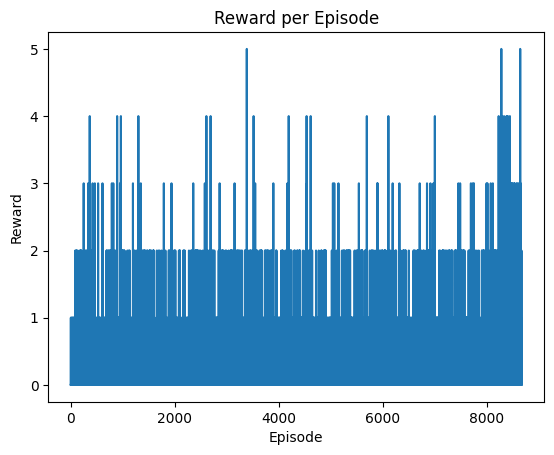

Episode 8680, Reward: 0.0
Episode 8690, Reward: 0.0
Episode 8700, Reward: 1.0
Episode 8710, Reward: 0.0
Episode 8720, Reward: 0.0
Episode 8730, Reward: 0.0
Episode 8740, Reward: 0.0
Episode 8750, Reward: 1.0
Episode 8760, Reward: 0.0
Episode 8770, Reward: 0.0
Episode 8780, Reward: 0.0
Episode 8790, Reward: 0.0
Episode 8800, Reward: 0.0
Episode 8810, Reward: 0.0
Episode 8820, Reward: 0.0
Episode 8830, Reward: 0.0
Episode 8840, Reward: 0.0
Episode 8850, Reward: 0.0
Episode 8860, Reward: 0.0
Episode 8870, Reward: 0.0
Episode 8880, Reward: 0.0
Episode 8890, Reward: 0.0
Episode 8900, Reward: 1.0
Episode 8910, Reward: 2.0
Episode 8920, Reward: 0.0


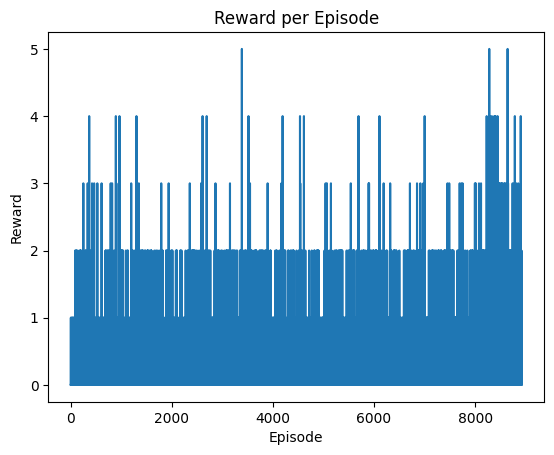

Episode 8930, Reward: 0.0
Episode 8940, Reward: 0.0
Episode 8950, Reward: 0.0
Episode 8960, Reward: 0.0
Episode 8970, Reward: 0.0
Episode 8980, Reward: 0.0
Episode 8990, Reward: 0.0
Episode 9000, Reward: 1.0
Episode 9010, Reward: 0.0
Episode 9020, Reward: 1.0
Episode 9030, Reward: 0.0
Episode 9040, Reward: 0.0
Episode 9050, Reward: 0.0
Episode 9060, Reward: 0.0
Episode 9070, Reward: 0.0
Episode 9080, Reward: 1.0
Episode 9090, Reward: 0.0
Episode 9100, Reward: 1.0
Episode 9110, Reward: 0.0
Episode 9120, Reward: 0.0
Episode 9130, Reward: 2.0
Episode 9140, Reward: 0.0
Episode 9150, Reward: 0.0
Episode 9160, Reward: 0.0
Episode 9170, Reward: 1.0


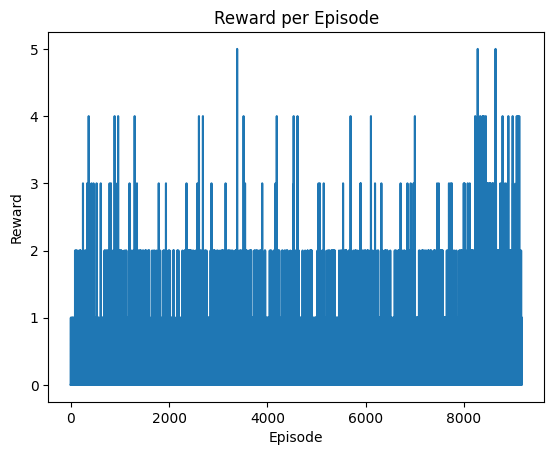

Episode 9180, Reward: 0.0
Episode 9190, Reward: 0.0
Episode 9200, Reward: 0.0
Episode 9210, Reward: 0.0
Episode 9220, Reward: 0.0
Episode 9230, Reward: 2.0
Episode 9240, Reward: 0.0
Episode 9250, Reward: 1.0
Episode 9260, Reward: 0.0
Episode 9270, Reward: 1.0
Episode 9280, Reward: 0.0
Episode 9290, Reward: 0.0
Episode 9300, Reward: 0.0
Episode 9310, Reward: 0.0
Episode 9320, Reward: 0.0
Episode 9330, Reward: 1.0
Episode 9340, Reward: 0.0
Episode 9350, Reward: 0.0
Episode 9360, Reward: 0.0
Episode 9370, Reward: 0.0
Episode 9380, Reward: 0.0
Episode 9390, Reward: 0.0
Episode 9400, Reward: 1.0
Episode 9410, Reward: 0.0


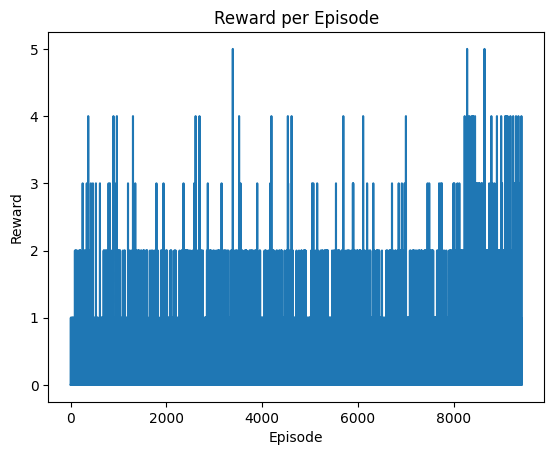

Episode 9420, Reward: 0.0
Episode 9430, Reward: 0.0
Episode 9440, Reward: 0.0
Episode 9450, Reward: 0.0
Episode 9460, Reward: 1.0
Episode 9470, Reward: 0.0
Episode 9480, Reward: 0.0
Episode 9490, Reward: 0.0
Episode 9500, Reward: 0.0
Episode 9510, Reward: 0.0
Episode 9520, Reward: 0.0
Episode 9530, Reward: 0.0
Episode 9540, Reward: 0.0
Episode 9550, Reward: 0.0
Episode 9560, Reward: 0.0
Episode 9570, Reward: 0.0
Episode 9580, Reward: 0.0
Episode 9590, Reward: 1.0
Episode 9600, Reward: 0.0
Episode 9610, Reward: 0.0
Episode 9620, Reward: 1.0
Episode 9630, Reward: 0.0
Episode 9640, Reward: 0.0
Episode 9650, Reward: 0.0


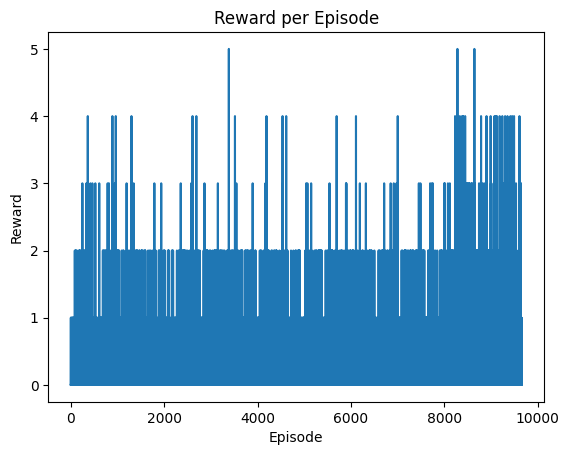

Episode 9660, Reward: 1.0
Episode 9670, Reward: 0.0
Episode 9680, Reward: 0.0
Episode 9690, Reward: 0.0
Episode 9700, Reward: 3.0
Episode 9710, Reward: 0.0
Episode 9720, Reward: 0.0
Episode 9730, Reward: 0.0
Episode 9740, Reward: 0.0
Episode 9750, Reward: 0.0
Episode 9760, Reward: 0.0
Episode 9770, Reward: 0.0
Episode 9780, Reward: 0.0
Episode 9790, Reward: 0.0
Episode 9800, Reward: 0.0
Episode 9810, Reward: 0.0
Episode 9820, Reward: 0.0
Episode 9830, Reward: 2.0
Episode 9840, Reward: 0.0
Episode 9850, Reward: 1.0
Episode 9860, Reward: 0.0
Episode 9870, Reward: 0.0


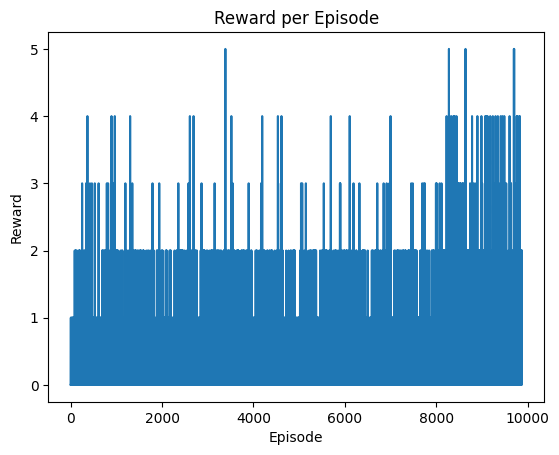

Episode 9880, Reward: 0.0
Episode 9890, Reward: 0.0
Episode 9900, Reward: 2.0
Episode 9910, Reward: 0.0
Episode 9920, Reward: 0.0
Episode 9930, Reward: 0.0
Episode 9940, Reward: 0.0
Episode 9950, Reward: 5.0
Episode 9960, Reward: 0.0
Episode 9970, Reward: 0.0
Episode 9980, Reward: 0.0
Episode 9990, Reward: 0.0
Episode 10000, Reward: 0.0
Episode 10010, Reward: 1.0
Episode 10020, Reward: 0.0
Episode 10030, Reward: 1.0
Episode 10040, Reward: 0.0
Episode 10050, Reward: 0.0
Episode 10060, Reward: 0.0


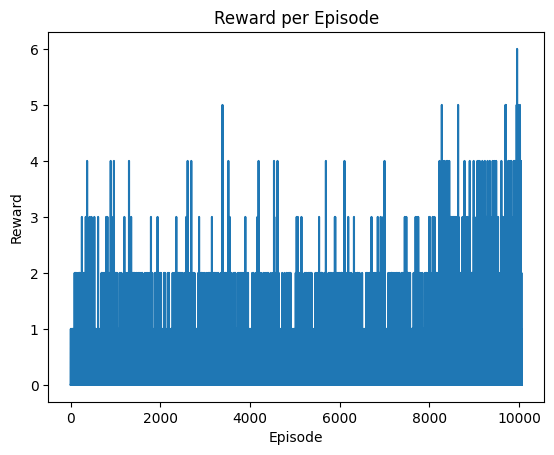

Episode 10070, Reward: 0.0
Episode 10080, Reward: 5.0
Episode 10090, Reward: 0.0
Episode 10100, Reward: 1.0
Episode 10110, Reward: 0.0
Episode 10120, Reward: 0.0
Episode 10130, Reward: 0.0
Episode 10140, Reward: 0.0
Episode 10150, Reward: 2.0
Episode 10160, Reward: 0.0
Episode 10170, Reward: 0.0
Episode 10180, Reward: 0.0
Episode 10190, Reward: 0.0
Episode 10200, Reward: 0.0
Episode 10210, Reward: 0.0
Episode 10220, Reward: 0.0
Episode 10230, Reward: 0.0
Episode 10240, Reward: 0.0
Episode 10250, Reward: 0.0
Episode 10260, Reward: 0.0
Episode 10270, Reward: 0.0
Episode 10280, Reward: 0.0
Episode 10290, Reward: 0.0
Episode 10300, Reward: 0.0
Episode 10310, Reward: 3.0


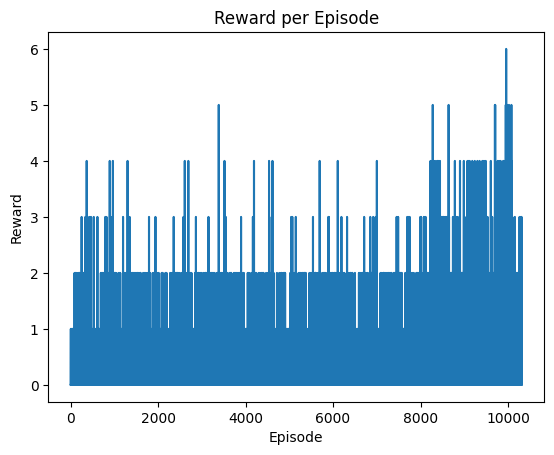

Episode 10320, Reward: 0.0
Episode 10330, Reward: 0.0
Episode 10340, Reward: 0.0
Episode 10350, Reward: 1.0
Episode 10360, Reward: 0.0
Episode 10370, Reward: 0.0
Episode 10380, Reward: 0.0
Episode 10390, Reward: 0.0
Episode 10400, Reward: 1.0
Episode 10410, Reward: 0.0
Episode 10420, Reward: 0.0
Episode 10430, Reward: 0.0
Episode 10440, Reward: 0.0
Episode 10450, Reward: 0.0
Episode 10460, Reward: 1.0
Episode 10470, Reward: 0.0
Episode 10480, Reward: 0.0
Episode 10490, Reward: 0.0
Episode 10500, Reward: 0.0
Episode 10510, Reward: 0.0
Episode 10520, Reward: 0.0


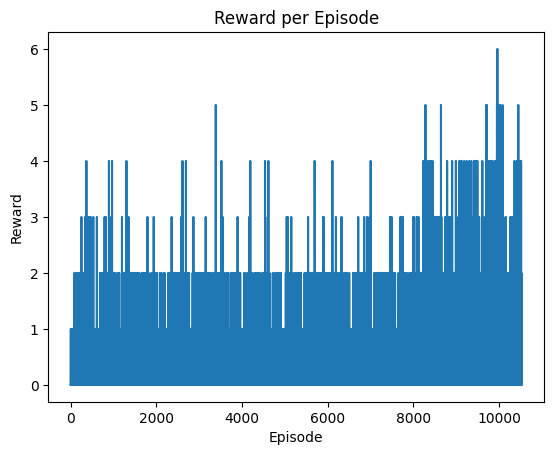

Episode 10530, Reward: 3.0
Episode 10540, Reward: 0.0
Episode 10550, Reward: 0.0
Episode 10560, Reward: 4.0
Episode 10570, Reward: 0.0
Episode 10580, Reward: 0.0
Episode 10590, Reward: 0.0
Episode 10600, Reward: 0.0
Episode 10610, Reward: 0.0
Episode 10620, Reward: 0.0
Episode 10630, Reward: 0.0
Episode 10640, Reward: 1.0
Episode 10650, Reward: 0.0
Episode 10660, Reward: 0.0
Episode 10670, Reward: 1.0
Episode 10680, Reward: 0.0
Episode 10690, Reward: 0.0
Episode 10700, Reward: 1.0
Episode 10710, Reward: 0.0
Episode 10720, Reward: 1.0
Episode 10730, Reward: 0.0
Episode 10740, Reward: 0.0
Episode 10750, Reward: 0.0
Episode 10760, Reward: 0.0


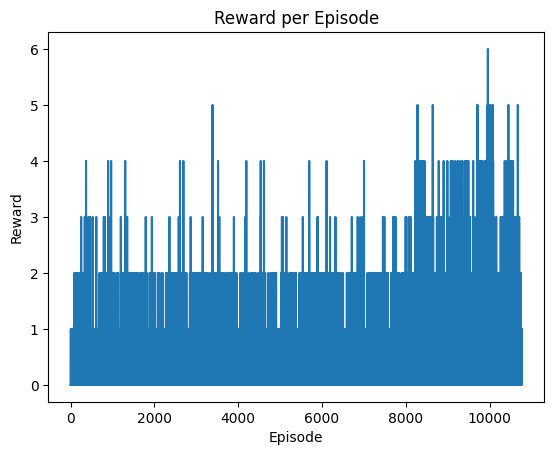

Episode 10770, Reward: 3.0
Episode 10780, Reward: 1.0
Episode 10790, Reward: 1.0
Episode 10800, Reward: 0.0
Episode 10810, Reward: 0.0
Episode 10820, Reward: 1.0
Episode 10830, Reward: 2.0
Episode 10840, Reward: 0.0
Episode 10850, Reward: 1.0
Episode 10860, Reward: 0.0
Episode 10870, Reward: 0.0
Episode 10880, Reward: 0.0
Episode 10890, Reward: 0.0
Episode 10900, Reward: 0.0
Episode 10910, Reward: 1.0
Episode 10920, Reward: 0.0
Episode 10930, Reward: 0.0
Episode 10940, Reward: 2.0
Episode 10950, Reward: 0.0
Episode 10960, Reward: 0.0
Episode 10970, Reward: 0.0
Episode 10980, Reward: 1.0
Episode 10990, Reward: 0.0
Episode 11000, Reward: 0.0
Episode 11010, Reward: 0.0


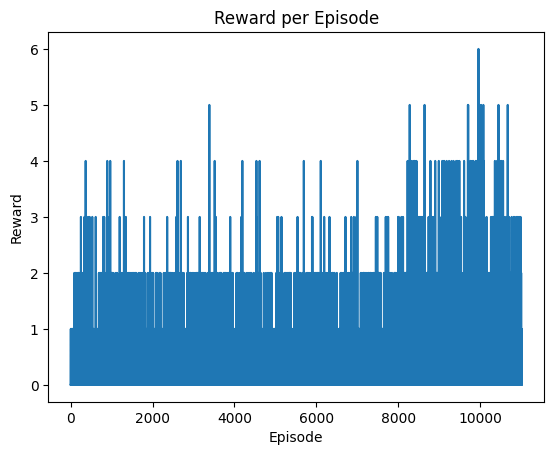

Episode 11020, Reward: 0.0
Episode 11030, Reward: 0.0
Episode 11040, Reward: 0.0
Episode 11050, Reward: 0.0
Episode 11060, Reward: 0.0
Episode 11070, Reward: 0.0
Episode 11080, Reward: 0.0
Episode 11090, Reward: 0.0
Episode 11100, Reward: 0.0
Episode 11110, Reward: 2.0
Episode 11120, Reward: 0.0
Episode 11130, Reward: 0.0
Episode 11140, Reward: 0.0
Episode 11150, Reward: 1.0
Episode 11160, Reward: 0.0
Episode 11170, Reward: 0.0
Episode 11180, Reward: 0.0
Episode 11190, Reward: 0.0
Episode 11200, Reward: 1.0
Episode 11210, Reward: 0.0
Episode 11220, Reward: 0.0
Episode 11230, Reward: 0.0
Episode 11240, Reward: 0.0
Episode 11250, Reward: 0.0
Episode 11260, Reward: 0.0
Episode 11270, Reward: 0.0
Episode 11280, Reward: 0.0
Episode 11290, Reward: 0.0


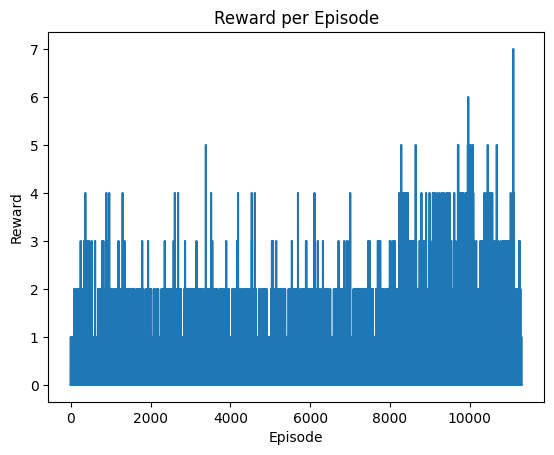

Episode 11300, Reward: 0.0
Episode 11310, Reward: 0.0
Episode 11320, Reward: 0.0
Episode 11330, Reward: 0.0
Episode 11340, Reward: 0.0
Episode 11350, Reward: 0.0
Episode 11360, Reward: 0.0
Episode 11370, Reward: 0.0
Episode 11380, Reward: 0.0
Episode 11390, Reward: 0.0
Episode 11400, Reward: 2.0
Episode 11410, Reward: 2.0
Episode 11420, Reward: 0.0
Episode 11430, Reward: 0.0
Episode 11440, Reward: 0.0
Episode 11450, Reward: 0.0
Episode 11460, Reward: 0.0
Episode 11470, Reward: 0.0
Episode 11480, Reward: 0.0
Episode 11490, Reward: 0.0
Episode 11500, Reward: 0.0
Episode 11510, Reward: 0.0
Episode 11520, Reward: 0.0
Episode 11530, Reward: 0.0
Episode 11540, Reward: 0.0
Episode 11550, Reward: 0.0


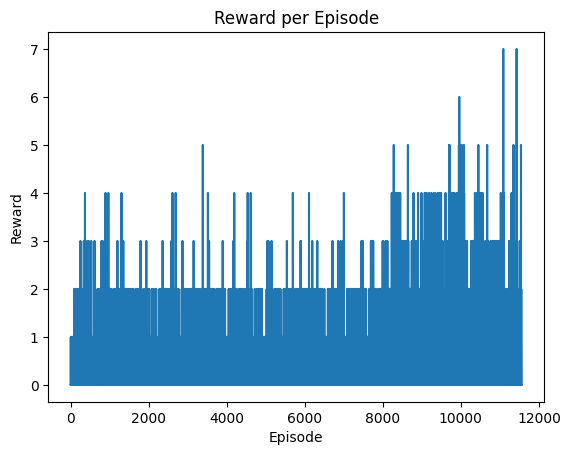

Episode 11560, Reward: 0.0
Episode 11570, Reward: 0.0
Episode 11580, Reward: 0.0
Episode 11590, Reward: 0.0
Episode 11600, Reward: 0.0
Episode 11610, Reward: 0.0
Episode 11620, Reward: 1.0
Episode 11630, Reward: 1.0
Episode 11640, Reward: 0.0
Episode 11650, Reward: 0.0
Episode 11660, Reward: 0.0
Episode 11670, Reward: 0.0
Episode 11680, Reward: 0.0
Episode 11690, Reward: 0.0
Episode 11700, Reward: 0.0
Episode 11710, Reward: 1.0
Episode 11720, Reward: 0.0
Episode 11730, Reward: 1.0
Episode 11740, Reward: 0.0
Episode 11750, Reward: 0.0
Episode 11760, Reward: 2.0
Episode 11770, Reward: 0.0
Episode 11780, Reward: 0.0
Episode 11790, Reward: 0.0
Episode 11800, Reward: 0.0
Episode 11810, Reward: 0.0
Episode 11820, Reward: 0.0
Episode 11830, Reward: 2.0


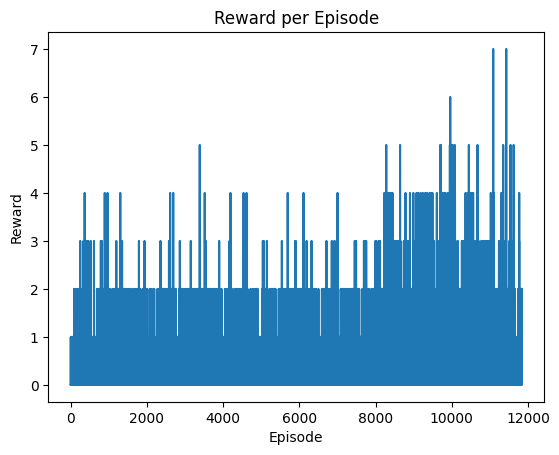

Episode 11840, Reward: 0.0
Episode 11850, Reward: 0.0
Episode 11860, Reward: 1.0
Episode 11870, Reward: 2.0
Episode 11880, Reward: 0.0
Episode 11890, Reward: 0.0
Episode 11900, Reward: 0.0
Episode 11910, Reward: 0.0
Episode 11920, Reward: 0.0
Episode 11930, Reward: 0.0
Episode 11940, Reward: 0.0
Episode 11950, Reward: 0.0
Episode 11960, Reward: 0.0
Episode 11970, Reward: 0.0
Episode 11980, Reward: 0.0
Episode 11990, Reward: 2.0
Episode 12000, Reward: 0.0
Episode 12010, Reward: 0.0
Episode 12020, Reward: 0.0
Episode 12030, Reward: 0.0
Episode 12040, Reward: 0.0
Episode 12050, Reward: 0.0
Episode 12060, Reward: 0.0
Episode 12070, Reward: 2.0


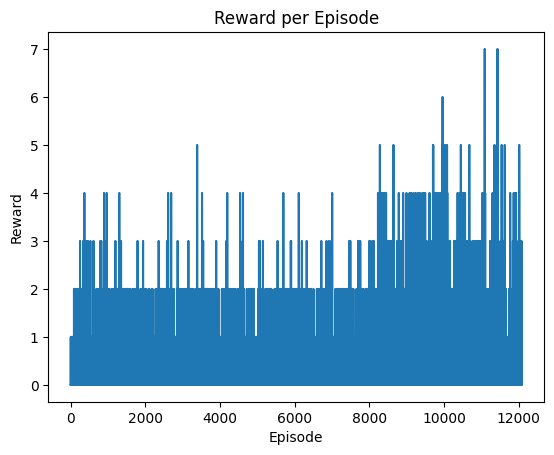

Episode 12080, Reward: 0.0
Episode 12090, Reward: 0.0
Episode 12100, Reward: 0.0
Episode 12110, Reward: 0.0
Episode 12120, Reward: 0.0
Episode 12130, Reward: 0.0
Episode 12140, Reward: 0.0
Episode 12150, Reward: 0.0
Episode 12160, Reward: 0.0
Episode 12170, Reward: 0.0
Episode 12180, Reward: 0.0
Episode 12190, Reward: 1.0
Episode 12200, Reward: 1.0
Episode 12210, Reward: 1.0
Episode 12220, Reward: 0.0
Episode 12230, Reward: 0.0
Episode 12240, Reward: 0.0
Episode 12250, Reward: 0.0
Episode 12260, Reward: 0.0
Episode 12270, Reward: 0.0
Episode 12280, Reward: 1.0
Episode 12290, Reward: 0.0
Episode 12300, Reward: 0.0
Episode 12310, Reward: 0.0
Episode 12320, Reward: 0.0


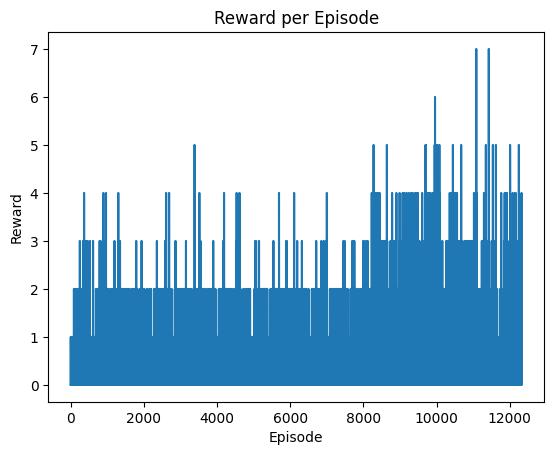

Episode 12330, Reward: 0.0
Episode 12340, Reward: 0.0
Episode 12350, Reward: 0.0
Episode 12360, Reward: 0.0
Episode 12370, Reward: 0.0
Episode 12380, Reward: 1.0
Episode 12390, Reward: 0.0
Episode 12400, Reward: 0.0
Episode 12410, Reward: 0.0
Episode 12420, Reward: 0.0
Episode 12430, Reward: 0.0
Episode 12440, Reward: 0.0
Episode 12450, Reward: 0.0
Episode 12460, Reward: 0.0
Episode 12470, Reward: 1.0
Episode 12480, Reward: 0.0
Episode 12490, Reward: 0.0
Episode 12500, Reward: 3.0
Episode 12510, Reward: 0.0
Episode 12520, Reward: 0.0
Episode 12530, Reward: 0.0
Episode 12540, Reward: 0.0
Episode 12550, Reward: 0.0


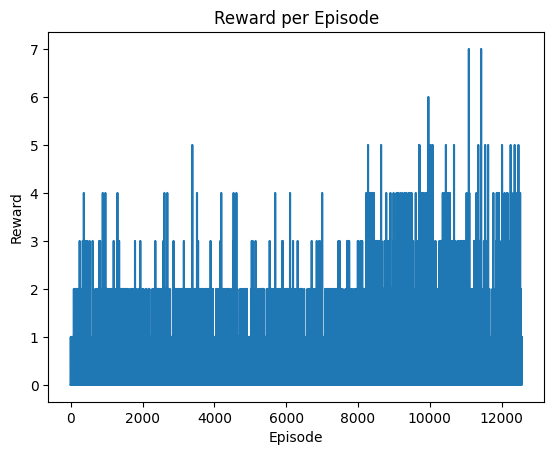

Episode 12560, Reward: 0.0
Episode 12570, Reward: 1.0
Episode 12580, Reward: 0.0
Episode 12590, Reward: 4.0
Episode 12600, Reward: 0.0
Episode 12610, Reward: 0.0
Episode 12620, Reward: 3.0
Episode 12630, Reward: 0.0
Episode 12640, Reward: 0.0
Episode 12650, Reward: 1.0
Episode 12660, Reward: 1.0
Episode 12670, Reward: 1.0
Episode 12680, Reward: 0.0
Episode 12690, Reward: 0.0
Episode 12700, Reward: 0.0
Episode 12710, Reward: 0.0
Episode 12720, Reward: 3.0
Episode 12730, Reward: 0.0
Episode 12740, Reward: 0.0
Episode 12750, Reward: 0.0


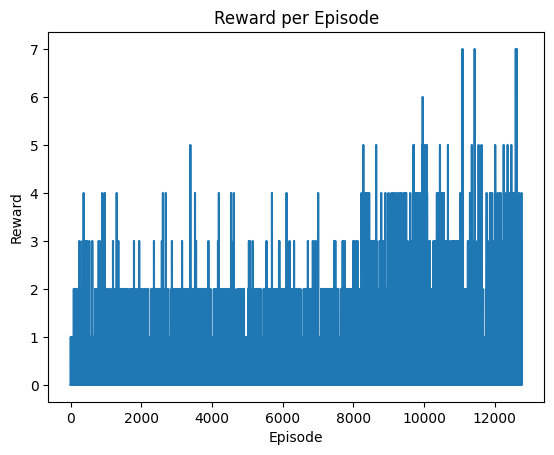

Episode 12760, Reward: 0.0
Episode 12770, Reward: 0.0
Episode 12780, Reward: 0.0
Episode 12790, Reward: 0.0
Episode 12800, Reward: 0.0
Episode 12810, Reward: 0.0
Episode 12820, Reward: 0.0
Episode 12830, Reward: 0.0
Episode 12840, Reward: 0.0
Episode 12850, Reward: 0.0
Episode 12860, Reward: 0.0
Episode 12870, Reward: 0.0
Episode 12880, Reward: 3.0
Episode 12890, Reward: 0.0
Episode 12900, Reward: 0.0
Episode 12910, Reward: 0.0
Episode 12920, Reward: 0.0
Episode 12930, Reward: 0.0
Episode 12940, Reward: 0.0
Episode 12950, Reward: 2.0
Episode 12960, Reward: 0.0


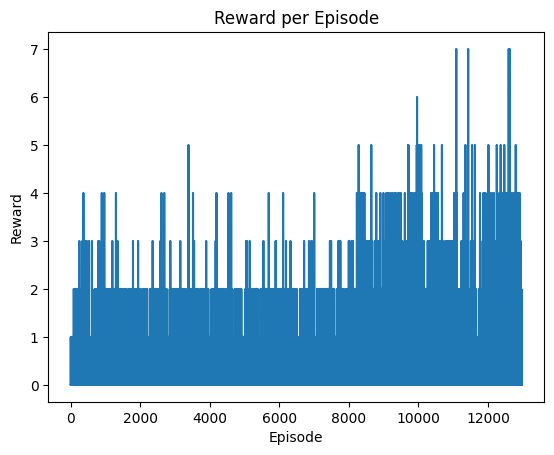

Episode 12970, Reward: 0.0
Episode 12980, Reward: 0.0
Episode 12990, Reward: 1.0
Episode 13000, Reward: 0.0
Episode 13010, Reward: 3.0
Episode 13020, Reward: 0.0
Episode 13030, Reward: 0.0
Episode 13040, Reward: 0.0
Episode 13050, Reward: 1.0
Episode 13060, Reward: 0.0
Episode 13070, Reward: 0.0
Episode 13080, Reward: 0.0
Episode 13090, Reward: 0.0
Episode 13100, Reward: 0.0
Episode 13110, Reward: 6.0
Episode 13120, Reward: 0.0
Episode 13130, Reward: 0.0
Episode 13140, Reward: 0.0
Episode 13150, Reward: 0.0
Episode 13160, Reward: 2.0
Episode 13170, Reward: 0.0


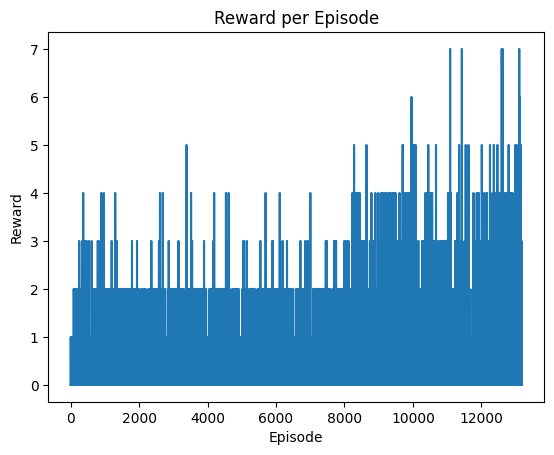

Episode 13180, Reward: 0.0
Episode 13190, Reward: 0.0
Episode 13200, Reward: 1.0
Episode 13210, Reward: 1.0
Episode 13220, Reward: 0.0
Episode 13230, Reward: 0.0
Episode 13240, Reward: 0.0
Episode 13250, Reward: 4.0
Episode 13260, Reward: 0.0
Episode 13270, Reward: 0.0
Episode 13280, Reward: 2.0
Episode 13290, Reward: 3.0
Episode 13300, Reward: 0.0
Episode 13310, Reward: 0.0
Episode 13320, Reward: 0.0
Episode 13330, Reward: 0.0
Episode 13340, Reward: 0.0
Episode 13350, Reward: 0.0
Episode 13360, Reward: 1.0
Episode 13370, Reward: 1.0
Episode 13380, Reward: 0.0
Episode 13390, Reward: 0.0


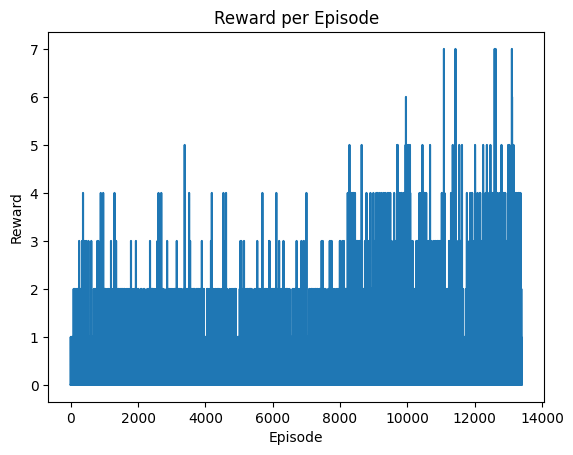

Episode 13400, Reward: 0.0
Episode 13410, Reward: 0.0
Episode 13420, Reward: 2.0
Episode 13430, Reward: 3.0
Episode 13440, Reward: 0.0
Episode 13450, Reward: 0.0
Episode 13460, Reward: 0.0
Episode 13470, Reward: 0.0
Episode 13480, Reward: 0.0
Episode 13490, Reward: 0.0
Episode 13500, Reward: 0.0
Episode 13510, Reward: 0.0
Episode 13520, Reward: 0.0
Episode 13530, Reward: 1.0
Episode 13540, Reward: 0.0
Episode 13550, Reward: 0.0
Episode 13560, Reward: 0.0
Episode 13570, Reward: 0.0
Episode 13580, Reward: 0.0
Episode 13590, Reward: 0.0
Episode 13600, Reward: 0.0


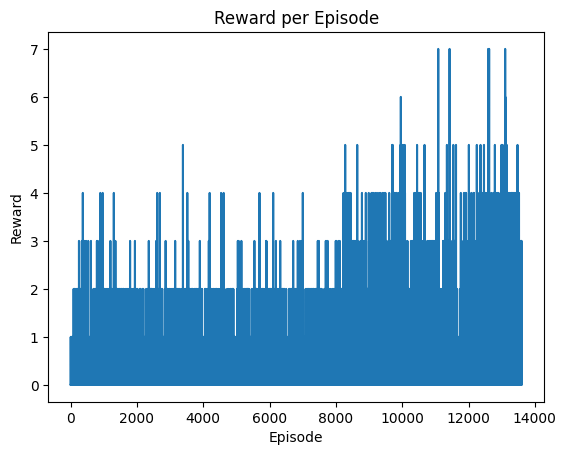

Episode 13610, Reward: 0.0
Episode 13620, Reward: 0.0
Episode 13630, Reward: 0.0
Episode 13640, Reward: 0.0
Episode 13650, Reward: 0.0
Episode 13660, Reward: 0.0
Episode 13670, Reward: 0.0
Episode 13680, Reward: 1.0
Episode 13690, Reward: 0.0
Episode 13700, Reward: 1.0
Episode 13710, Reward: 3.0
Episode 13720, Reward: 0.0
Episode 13730, Reward: 0.0
Episode 13740, Reward: 1.0
Episode 13750, Reward: 0.0
Episode 13760, Reward: 0.0
Episode 13770, Reward: 0.0
Episode 13780, Reward: 6.0
Episode 13790, Reward: 0.0


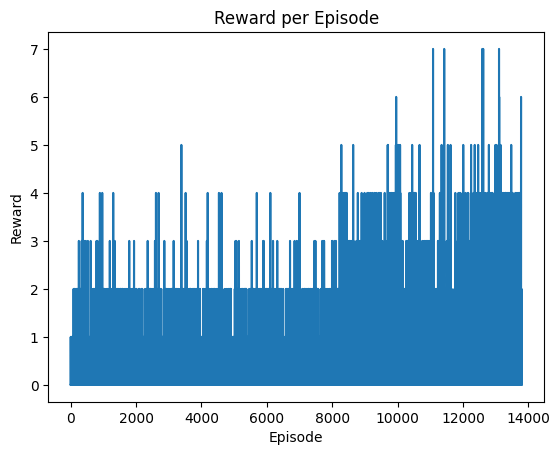

Episode 13800, Reward: 0.0
Episode 13810, Reward: 0.0
Episode 13820, Reward: 0.0
Episode 13830, Reward: 2.0
Episode 13840, Reward: 0.0
Episode 13850, Reward: 0.0
Episode 13860, Reward: 0.0
Episode 13870, Reward: 2.0
Episode 13880, Reward: 0.0
Episode 13890, Reward: 0.0
Episode 13900, Reward: 0.0
Episode 13910, Reward: 0.0
Episode 13920, Reward: 3.0
Episode 13930, Reward: 0.0
Episode 13940, Reward: 1.0
Episode 13950, Reward: 0.0
Episode 13960, Reward: 1.0
Episode 13970, Reward: 0.0


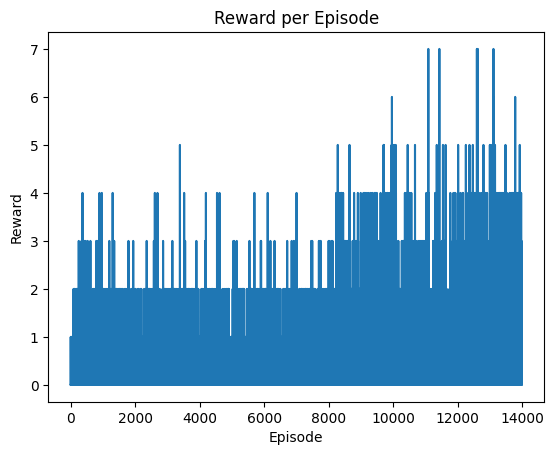

Episode 13980, Reward: 1.0
Episode 13990, Reward: 0.0
Episode 14000, Reward: 2.0
Episode 14010, Reward: 0.0
Episode 14020, Reward: 0.0
Episode 14030, Reward: 0.0
Episode 14040, Reward: 0.0
Episode 14050, Reward: 0.0
Episode 14060, Reward: 3.0
Episode 14070, Reward: 0.0
Episode 14080, Reward: 0.0
Episode 14090, Reward: 0.0
Episode 14100, Reward: 0.0
Episode 14110, Reward: 0.0
Episode 14120, Reward: 2.0
Episode 14130, Reward: 3.0
Episode 14140, Reward: 1.0


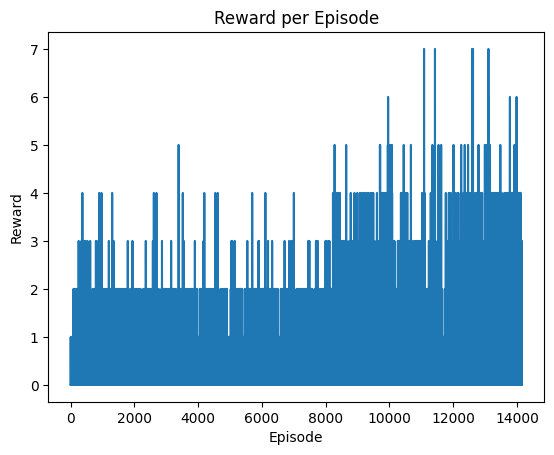

Episode 14150, Reward: 1.0
Episode 14160, Reward: 0.0
Episode 14170, Reward: 0.0
Episode 14180, Reward: 4.0
Episode 14190, Reward: 0.0
Episode 14200, Reward: 1.0
Episode 14210, Reward: 2.0
Episode 14220, Reward: 3.0
Episode 14230, Reward: 0.0
Episode 14240, Reward: 0.0
Episode 14250, Reward: 0.0
Episode 14260, Reward: 0.0
Episode 14270, Reward: 1.0
Episode 14280, Reward: 5.0
Episode 14290, Reward: 0.0
Episode 14300, Reward: 4.0
Episode 14310, Reward: 0.0


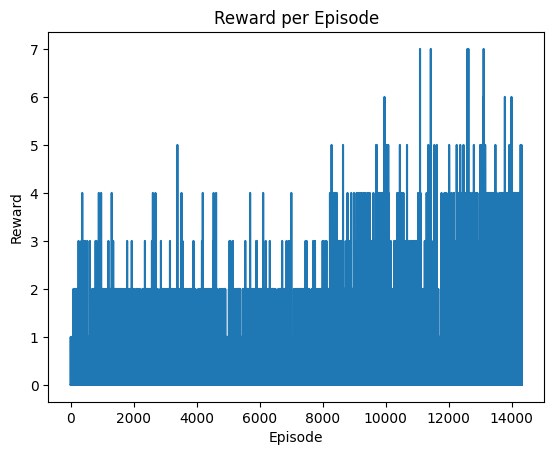

Episode 14320, Reward: 1.0
Episode 14330, Reward: 0.0
Episode 14340, Reward: 1.0
Episode 14350, Reward: 2.0
Episode 14360, Reward: 0.0
Episode 14370, Reward: 4.0
Episode 14380, Reward: 2.0
Episode 14390, Reward: 3.0
Episode 14400, Reward: 1.0
Episode 14410, Reward: 0.0
Episode 14420, Reward: 4.0
Episode 14430, Reward: 0.0
Episode 14440, Reward: 0.0
Episode 14450, Reward: 0.0
Episode 14460, Reward: 0.0
Episode 14470, Reward: 0.0
Episode 14480, Reward: 3.0


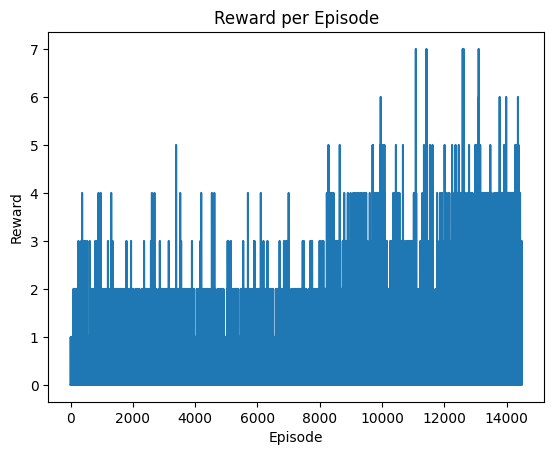

Episode 14490, Reward: 0.0
Episode 14500, Reward: 0.0
Episode 14510, Reward: 0.0
Episode 14520, Reward: 0.0
Episode 14530, Reward: 0.0
Episode 14540, Reward: 0.0
Episode 14550, Reward: 0.0
Episode 14560, Reward: 0.0
Episode 14570, Reward: 0.0
Episode 14580, Reward: 0.0
Episode 14590, Reward: 3.0
Episode 14600, Reward: 1.0
Episode 14610, Reward: 1.0
Episode 14620, Reward: 1.0
Episode 14630, Reward: 1.0
Episode 14640, Reward: 0.0
Episode 14650, Reward: 0.0
Episode 14660, Reward: 0.0
Episode 14670, Reward: 1.0
Episode 14680, Reward: 3.0
Episode 14690, Reward: 0.0


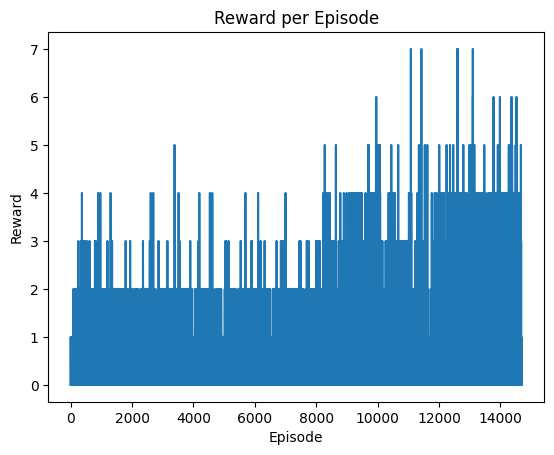

Episode 14700, Reward: 0.0
Episode 14710, Reward: 0.0
Episode 14720, Reward: 3.0
Episode 14730, Reward: 2.0
Episode 14740, Reward: 0.0
Episode 14750, Reward: 0.0
Episode 14760, Reward: 0.0
Episode 14770, Reward: 4.0
Episode 14780, Reward: 0.0
Episode 14790, Reward: 1.0
Episode 14800, Reward: 0.0
Episode 14810, Reward: 0.0
Episode 14820, Reward: 0.0
Episode 14830, Reward: 0.0
Episode 14840, Reward: 1.0
Episode 14850, Reward: 0.0
Episode 14860, Reward: 0.0


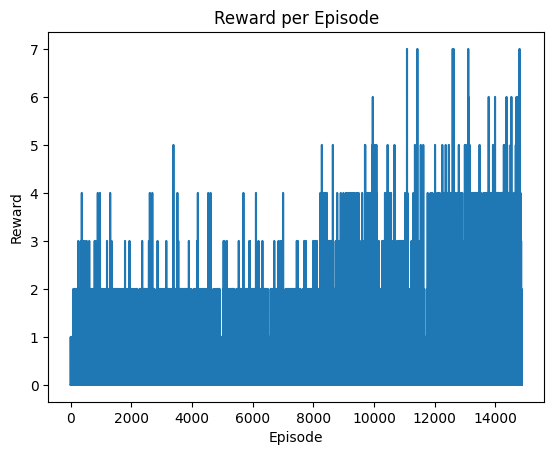

Episode 14870, Reward: 1.0
Episode 14880, Reward: 0.0
Episode 14890, Reward: 0.0
Episode 14900, Reward: 0.0
Episode 14910, Reward: 3.0
Episode 14920, Reward: 0.0
Episode 14930, Reward: 4.0
Episode 14940, Reward: 1.0
Episode 14950, Reward: 0.0
Episode 14960, Reward: 1.0
Episode 14970, Reward: 0.0
Episode 14980, Reward: 0.0
Episode 14990, Reward: 0.0
Episode 15000, Reward: 1.0
Episode 15010, Reward: 0.0
Episode 15020, Reward: 0.0


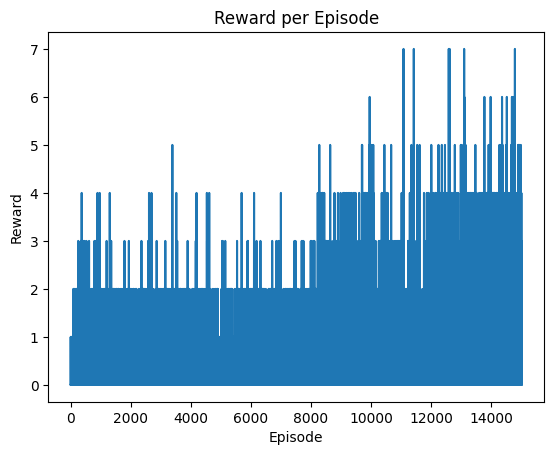

Episode 15030, Reward: 3.0
Episode 15040, Reward: 4.0
Episode 15050, Reward: 0.0
Episode 15060, Reward: 1.0
Episode 15070, Reward: 0.0
Episode 15080, Reward: 0.0
Episode 15090, Reward: 1.0
Episode 15100, Reward: 2.0
Episode 15110, Reward: 0.0
Episode 15120, Reward: 0.0
Episode 15130, Reward: 0.0
Episode 15140, Reward: 1.0
Episode 15150, Reward: 1.0
Episode 15160, Reward: 9.0


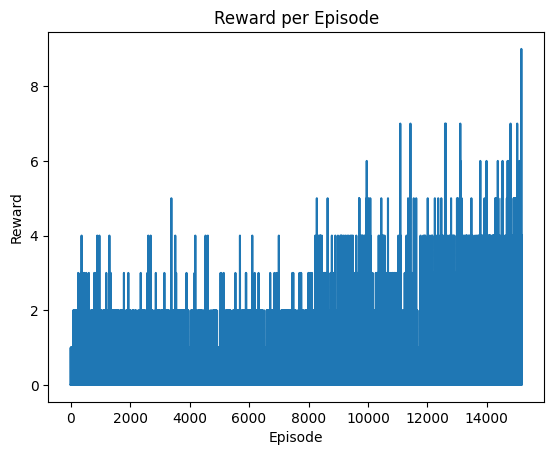

Episode 15170, Reward: 1.0
Episode 15180, Reward: 4.0
Episode 15190, Reward: 0.0
Episode 15200, Reward: 1.0
Episode 15210, Reward: 0.0
Episode 15220, Reward: 1.0
Episode 15230, Reward: 0.0
Episode 15240, Reward: 1.0
Episode 15250, Reward: 4.0
Episode 15260, Reward: 0.0
Episode 15270, Reward: 1.0
Episode 15280, Reward: 4.0
Episode 15290, Reward: 4.0


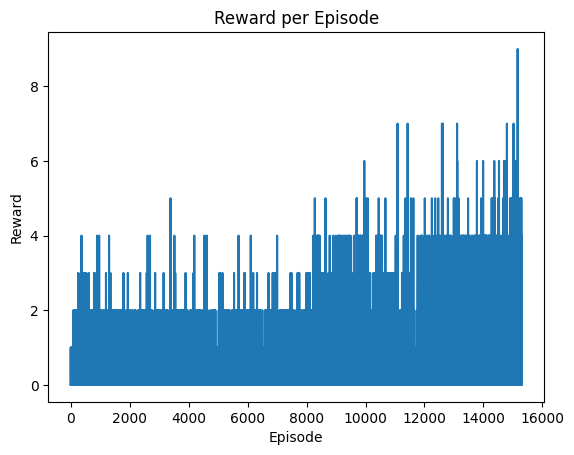

Episode 15300, Reward: 0.0
Episode 15310, Reward: 0.0
Episode 15320, Reward: 1.0
Episode 15330, Reward: 1.0
Episode 15340, Reward: 1.0
Episode 15350, Reward: 6.0
Episode 15360, Reward: 0.0
Episode 15370, Reward: 0.0
Episode 15380, Reward: 3.0
Episode 15390, Reward: 6.0
Episode 15400, Reward: 1.0
Episode 15410, Reward: 0.0
Episode 15420, Reward: 5.0
Episode 15430, Reward: 7.0
Episode 15440, Reward: 1.0


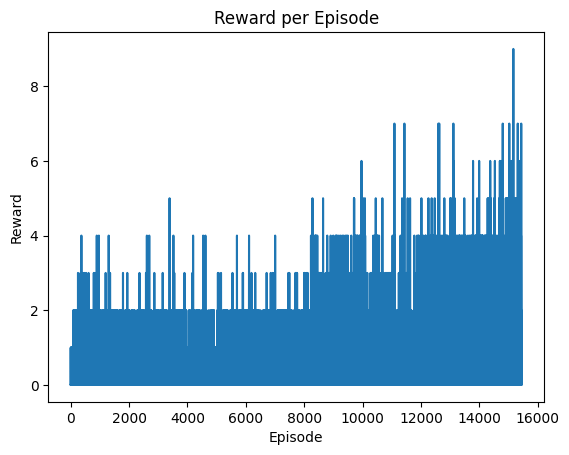

Episode 15450, Reward: 1.0
Episode 15460, Reward: 7.0
Episode 15470, Reward: 1.0
Episode 15480, Reward: 1.0
Episode 15490, Reward: 1.0
Episode 15500, Reward: 0.0
Episode 15510, Reward: 0.0
Episode 15520, Reward: 2.0
Episode 15530, Reward: 4.0
Episode 15540, Reward: 1.0
Episode 15550, Reward: 1.0
Episode 15560, Reward: 0.0
Episode 15570, Reward: 1.0


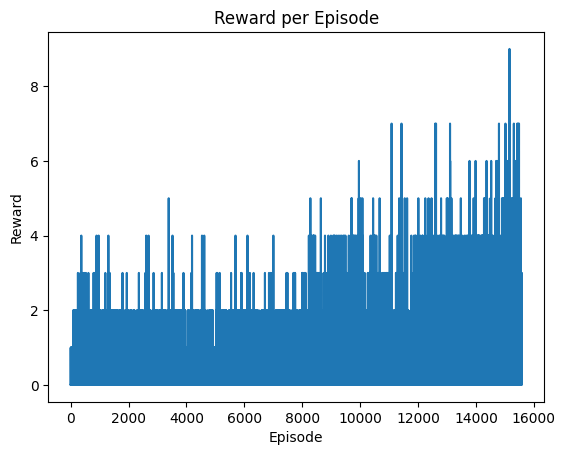

Episode 15580, Reward: 6.0
Episode 15590, Reward: 4.0
Episode 15600, Reward: 2.0
Episode 15610, Reward: 3.0
Episode 15620, Reward: 0.0
Episode 15630, Reward: 0.0
Episode 15640, Reward: 0.0
Episode 15650, Reward: 0.0
Episode 15660, Reward: 3.0
Episode 15670, Reward: 2.0
Episode 15680, Reward: 4.0
Episode 15690, Reward: 0.0
Episode 15700, Reward: 4.0


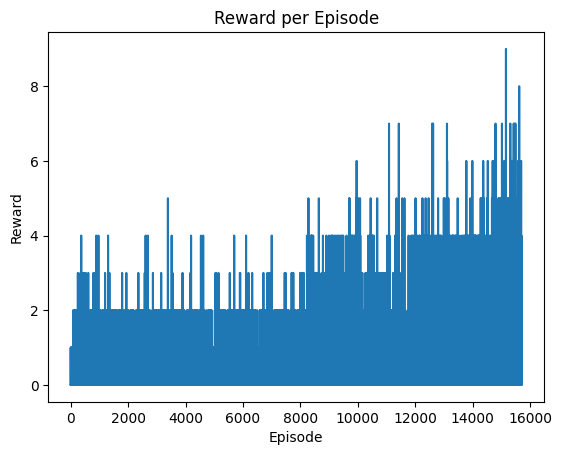

Episode 15710, Reward: 0.0
Episode 15720, Reward: 2.0
Episode 15730, Reward: 0.0
Episode 15740, Reward: 0.0
Episode 15750, Reward: 1.0
Episode 15760, Reward: 1.0
Episode 15770, Reward: 3.0
Episode 15780, Reward: 0.0
Episode 15790, Reward: 4.0
Episode 15800, Reward: 0.0
Episode 15810, Reward: 0.0
Episode 15820, Reward: 5.0


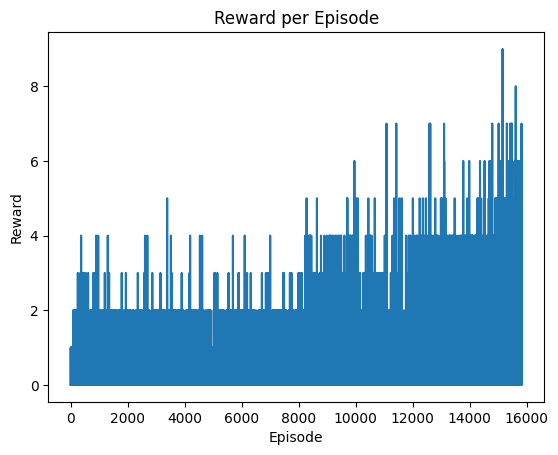

Episode 15830, Reward: 1.0
Episode 15840, Reward: 0.0
Episode 15850, Reward: 1.0
Episode 15860, Reward: 2.0
Episode 15870, Reward: 0.0
Episode 15880, Reward: 4.0
Episode 15890, Reward: 5.0
Episode 15900, Reward: 3.0
Episode 15910, Reward: 0.0
Episode 15920, Reward: 0.0
Episode 15930, Reward: 1.0


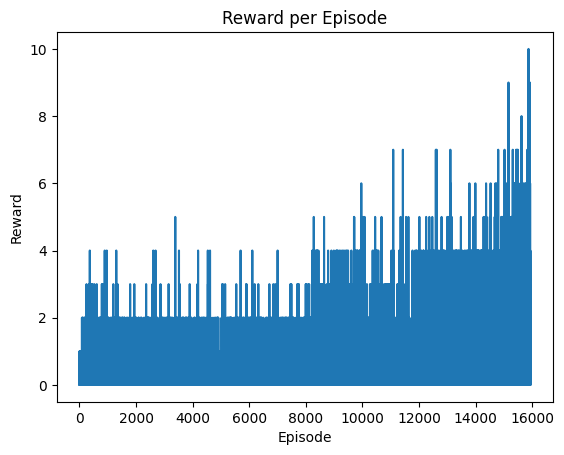

Episode 15940, Reward: 2.0
Episode 15950, Reward: 2.0
Episode 15960, Reward: 4.0
Episode 15970, Reward: 4.0
Episode 15980, Reward: 5.0
Episode 15990, Reward: 0.0
Episode 16000, Reward: 4.0
Episode 16010, Reward: 0.0
Episode 16020, Reward: 2.0
Episode 16030, Reward: 4.0
Episode 16040, Reward: 4.0


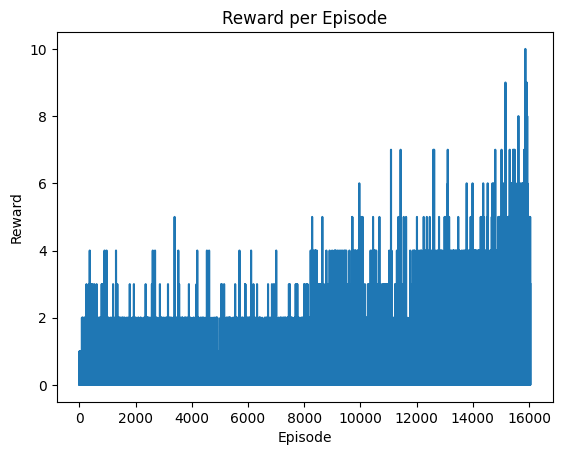

Episode 16050, Reward: 7.0
Episode 16060, Reward: 3.0
Episode 16070, Reward: 0.0
Episode 16080, Reward: 2.0
Episode 16090, Reward: 0.0
Episode 16100, Reward: 4.0
Episode 16110, Reward: 1.0
Episode 16120, Reward: 2.0
Episode 16130, Reward: 1.0
Episode 16140, Reward: 5.0
Episode 16150, Reward: 2.0
Episode 16160, Reward: 0.0
Episode 16170, Reward: 0.0


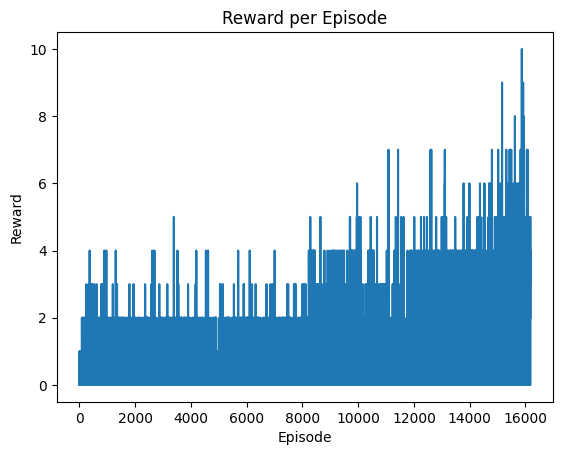

Episode 16180, Reward: 2.0
Episode 16190, Reward: 0.0
Episode 16200, Reward: 4.0
Episode 16210, Reward: 2.0
Episode 16220, Reward: 2.0
Episode 16230, Reward: 1.0
Episode 16240, Reward: 4.0
Episode 16250, Reward: 3.0
Episode 16260, Reward: 4.0
Episode 16270, Reward: 5.0
Episode 16280, Reward: 0.0
Episode 16290, Reward: 3.0
Episode 16300, Reward: 1.0


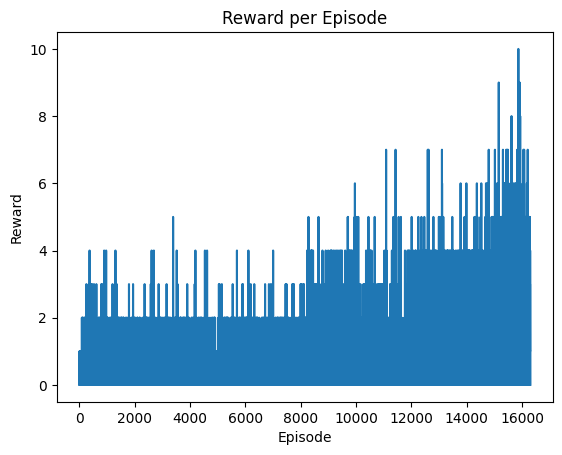

Episode 16310, Reward: 2.0
Episode 16320, Reward: 1.0
Episode 16330, Reward: 2.0
Episode 16340, Reward: 4.0
Episode 16350, Reward: 4.0
Episode 16360, Reward: 0.0
Episode 16370, Reward: 4.0
Episode 16380, Reward: 1.0
Episode 16390, Reward: 5.0


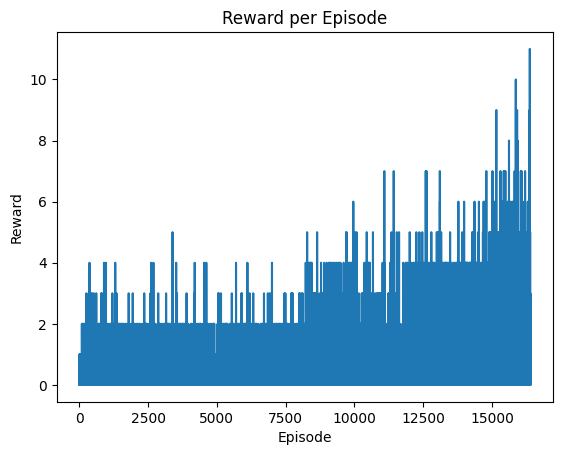

Episode 16400, Reward: 3.0
Episode 16410, Reward: 0.0
Episode 16420, Reward: 0.0
Episode 16430, Reward: 0.0
Episode 16440, Reward: 1.0
Episode 16450, Reward: 1.0
Episode 16460, Reward: 4.0
Episode 16470, Reward: 4.0
Episode 16480, Reward: 0.0
Episode 16490, Reward: 1.0


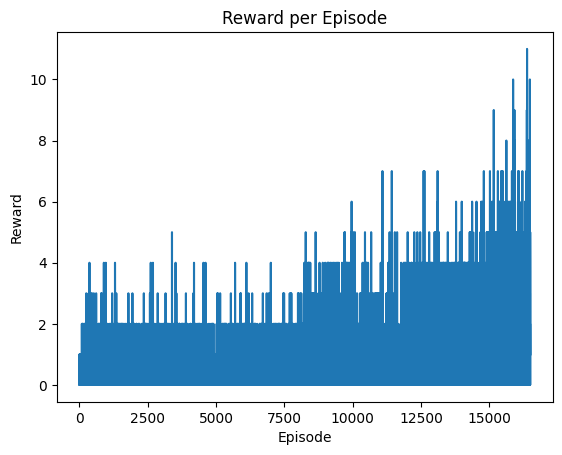

Episode 16500, Reward: 0.0
Episode 16510, Reward: 3.0
Episode 16520, Reward: 3.0
Episode 16530, Reward: 1.0
Episode 16540, Reward: 1.0
Episode 16550, Reward: 1.0
Episode 16560, Reward: 0.0
Episode 16570, Reward: 0.0
Episode 16580, Reward: 1.0
Episode 16590, Reward: 1.0
Episode 16600, Reward: 0.0
Episode 16610, Reward: 4.0
Episode 16620, Reward: 1.0


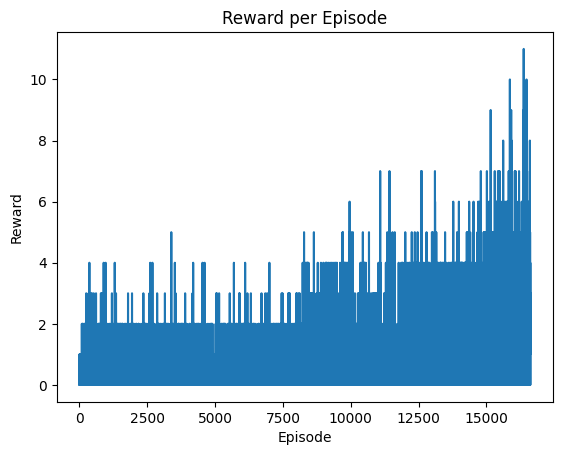

Episode 16630, Reward: 5.0
Episode 16640, Reward: 1.0
Episode 16650, Reward: 6.0
Episode 16660, Reward: 1.0
Episode 16670, Reward: 1.0
Episode 16680, Reward: 2.0
Episode 16690, Reward: 2.0
Episode 16700, Reward: 5.0
Episode 16710, Reward: 5.0
Episode 16720, Reward: 0.0


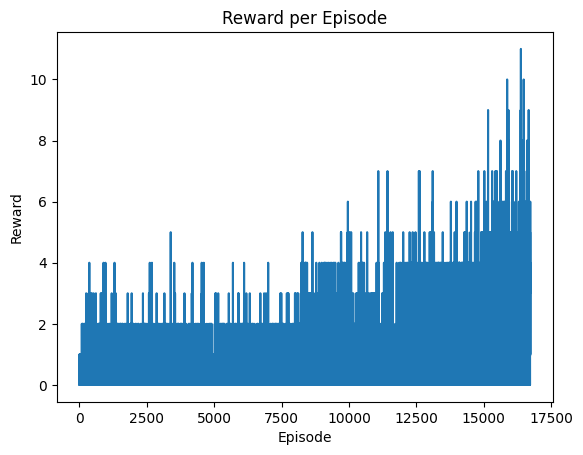

Episode 16730, Reward: 10.0
Episode 16740, Reward: 6.0
Episode 16750, Reward: 4.0
Episode 16760, Reward: 1.0
Episode 16770, Reward: 4.0
Episode 16780, Reward: 2.0
Episode 16790, Reward: 3.0
Episode 16800, Reward: 1.0
Episode 16810, Reward: 5.0
Episode 16820, Reward: 6.0
Episode 16830, Reward: 0.0


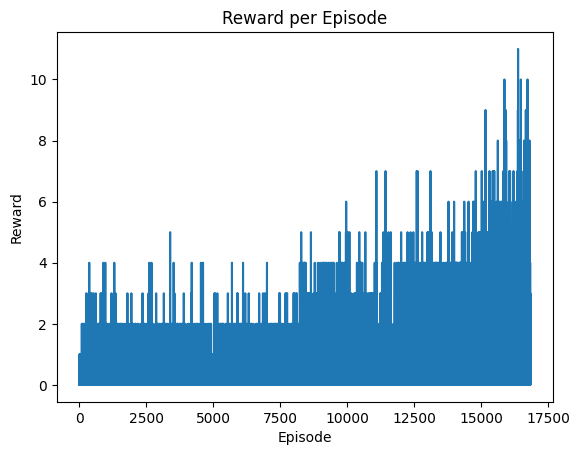

Episode 16840, Reward: 4.0
Episode 16850, Reward: 0.0
Episode 16860, Reward: 4.0
Episode 16870, Reward: 4.0
Episode 16880, Reward: 0.0
Episode 16890, Reward: 1.0
Episode 16900, Reward: 3.0
Episode 16910, Reward: 0.0
Episode 16920, Reward: 2.0
Episode 16930, Reward: 1.0


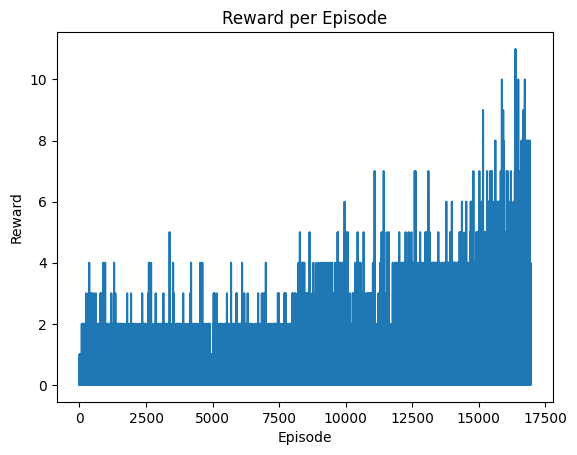

Episode 16940, Reward: 2.0
Episode 16950, Reward: 4.0
Episode 16960, Reward: 5.0
Episode 16970, Reward: 6.0
Episode 16980, Reward: 4.0
Episode 16990, Reward: 0.0
Episode 17000, Reward: 0.0
Episode 17010, Reward: 1.0
Episode 17020, Reward: 0.0
Episode 17030, Reward: 2.0
Episode 17040, Reward: 6.0


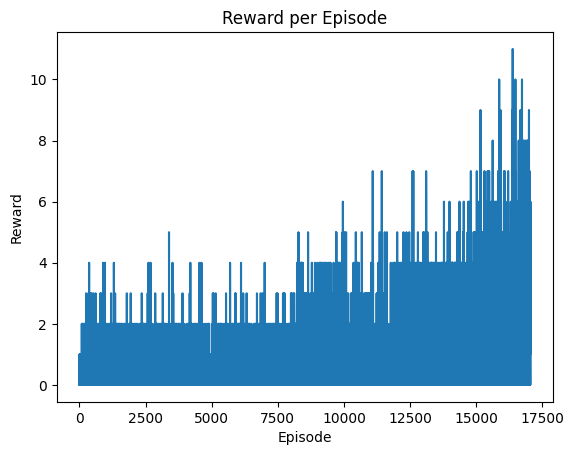

Episode 17050, Reward: 4.0
Episode 17060, Reward: 3.0
Episode 17070, Reward: 3.0
Episode 17080, Reward: 2.0
Episode 17090, Reward: 2.0
Episode 17100, Reward: 0.0
Episode 17110, Reward: 0.0
Episode 17120, Reward: 2.0
Episode 17130, Reward: 1.0
Episode 17140, Reward: 3.0
Episode 17150, Reward: 1.0


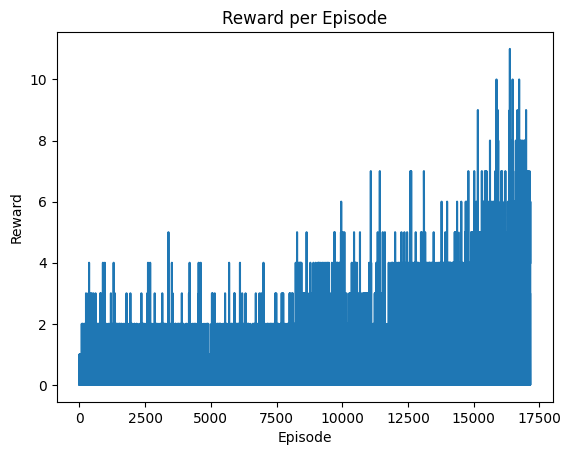

Episode 17160, Reward: 3.0
Episode 17170, Reward: 0.0
Episode 17180, Reward: 2.0
Episode 17190, Reward: 0.0
Episode 17200, Reward: 0.0
Episode 17210, Reward: 0.0
Episode 17220, Reward: 2.0
Episode 17230, Reward: 0.0
Episode 17240, Reward: 1.0
Episode 17250, Reward: 1.0
Episode 17260, Reward: 4.0


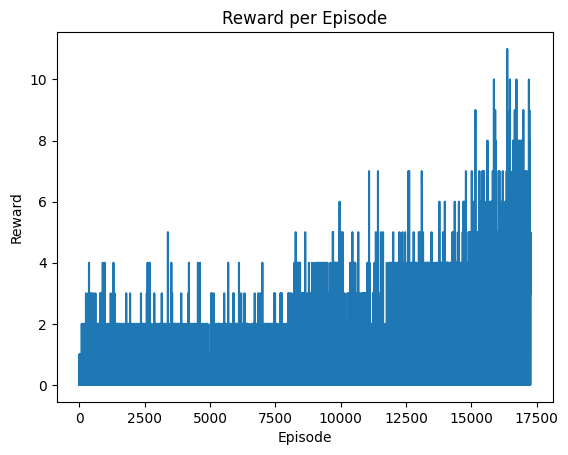

Episode 17270, Reward: 4.0
Episode 17280, Reward: 1.0
Episode 17290, Reward: 5.0
Episode 17300, Reward: 0.0
Episode 17310, Reward: 5.0
Episode 17320, Reward: 3.0
Episode 17330, Reward: 1.0
Episode 17340, Reward: 0.0
Episode 17350, Reward: 2.0
Episode 17360, Reward: 1.0


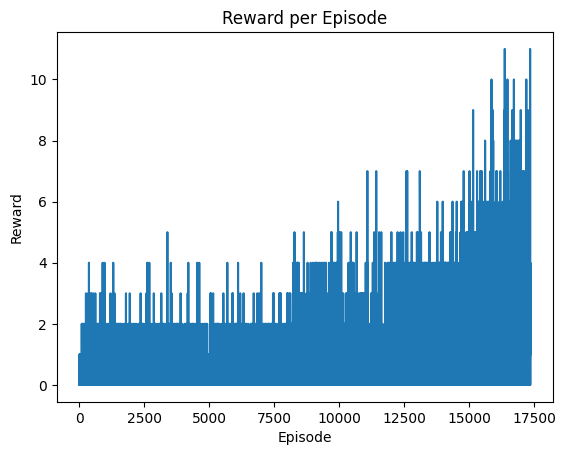

Episode 17370, Reward: 4.0
Episode 17380, Reward: 4.0
Episode 17390, Reward: 0.0
Episode 17400, Reward: 3.0
Episode 17410, Reward: 4.0
Episode 17420, Reward: 1.0
Episode 17430, Reward: 2.0
Episode 17440, Reward: 0.0
Episode 17450, Reward: 2.0
Episode 17460, Reward: 1.0


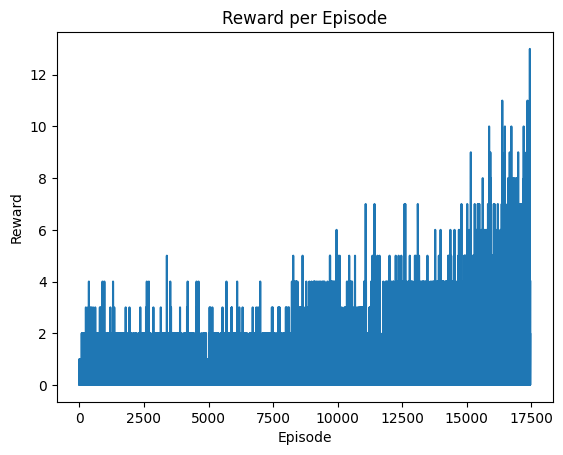

Episode 17470, Reward: 1.0
Episode 17480, Reward: 4.0
Episode 17490, Reward: 2.0
Episode 17500, Reward: 0.0
Episode 17510, Reward: 1.0
Episode 17520, Reward: 1.0
Episode 17530, Reward: 0.0
Episode 17540, Reward: 0.0
Episode 17550, Reward: 7.0
Episode 17560, Reward: 0.0


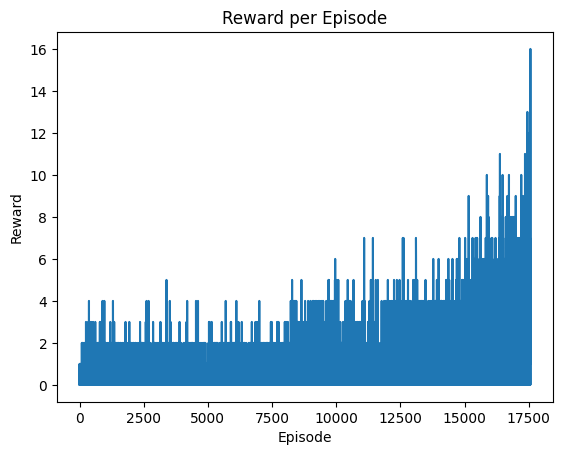

Episode 17570, Reward: 1.0
Episode 17580, Reward: 1.0
Episode 17590, Reward: 1.0
Episode 17600, Reward: 0.0
Episode 17610, Reward: 0.0
Episode 17620, Reward: 0.0
Episode 17630, Reward: 5.0
Episode 17640, Reward: 1.0
Episode 17650, Reward: 0.0
Episode 17660, Reward: 2.0


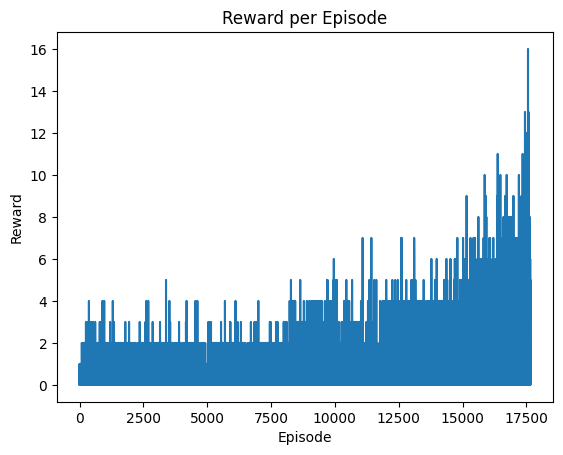

Episode 17670, Reward: 2.0
Episode 17680, Reward: 6.0
Episode 17690, Reward: 1.0
Episode 17700, Reward: 2.0
Episode 17710, Reward: 5.0
Episode 17720, Reward: 9.0
Episode 17730, Reward: 2.0
Episode 17740, Reward: 2.0
Episode 17750, Reward: 2.0


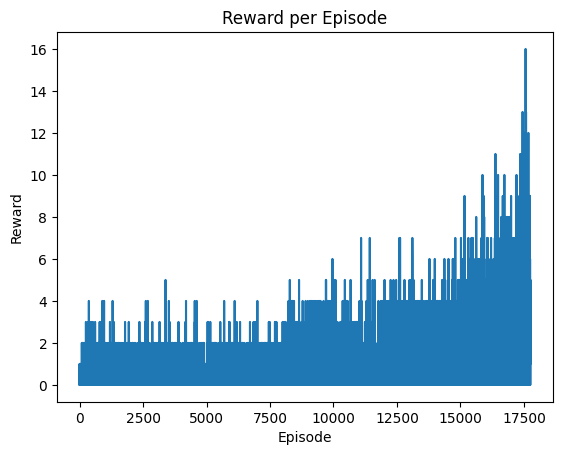

Episode 17760, Reward: 1.0
Episode 17770, Reward: 0.0
Episode 17780, Reward: 2.0
Episode 17790, Reward: 1.0
Episode 17800, Reward: 4.0
Episode 17810, Reward: 4.0
Episode 17820, Reward: 5.0
Episode 17830, Reward: 4.0
Episode 17840, Reward: 5.0
Episode 17850, Reward: 2.0


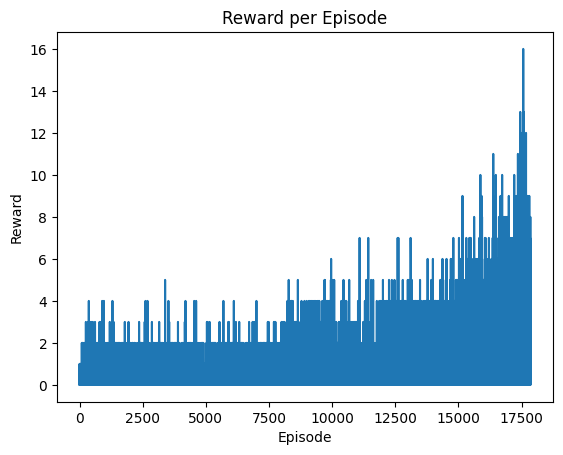

Episode 17860, Reward: 3.0
Episode 17870, Reward: 8.0
Episode 17880, Reward: 6.0
Episode 17890, Reward: 0.0
Episode 17900, Reward: 5.0
Episode 17910, Reward: 9.0
Episode 17920, Reward: 2.0
Episode 17930, Reward: 2.0
Episode 17940, Reward: 6.0


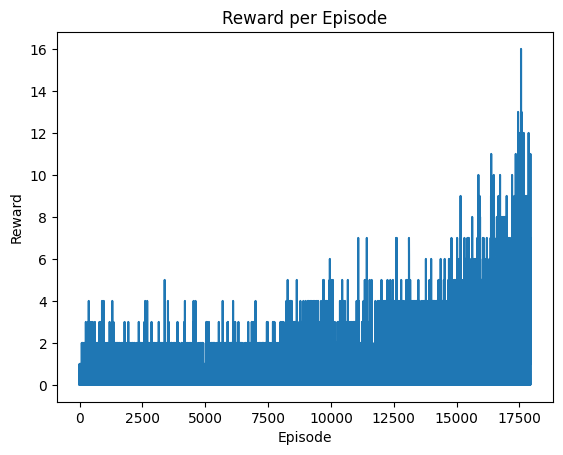

Episode 17950, Reward: 6.0
Episode 17960, Reward: 10.0
Episode 17970, Reward: 7.0
Episode 17980, Reward: 3.0
Episode 17990, Reward: 2.0
Episode 18000, Reward: 10.0
Episode 18010, Reward: 4.0
Episode 18020, Reward: 0.0


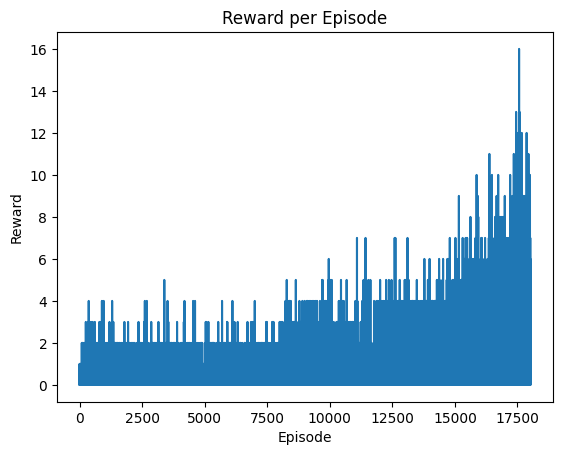

Episode 18030, Reward: 4.0
Episode 18040, Reward: 0.0
Episode 18050, Reward: 7.0
Episode 18060, Reward: 1.0
Episode 18070, Reward: 2.0
Episode 18080, Reward: 4.0
Episode 18090, Reward: 6.0
Episode 18100, Reward: 1.0


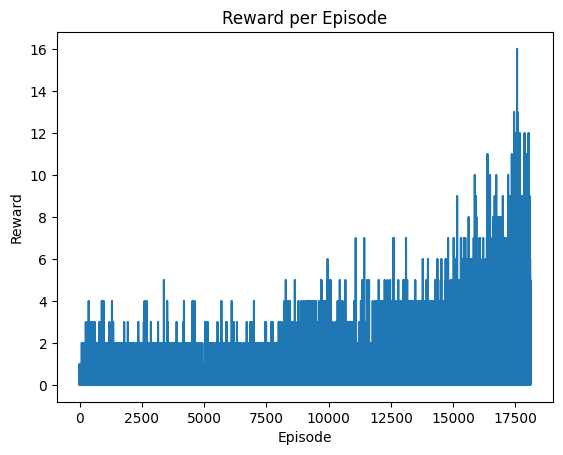

Episode 18110, Reward: 1.0
Episode 18120, Reward: 4.0
Episode 18130, Reward: 4.0
Episode 18140, Reward: 7.0
Episode 18150, Reward: 7.0
Episode 18160, Reward: 11.0
Episode 18170, Reward: 7.0


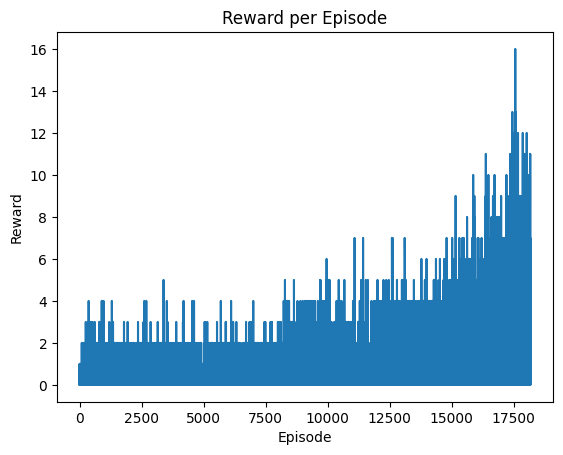

Episode 18180, Reward: 0.0
Episode 18190, Reward: 1.0
Episode 18200, Reward: 0.0
Episode 18210, Reward: 1.0
Episode 18220, Reward: 1.0
Episode 18230, Reward: 1.0
Episode 18240, Reward: 4.0
Episode 18250, Reward: 4.0
Episode 18260, Reward: 0.0


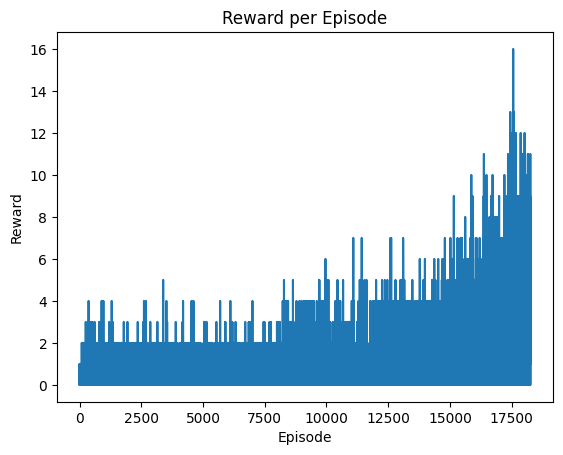

Episode 18270, Reward: 3.0
Episode 18280, Reward: 3.0
Episode 18290, Reward: 4.0
Episode 18300, Reward: 6.0
Episode 18310, Reward: 2.0
Episode 18320, Reward: 3.0
Episode 18330, Reward: 5.0
Episode 18340, Reward: 5.0


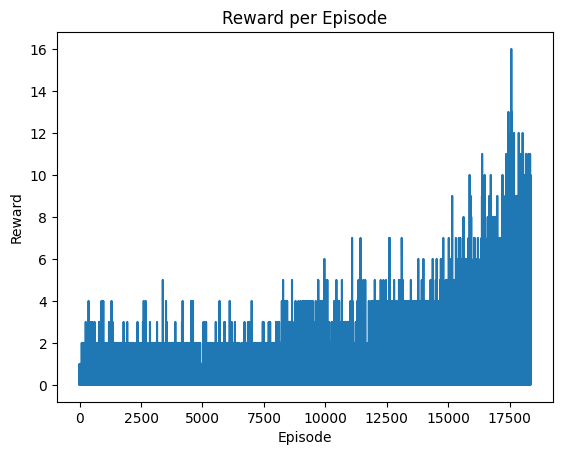

Episode 18350, Reward: 0.0
Episode 18360, Reward: 6.0
Episode 18370, Reward: 4.0
Episode 18380, Reward: 9.0
Episode 18390, Reward: 6.0
Episode 18400, Reward: 2.0
Episode 18410, Reward: 0.0


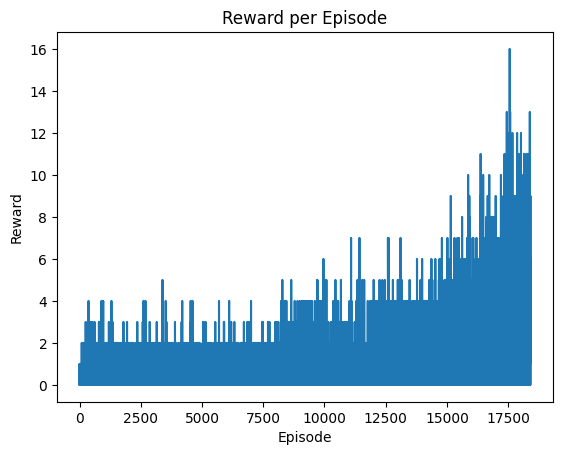

Episode 18420, Reward: 5.0
Episode 18430, Reward: 6.0
Episode 18440, Reward: 2.0
Episode 18450, Reward: 2.0
Episode 18460, Reward: 1.0
Episode 18470, Reward: 3.0
Episode 18480, Reward: 5.0
Episode 18490, Reward: 4.0


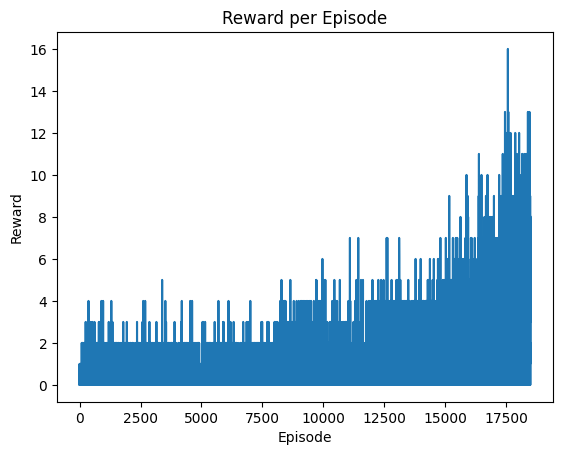

Episode 18500, Reward: 1.0
Episode 18510, Reward: 4.0
Episode 18520, Reward: 4.0
Episode 18530, Reward: 7.0
Episode 18540, Reward: 4.0
Episode 18550, Reward: 9.0


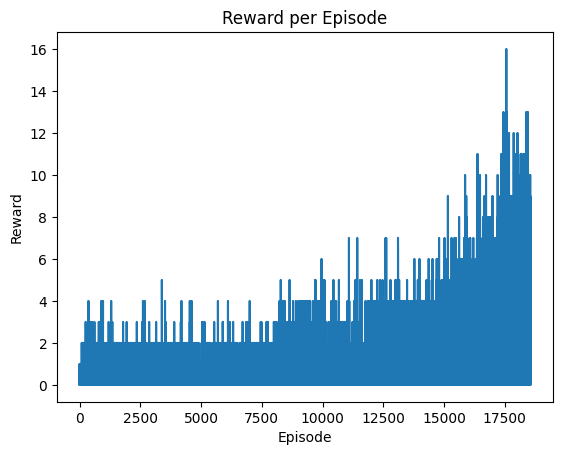

Episode 18560, Reward: 8.0
Episode 18570, Reward: 4.0
Episode 18580, Reward: 6.0
Episode 18590, Reward: 7.0
Episode 18600, Reward: 3.0
Episode 18610, Reward: 1.0
Episode 18620, Reward: 4.0


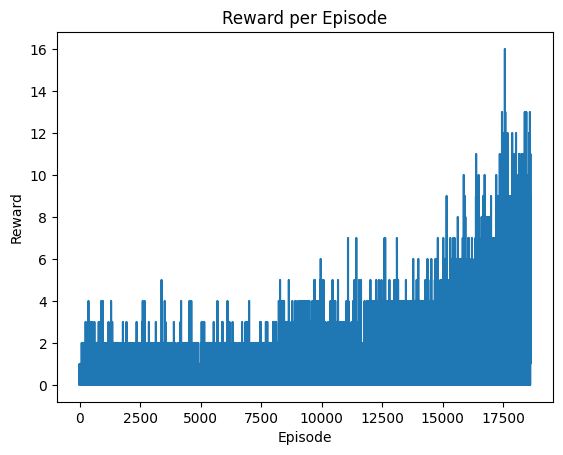

Episode 18630, Reward: 1.0
Episode 18640, Reward: 2.0
Episode 18650, Reward: 5.0
Episode 18660, Reward: 5.0
Episode 18670, Reward: 5.0
Episode 18680, Reward: 4.0
Episode 18690, Reward: 3.0
Episode 18700, Reward: 3.0
Episode 18710, Reward: 1.0


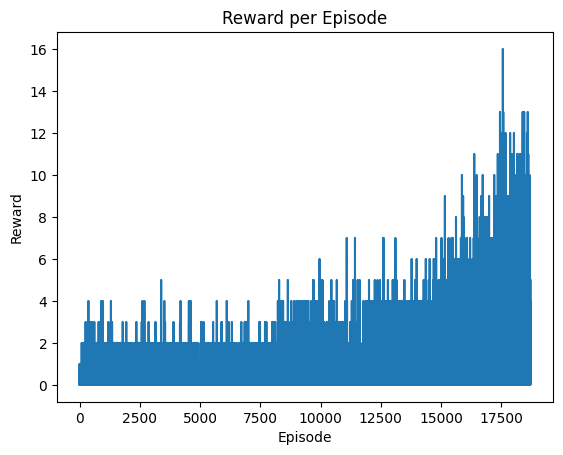

Episode 18720, Reward: 6.0
Episode 18730, Reward: 8.0
Episode 18740, Reward: 5.0
Episode 18750, Reward: 1.0
Episode 18760, Reward: 5.0
Episode 18770, Reward: 4.0


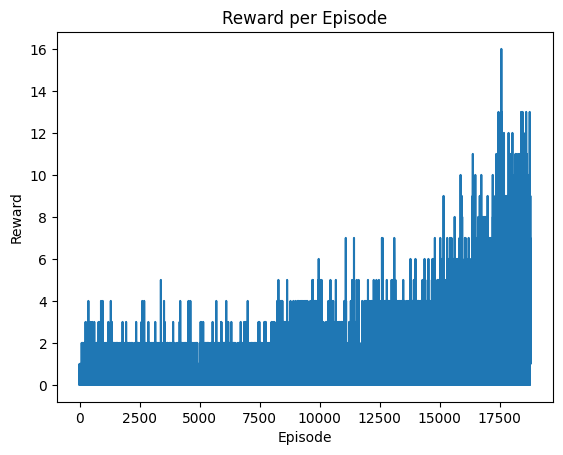

Episode 18780, Reward: 6.0
Episode 18790, Reward: 0.0
Episode 18800, Reward: 2.0
Episode 18810, Reward: 2.0
Episode 18820, Reward: 5.0
Episode 18830, Reward: 4.0


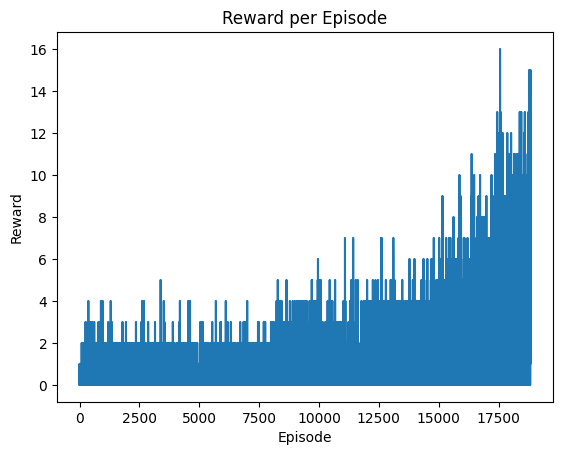

Episode 18840, Reward: 11.0
Episode 18850, Reward: 1.0
Episode 18860, Reward: 1.0
Episode 18870, Reward: 2.0
Episode 18880, Reward: 7.0
Episode 18890, Reward: 9.0
Episode 18900, Reward: 3.0


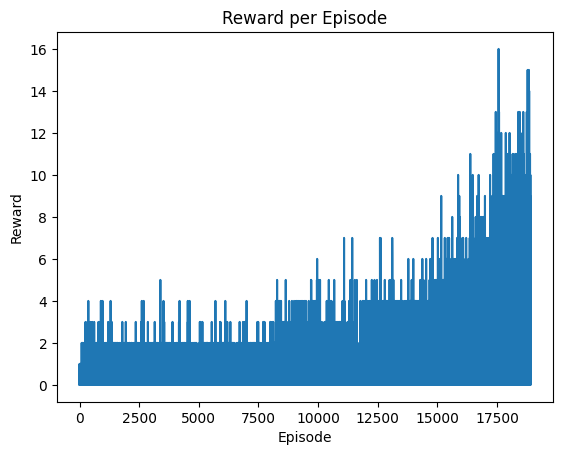

Episode 18910, Reward: 9.0
Episode 18920, Reward: 1.0
Episode 18930, Reward: 6.0
Episode 18940, Reward: 6.0
Episode 18950, Reward: 1.0


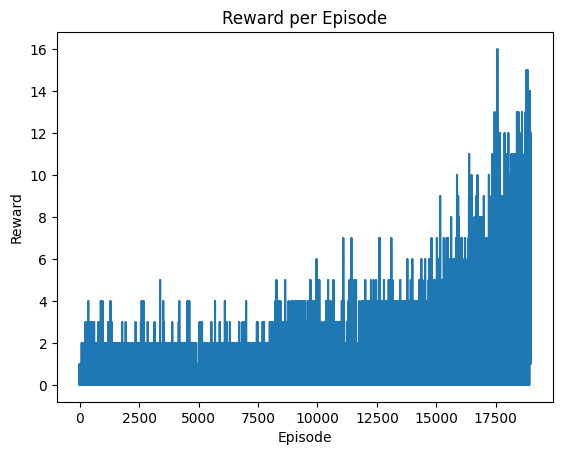

Episode 18960, Reward: 12.0
Episode 18970, Reward: 6.0
Episode 18980, Reward: 1.0
Episode 18990, Reward: 5.0
Episode 19000, Reward: 2.0
Episode 19010, Reward: 10.0


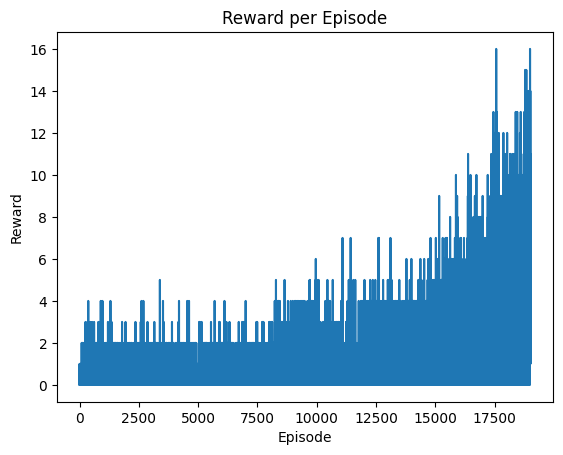

Episode 19020, Reward: 3.0
Episode 19030, Reward: 4.0
Episode 19040, Reward: 8.0
Episode 19050, Reward: 7.0
Episode 19060, Reward: 12.0


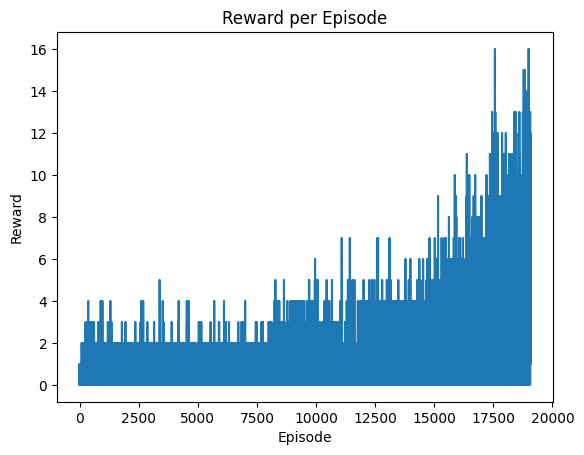

Episode 19070, Reward: 6.0
Episode 19080, Reward: 7.0
Episode 19090, Reward: 7.0
Episode 19100, Reward: 5.0
Episode 19110, Reward: 7.0
Episode 19120, Reward: 1.0


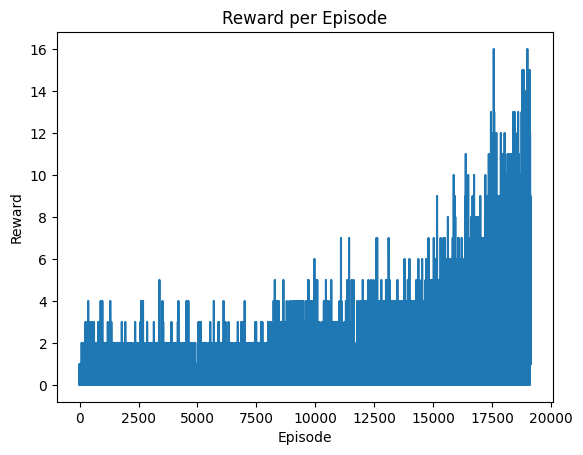

Episode 19130, Reward: 21.0
Episode 19140, Reward: 14.0
Episode 19150, Reward: 4.0
Episode 19160, Reward: 12.0
Episode 19170, Reward: 3.0


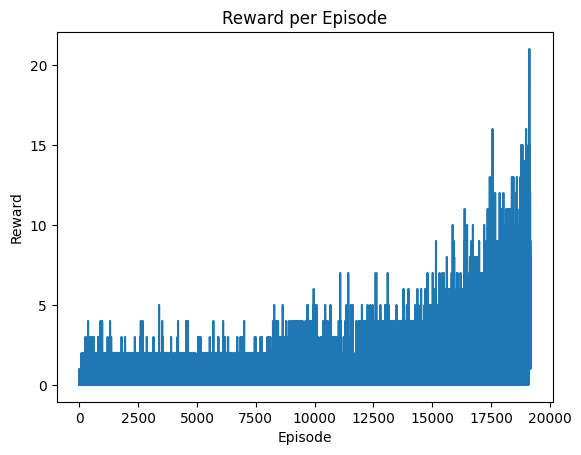

Episode 19180, Reward: 1.0
Episode 19190, Reward: 9.0
Episode 19200, Reward: 15.0
Episode 19210, Reward: 8.0
Episode 19220, Reward: 6.0


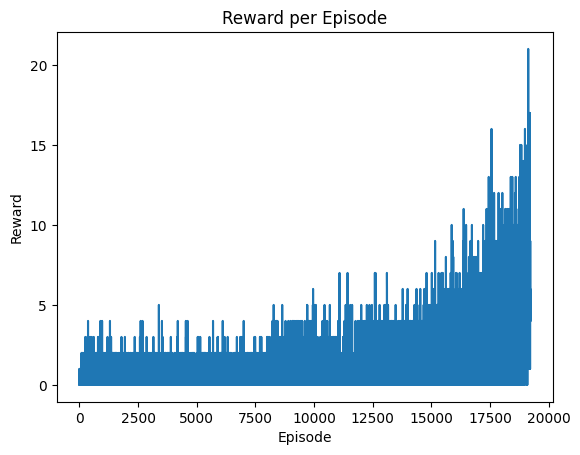

Episode 19230, Reward: 2.0
Episode 19240, Reward: 3.0
Episode 19250, Reward: 7.0
Episode 19260, Reward: 9.0


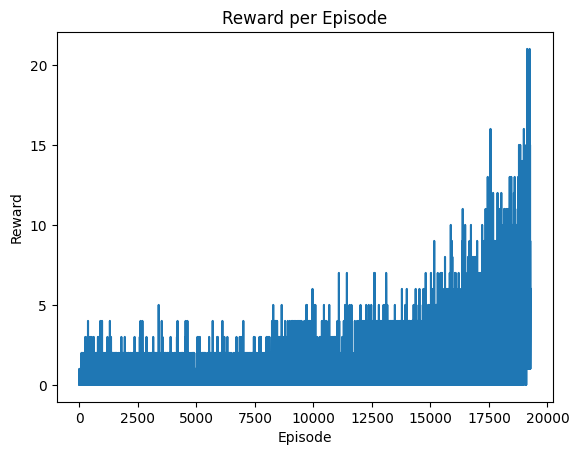

Episode 19270, Reward: 10.0
Episode 19280, Reward: 8.0
Episode 19290, Reward: 5.0
Episode 19300, Reward: 12.0
Episode 19310, Reward: 1.0


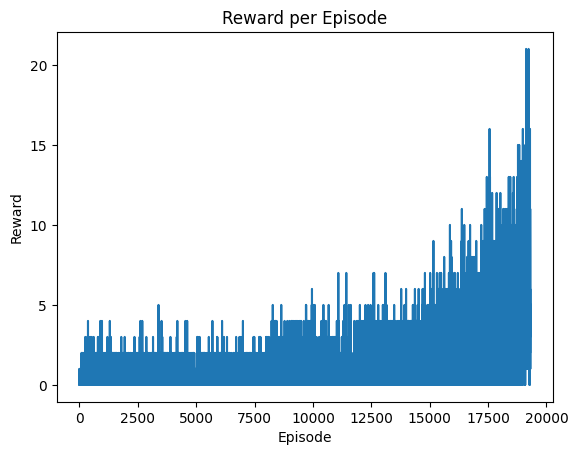

Episode 19320, Reward: 10.0
Episode 19330, Reward: 5.0
Episode 19340, Reward: 12.0
Episode 19350, Reward: 4.0


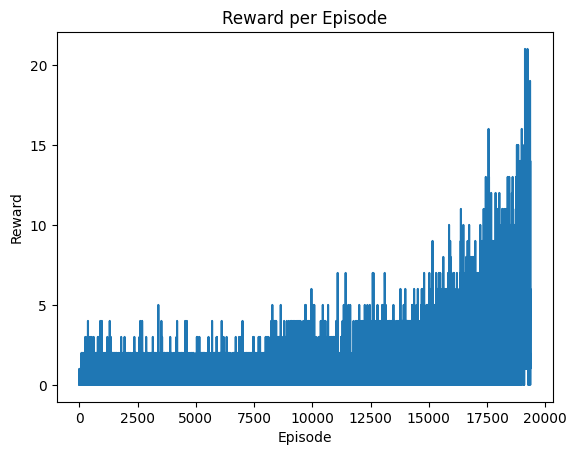

Episode 19360, Reward: 11.0
Episode 19370, Reward: 14.0
Episode 19380, Reward: 8.0
Episode 19390, Reward: 0.0
Episode 19400, Reward: 12.0


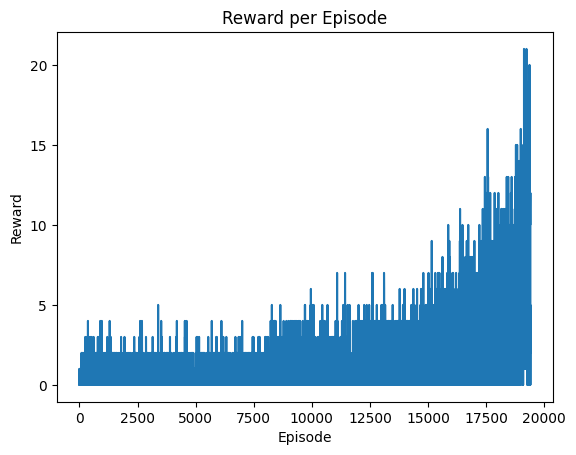

Episode 19410, Reward: 11.0
Episode 19420, Reward: 11.0
Episode 19430, Reward: 4.0
Episode 19440, Reward: 1.0


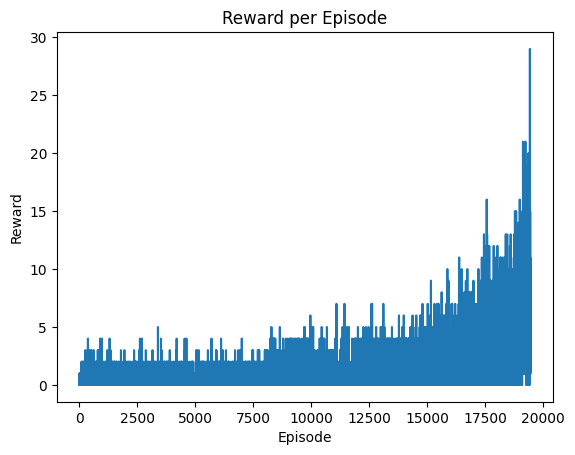

Episode 19450, Reward: 4.0
Episode 19460, Reward: 14.0
Episode 19470, Reward: 7.0
Episode 19480, Reward: 7.0
Episode 19490, Reward: 3.0
Episode 19500, Reward: 5.0


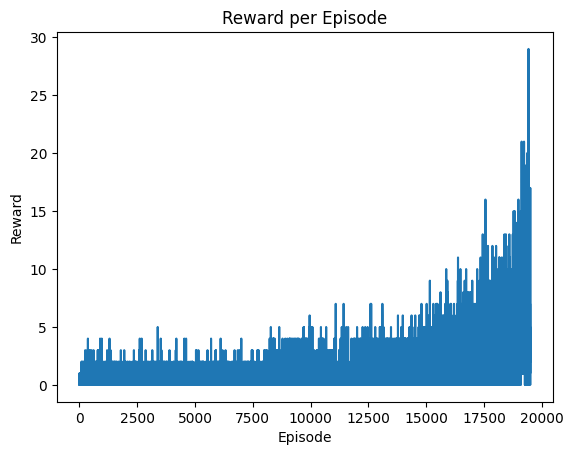

Episode 19510, Reward: 13.0
Episode 19520, Reward: 5.0
Episode 19530, Reward: 4.0
Episode 19540, Reward: 11.0
Episode 19550, Reward: 1.0


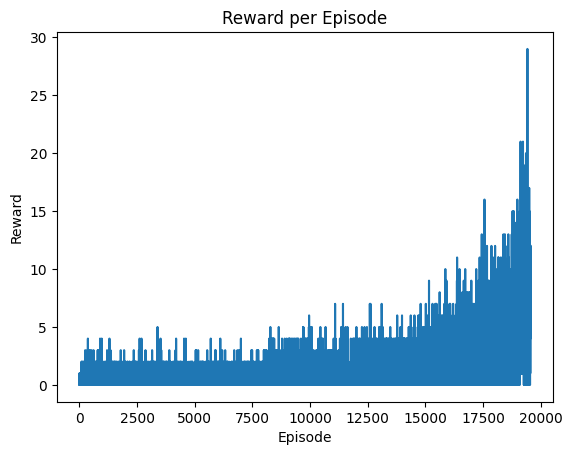

Episode 19560, Reward: 4.0
Episode 19570, Reward: 2.0
Episode 19580, Reward: 4.0
Episode 19590, Reward: 1.0
Episode 19600, Reward: 4.0


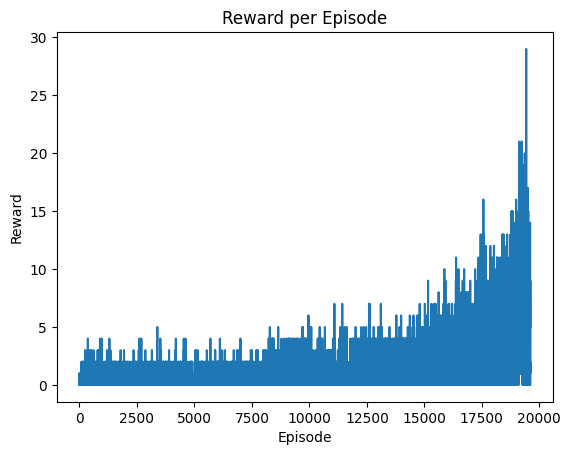

Episode 19610, Reward: 7.0
Episode 19620, Reward: 5.0
Episode 19630, Reward: 10.0
Episode 19640, Reward: 6.0
Episode 19650, Reward: 1.0
Episode 19660, Reward: 5.0


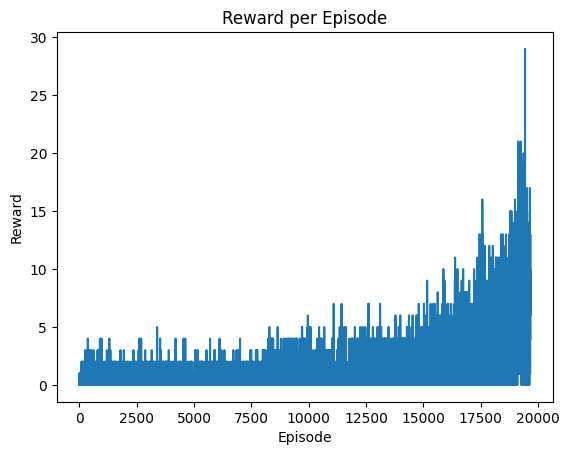

Episode 19670, Reward: 7.0
Episode 19680, Reward: 1.0
Episode 19690, Reward: 6.0
Episode 19700, Reward: 21.0
Episode 19710, Reward: 1.0


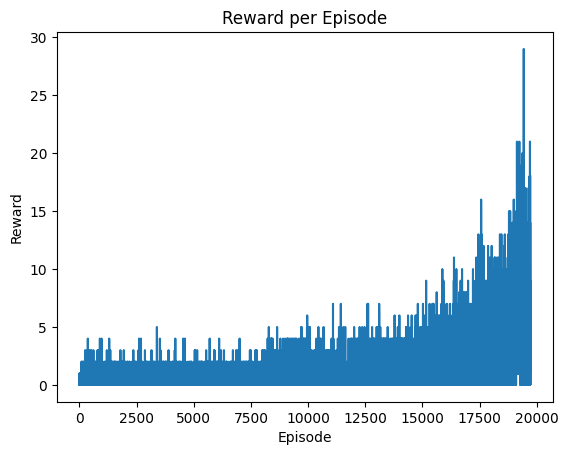

Episode 19720, Reward: 11.0
Episode 19730, Reward: 5.0
Episode 19740, Reward: 4.0
Episode 19750, Reward: 7.0
Episode 19760, Reward: 9.0


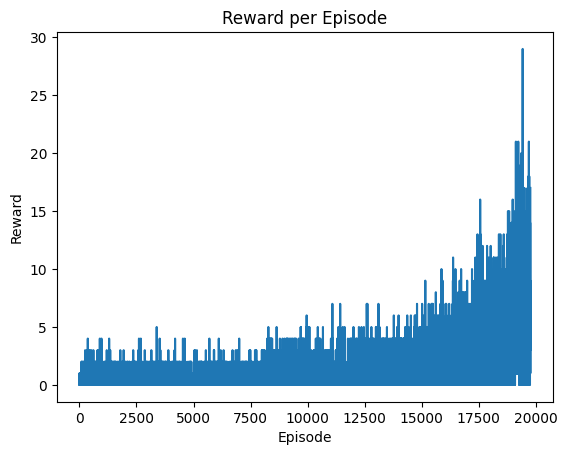

Episode 19770, Reward: 5.0
Episode 19780, Reward: 9.0
Episode 19790, Reward: 4.0
Episode 19800, Reward: 19.0
Episode 19810, Reward: 10.0


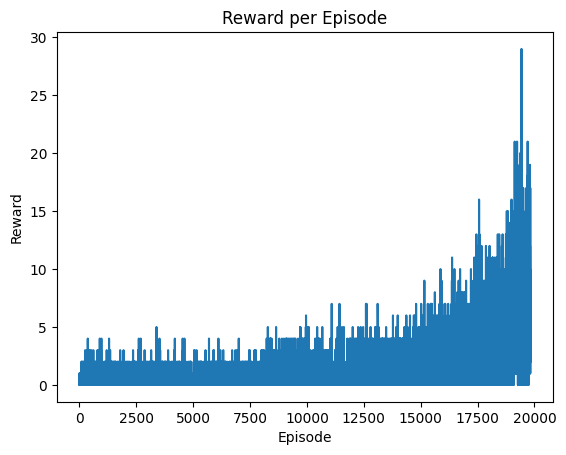

Episode 19820, Reward: 11.0
Episode 19830, Reward: 15.0
Episode 19840, Reward: 5.0
Episode 19850, Reward: 7.0
Episode 19860, Reward: 5.0
Episode 19870, Reward: 13.0


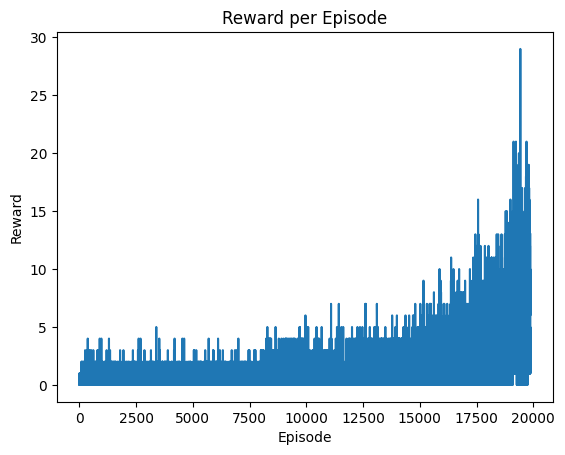

Episode 19880, Reward: 14.0
Episode 19890, Reward: 4.0
Episode 19900, Reward: 3.0
Episode 19910, Reward: 6.0


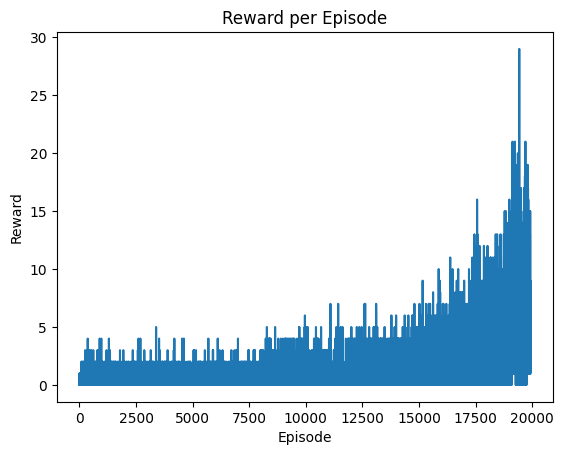

Episode 19920, Reward: 0.0
Episode 19930, Reward: 7.0
Episode 19940, Reward: 2.0
Episode 19950, Reward: 6.0
Episode 19960, Reward: 11.0


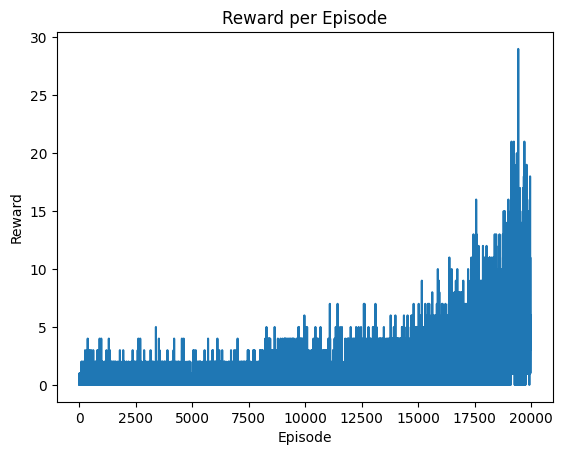

Episode 19970, Reward: 2.0
Episode 19980, Reward: 6.0
Episode 19990, Reward: 2.0
Episode 20000, Reward: 11.0


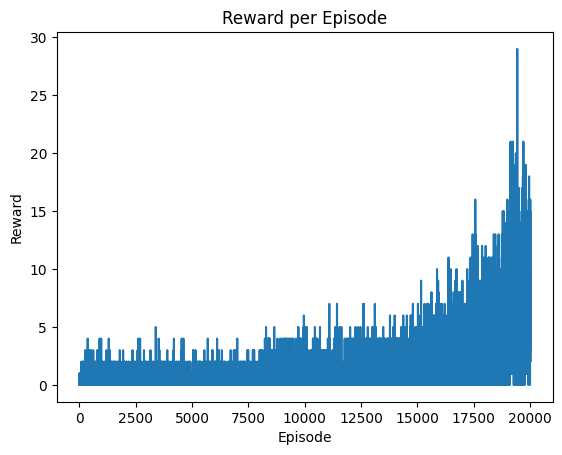

Episode 20010, Reward: 13.0
Episode 20020, Reward: 17.0
Episode 20030, Reward: 0.0
Episode 20040, Reward: 2.0
Episode 20050, Reward: 0.0


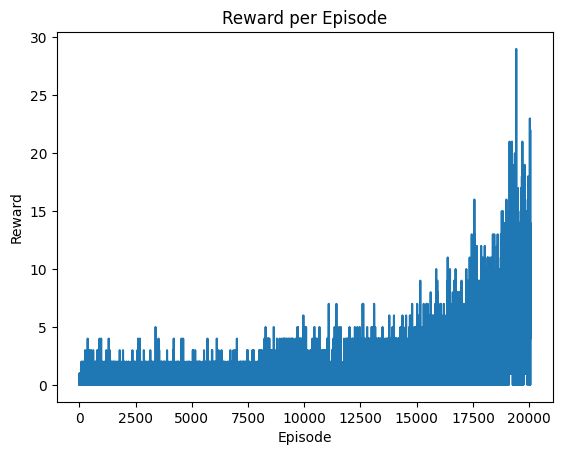

Episode 20060, Reward: 9.0
Episode 20070, Reward: 4.0
Episode 20080, Reward: 5.0
Episode 20090, Reward: 1.0
Episode 20100, Reward: 20.0


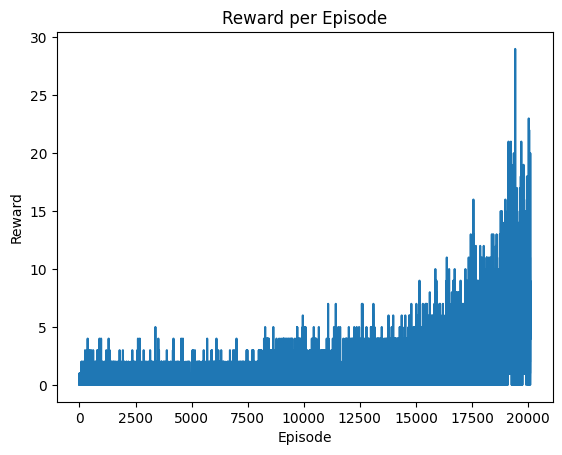

Episode 20110, Reward: 10.0
Episode 20120, Reward: 9.0
Episode 20130, Reward: 13.0
Episode 20140, Reward: 22.0


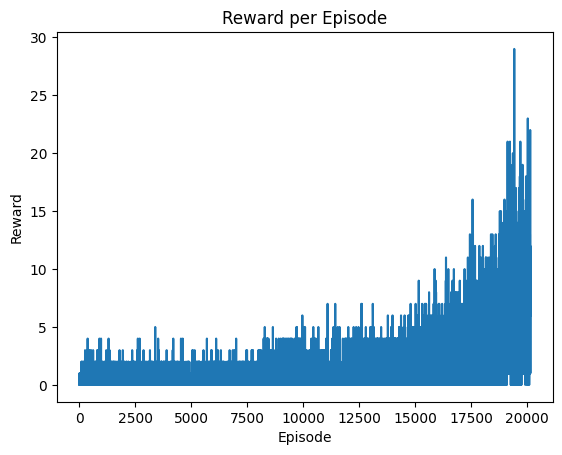

Episode 20150, Reward: 9.0
Episode 20160, Reward: 3.0
Episode 20170, Reward: 8.0
Episode 20180, Reward: 7.0
Episode 20190, Reward: 12.0
Episode 20200, Reward: 6.0


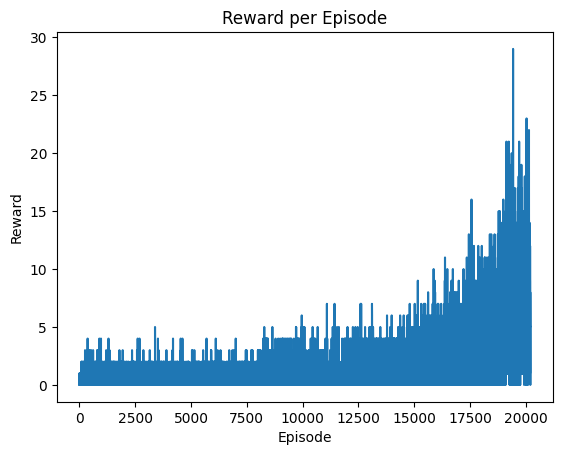

Episode 20210, Reward: 7.0
Episode 20220, Reward: 1.0
Episode 20230, Reward: 11.0
Episode 20240, Reward: 7.0
Episode 20250, Reward: 2.0


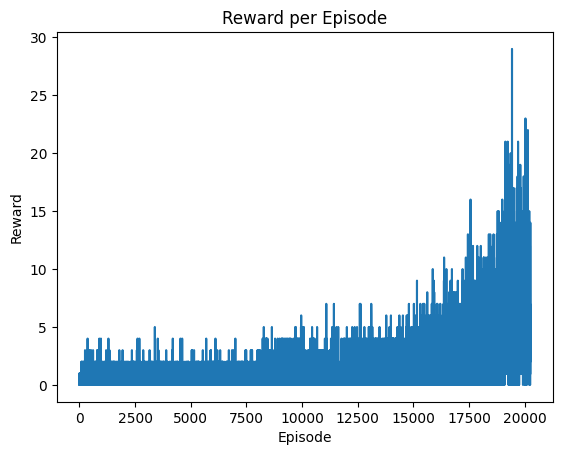

Episode 20260, Reward: 8.0
Episode 20270, Reward: 9.0
Episode 20280, Reward: 3.0
Episode 20290, Reward: 17.0


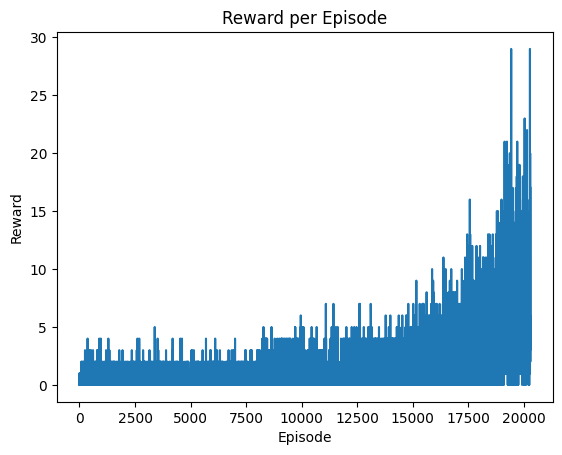

Episode 20300, Reward: 8.0
Episode 20310, Reward: 6.0
Episode 20320, Reward: 12.0
Episode 20330, Reward: 15.0


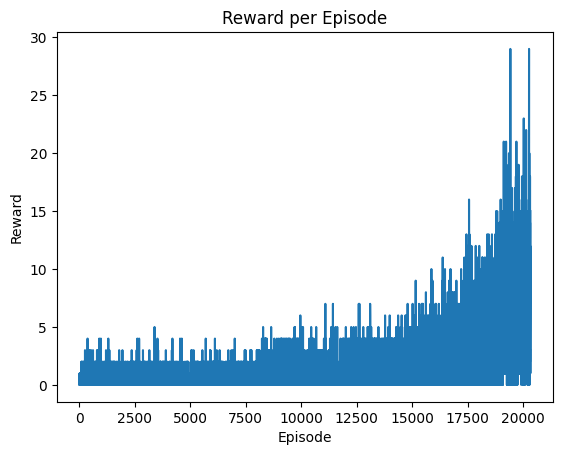

Episode 20340, Reward: 5.0
Episode 20350, Reward: 1.0
Episode 20360, Reward: 4.0
Episode 20370, Reward: 4.0


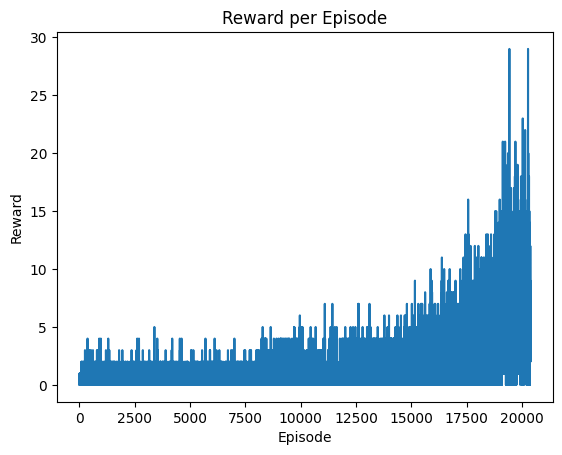

Episode 20380, Reward: 13.0
Episode 20390, Reward: 8.0
Episode 20400, Reward: 14.0
Episode 20410, Reward: 7.0
Episode 20420, Reward: 9.0


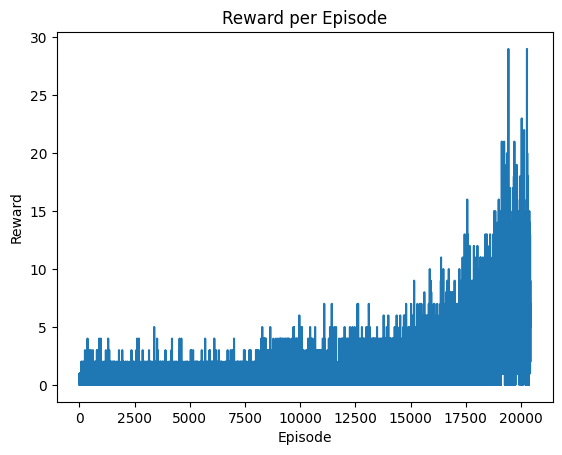

Episode 20430, Reward: 7.0
Episode 20440, Reward: 3.0
Episode 20450, Reward: 7.0
Episode 20460, Reward: 12.0
Episode 20470, Reward: 7.0


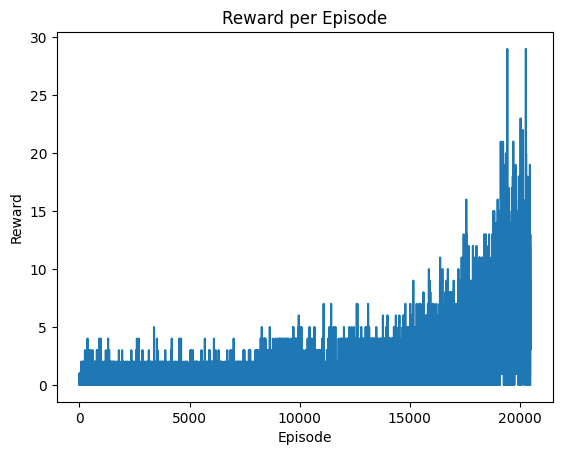

Episode 20480, Reward: 4.0
Episode 20490, Reward: 18.0
Episode 20500, Reward: 5.0
Episode 20510, Reward: 6.0
Episode 20520, Reward: 14.0


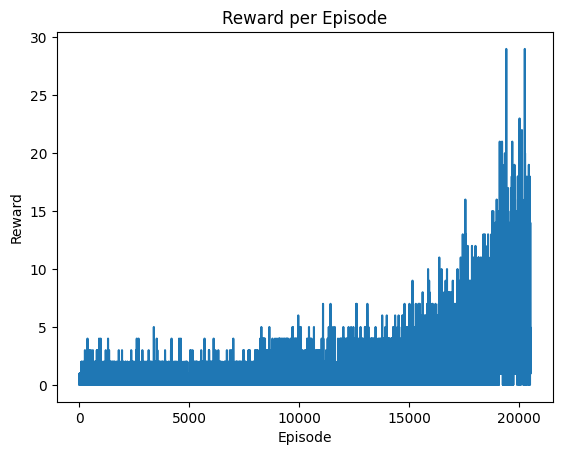

Episode 20530, Reward: 6.0
Episode 20540, Reward: 4.0
Episode 20550, Reward: 2.0
Episode 20560, Reward: 20.0


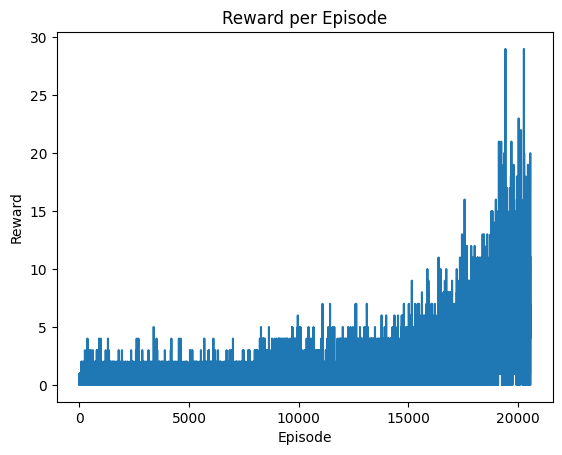

Episode 20570, Reward: 12.0
Episode 20580, Reward: 10.0
Episode 20590, Reward: 7.0
Episode 20600, Reward: 5.0
Episode 20610, Reward: 11.0


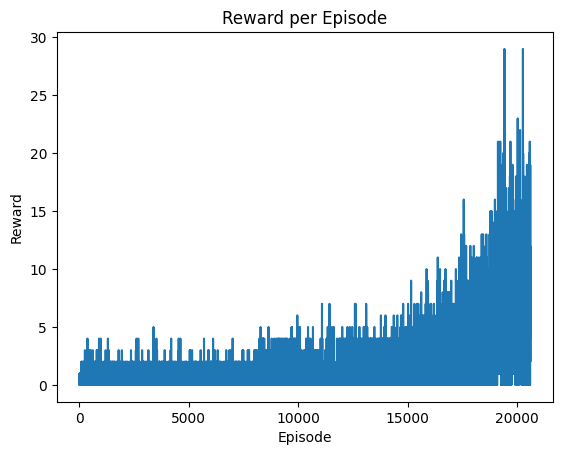

Episode 20620, Reward: 1.0
Episode 20630, Reward: 6.0
Episode 20640, Reward: 2.0
Episode 20650, Reward: 3.0


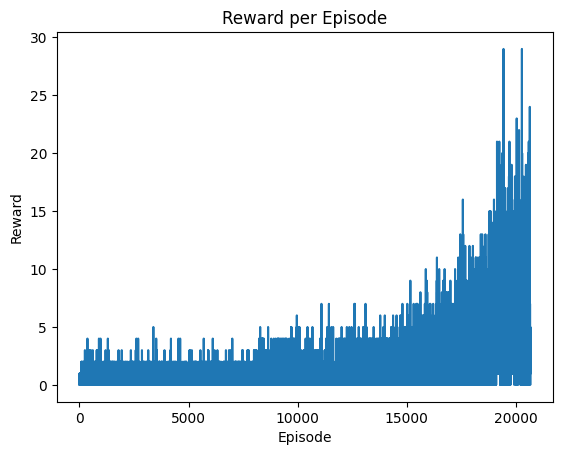

Episode 20660, Reward: 6.0
Episode 20670, Reward: 6.0
Episode 20680, Reward: 21.0
Episode 20690, Reward: 1.0
Episode 20700, Reward: 6.0


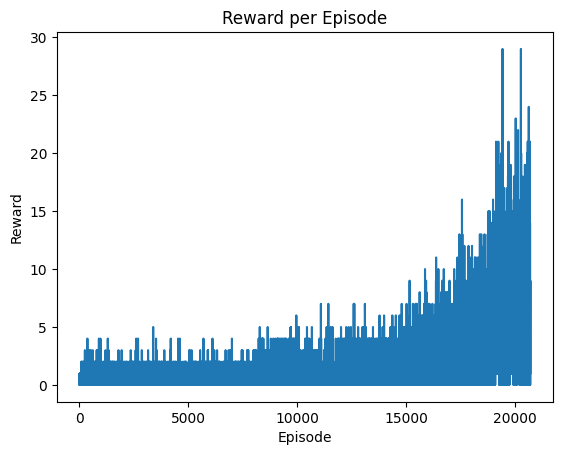

Episode 20710, Reward: 1.0
Episode 20720, Reward: 4.0
Episode 20730, Reward: 1.0
Episode 20740, Reward: 15.0
Episode 20750, Reward: 8.0


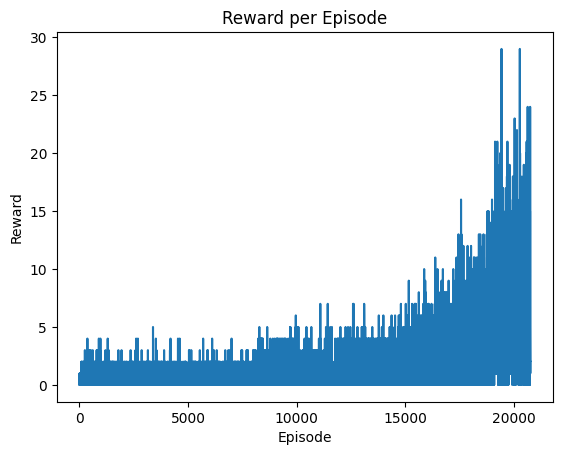

Episode 20760, Reward: 8.0
Episode 20770, Reward: 2.0
Episode 20780, Reward: 3.0
Episode 20790, Reward: 11.0
Episode 20800, Reward: 5.0


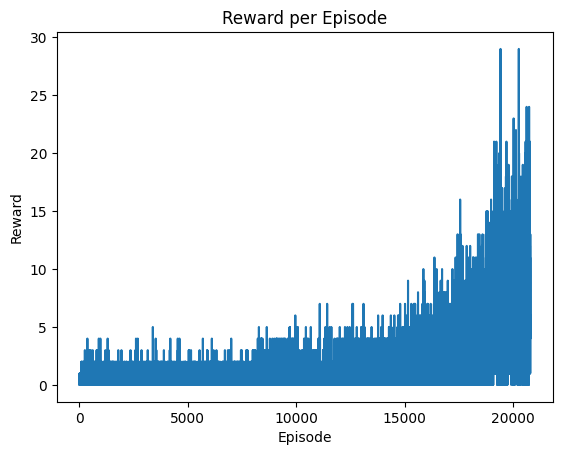

Episode 20810, Reward: 7.0
Episode 20820, Reward: 12.0
Episode 20830, Reward: 2.0
Episode 20840, Reward: 16.0


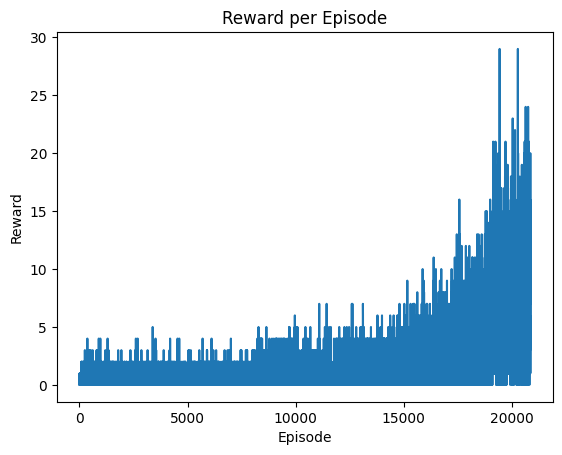

Episode 20850, Reward: 10.0
Episode 20860, Reward: 19.0
Episode 20870, Reward: 15.0
Episode 20880, Reward: 14.0
Episode 20890, Reward: 8.0


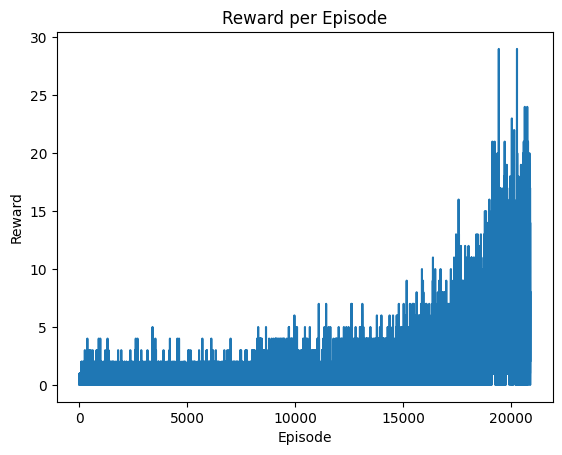

Episode 20900, Reward: 6.0
Episode 20910, Reward: 4.0
Episode 20920, Reward: 9.0
Episode 20930, Reward: 1.0
Episode 20940, Reward: 6.0


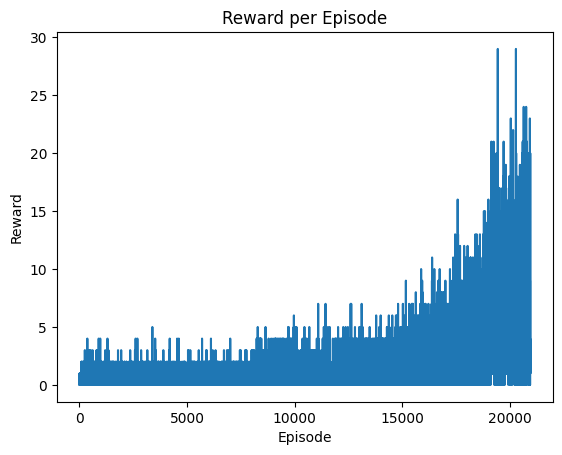

Episode 20950, Reward: 14.0
Episode 20960, Reward: 9.0
Episode 20970, Reward: 1.0
Episode 20980, Reward: 16.0


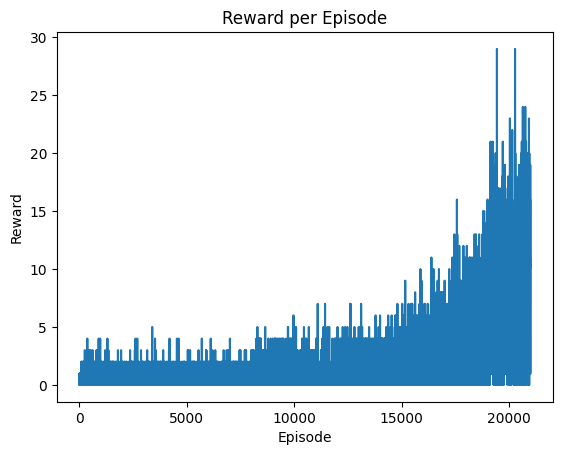

Episode 20990, Reward: 12.0
Episode 21000, Reward: 22.0
Episode 21010, Reward: 5.0
Episode 21020, Reward: 8.0


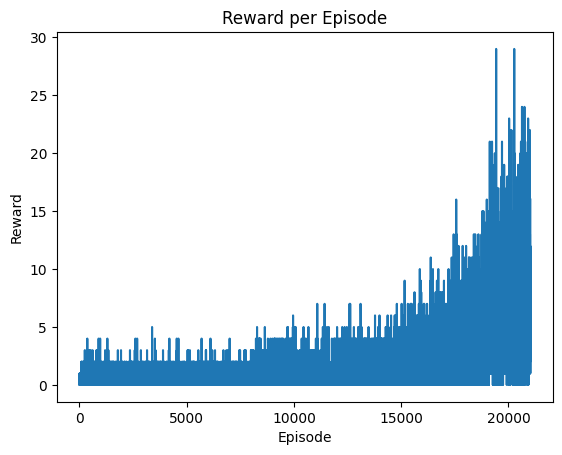

Episode 21030, Reward: 8.0
Episode 21040, Reward: 12.0
Episode 21050, Reward: 2.0
Episode 21060, Reward: 0.0


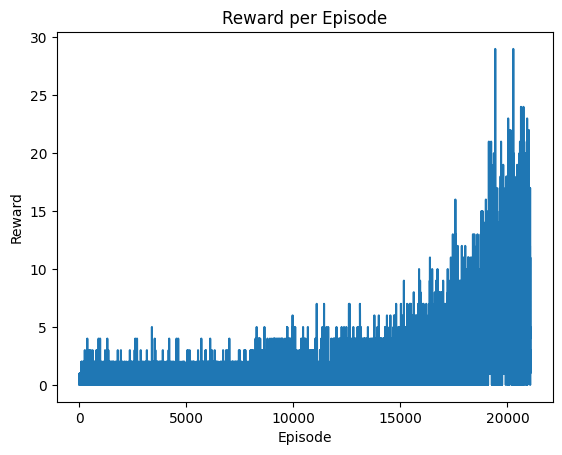

Episode 21070, Reward: 12.0
Episode 21080, Reward: 5.0
Episode 21090, Reward: 18.0
Episode 21100, Reward: 9.0
Episode 21110, Reward: 12.0


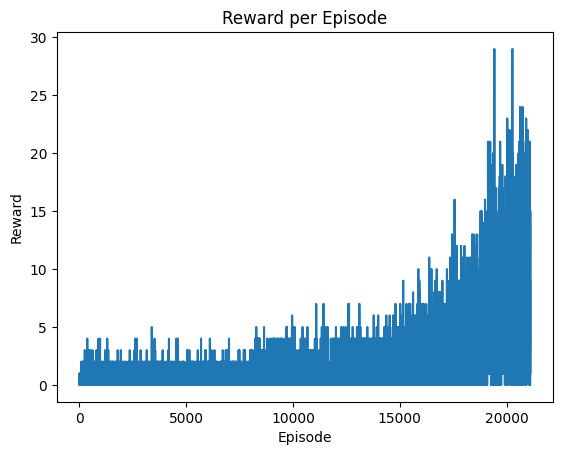

Episode 21120, Reward: 4.0
Episode 21130, Reward: 5.0
Episode 21140, Reward: 4.0
Episode 21150, Reward: 4.0
Episode 21160, Reward: 12.0


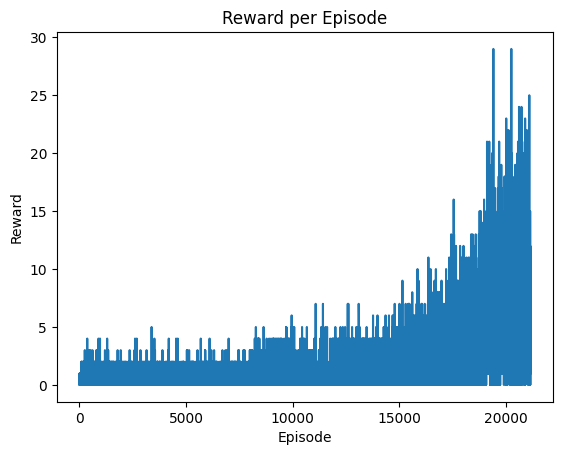

Episode 21170, Reward: 12.0
Episode 21180, Reward: 11.0
Episode 21190, Reward: 6.0
Episode 21200, Reward: 11.0


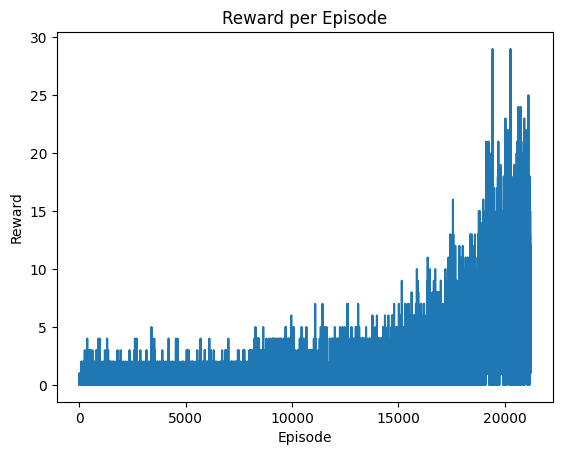

Episode 21210, Reward: 8.0
Episode 21220, Reward: 25.0
Episode 21230, Reward: 4.0
Episode 21240, Reward: 6.0
Episode 21250, Reward: 1.0


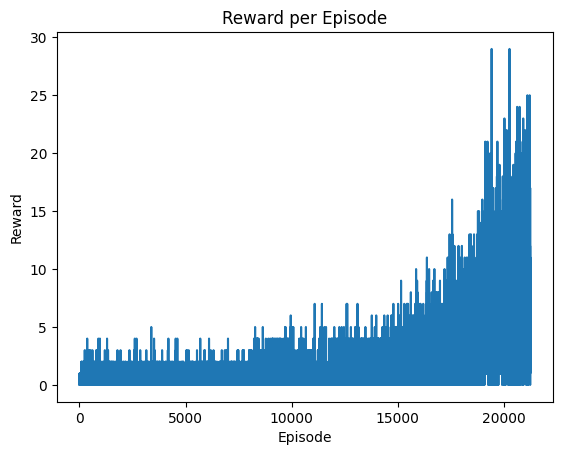

Episode 21260, Reward: 2.0
Episode 21270, Reward: 16.0
Episode 21280, Reward: 7.0
Episode 21290, Reward: 6.0


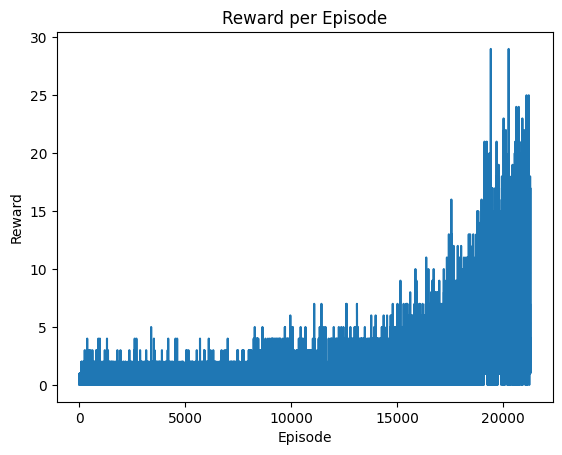

Episode 21300, Reward: 10.0
Episode 21310, Reward: 5.0
Episode 21320, Reward: 4.0
Episode 21330, Reward: 11.0


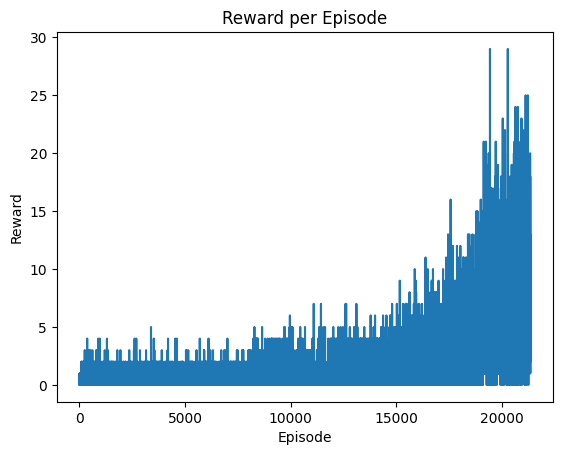

Episode 21340, Reward: 15.0
Episode 21350, Reward: 5.0
Episode 21360, Reward: 9.0
Episode 21370, Reward: 4.0
Episode 21380, Reward: 7.0


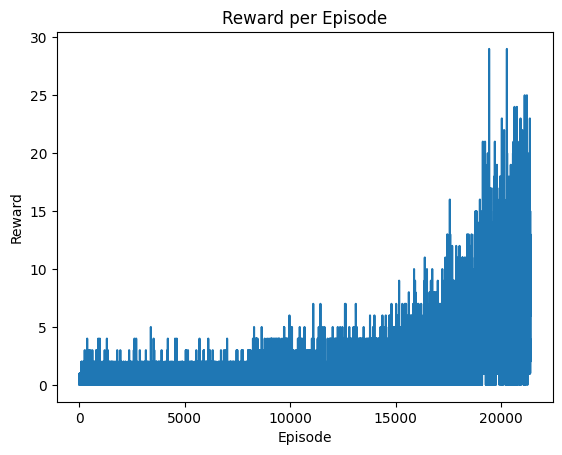

Episode 21390, Reward: 6.0
Episode 21400, Reward: 6.0
Episode 21410, Reward: 2.0
Episode 21420, Reward: 13.0
Episode 21430, Reward: 6.0


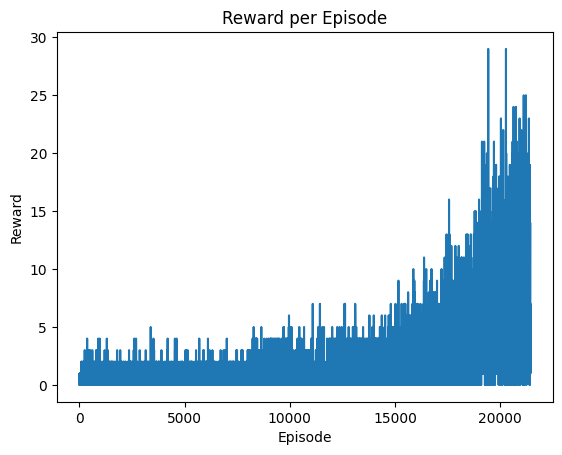

Episode 21440, Reward: 2.0
Episode 21450, Reward: 12.0
Episode 21460, Reward: 2.0
Episode 21470, Reward: 10.0


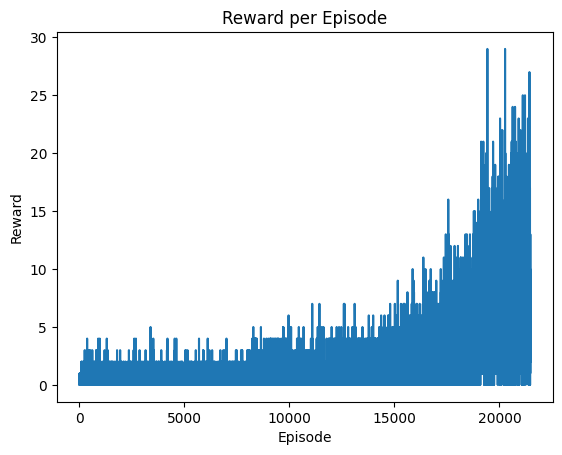

Episode 21480, Reward: 13.0
Episode 21490, Reward: 2.0
Episode 21500, Reward: 11.0
Episode 21510, Reward: 9.0
Episode 21520, Reward: 11.0


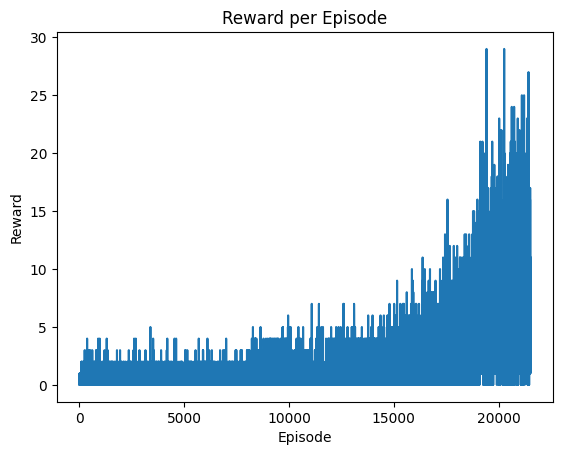

Episode 21530, Reward: 13.0
Episode 21540, Reward: 2.0
Episode 21550, Reward: 9.0
Episode 21560, Reward: 1.0


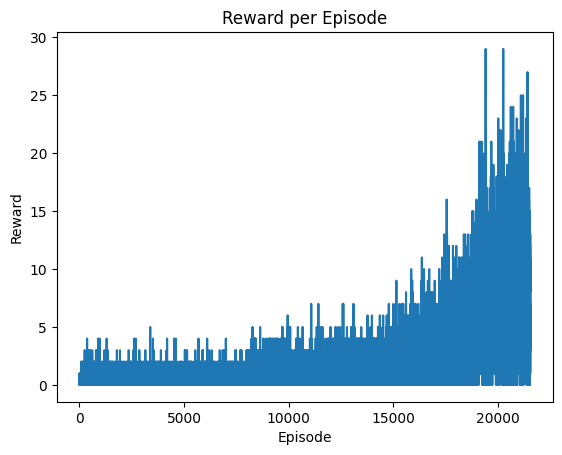

Episode 21570, Reward: 12.0
Episode 21580, Reward: 7.0
Episode 21590, Reward: 14.0
Episode 21600, Reward: 13.0
Episode 21610, Reward: 12.0


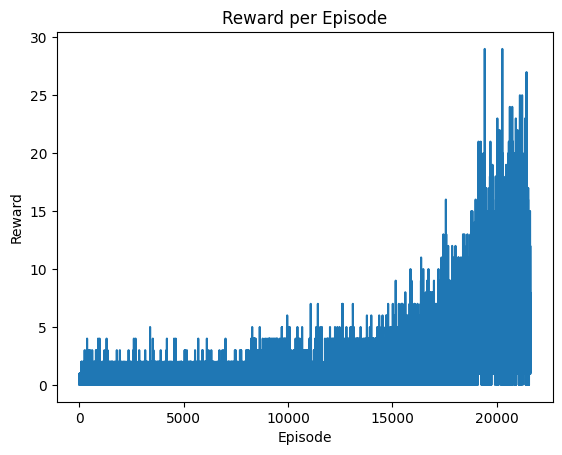

Episode 21620, Reward: 0.0
Episode 21630, Reward: 7.0
Episode 21640, Reward: 6.0
Episode 21650, Reward: 3.0
Episode 21660, Reward: 26.0


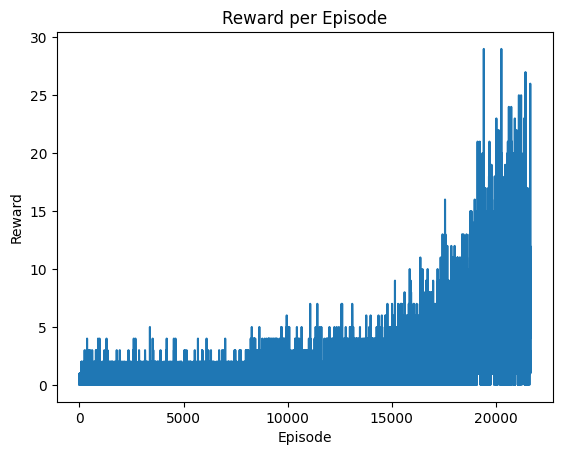

Episode 21670, Reward: 12.0
Episode 21680, Reward: 10.0
Episode 21690, Reward: 12.0
Episode 21700, Reward: 8.0


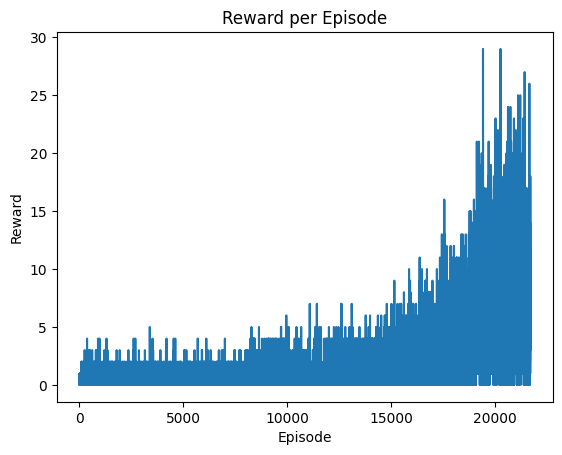

Episode 21710, Reward: 10.0
Episode 21720, Reward: 20.0
Episode 21730, Reward: 15.0
Episode 21740, Reward: 6.0


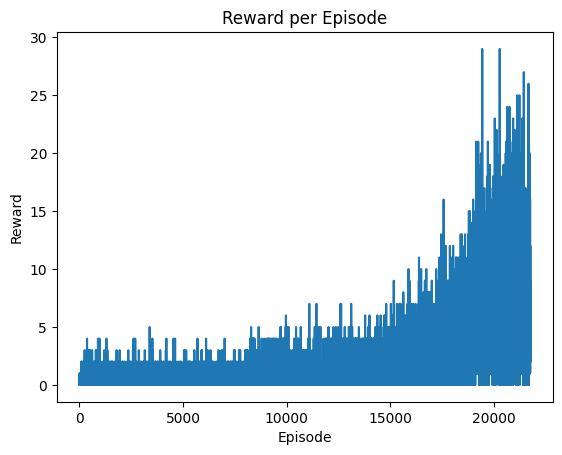

Episode 21750, Reward: 7.0
Episode 21760, Reward: 11.0
Episode 21770, Reward: 9.0
Episode 21780, Reward: 5.0
Episode 21790, Reward: 3.0


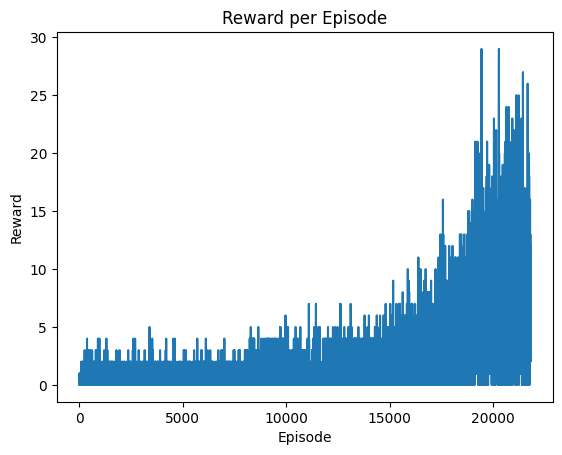

Episode 21800, Reward: 0.0
Episode 21810, Reward: 11.0
Episode 21820, Reward: 14.0
Episode 21830, Reward: 6.0


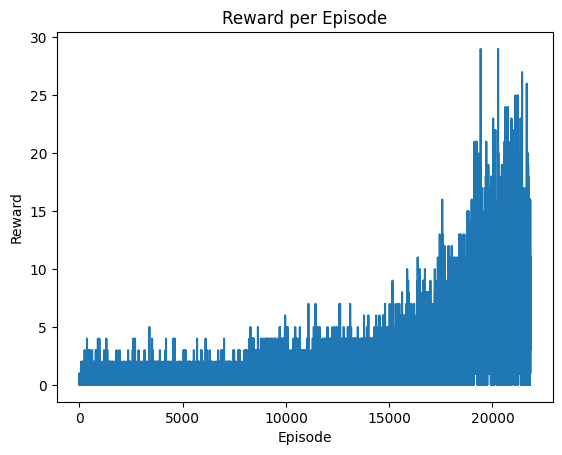

Episode 21840, Reward: 13.0
Episode 21850, Reward: 4.0
Episode 21860, Reward: 8.0
Episode 21870, Reward: 6.0


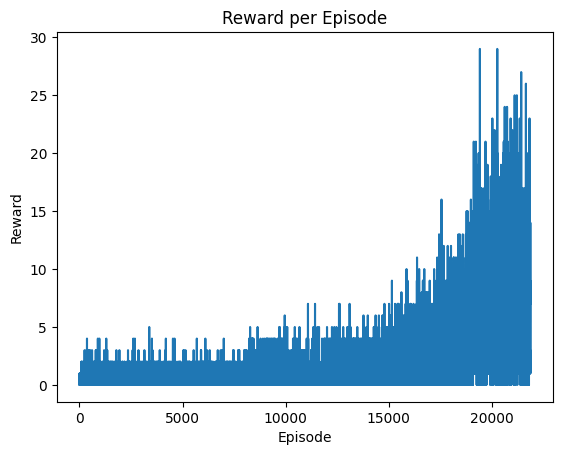

Episode 21880, Reward: 12.0
Episode 21890, Reward: 7.0
Episode 21900, Reward: 6.0
Episode 21910, Reward: 16.0
Episode 21920, Reward: 10.0


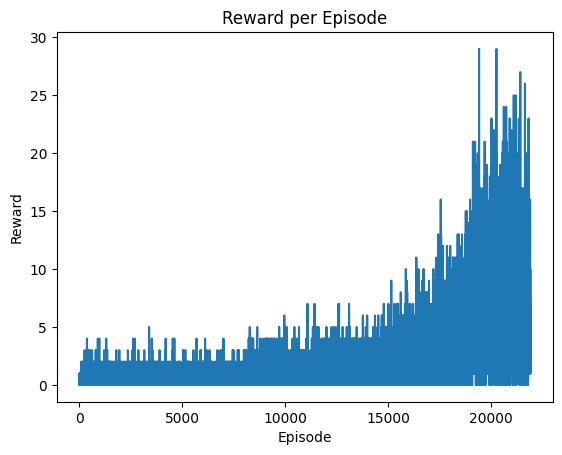

Episode 21930, Reward: 0.0
Episode 21940, Reward: 13.0
Episode 21950, Reward: 9.0
Episode 21960, Reward: 6.0
Episode 21970, Reward: 2.0


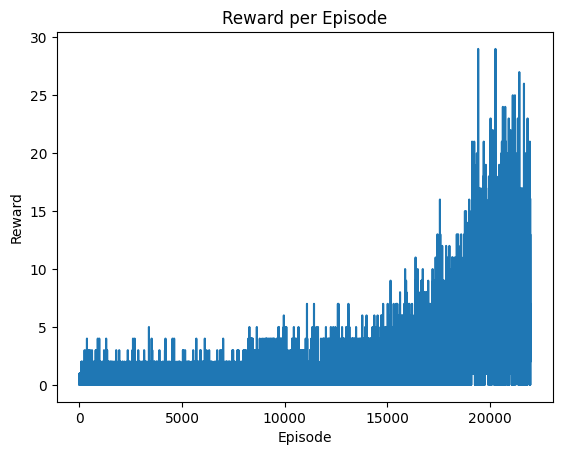

Episode 21980, Reward: 12.0
Episode 21990, Reward: 4.0
Episode 22000, Reward: 6.0
Episode 22010, Reward: 12.0


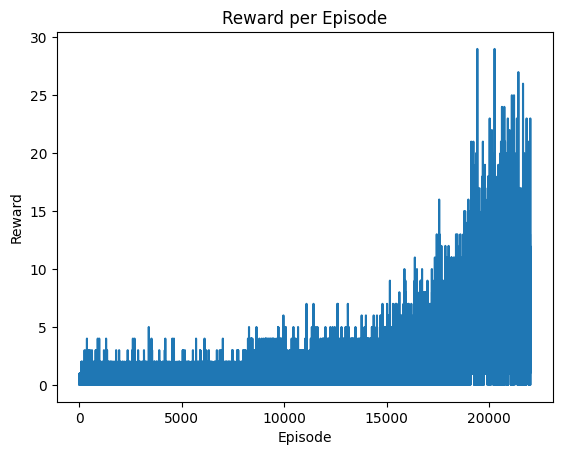

Episode 22020, Reward: 5.0
Episode 22030, Reward: 11.0
Episode 22040, Reward: 3.0
Episode 22050, Reward: 2.0
Episode 22060, Reward: 8.0


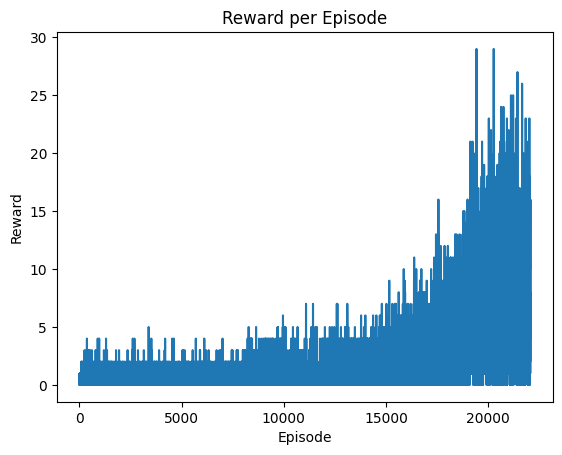

Episode 22070, Reward: 30.0
Episode 22080, Reward: 17.0
Episode 22090, Reward: 0.0
Episode 22100, Reward: 2.0


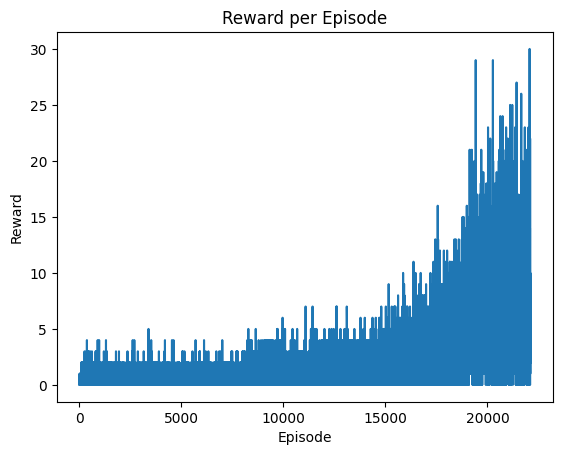

Episode 22110, Reward: 9.0
Episode 22120, Reward: 7.0
Episode 22130, Reward: 2.0
Episode 22140, Reward: 5.0
Episode 22150, Reward: 5.0


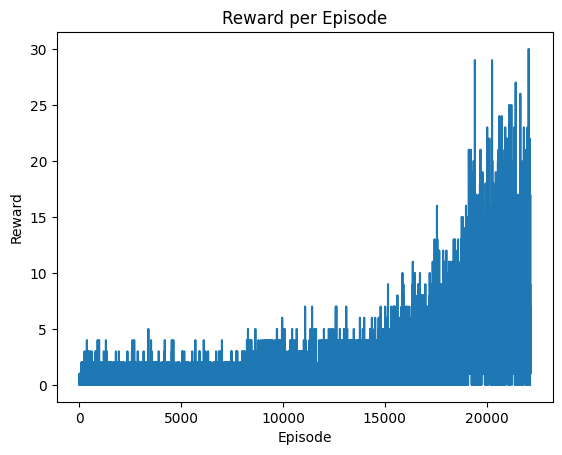

Episode 22160, Reward: 22.0
Episode 22170, Reward: 14.0
Episode 22180, Reward: 8.0
Episode 22190, Reward: 19.0


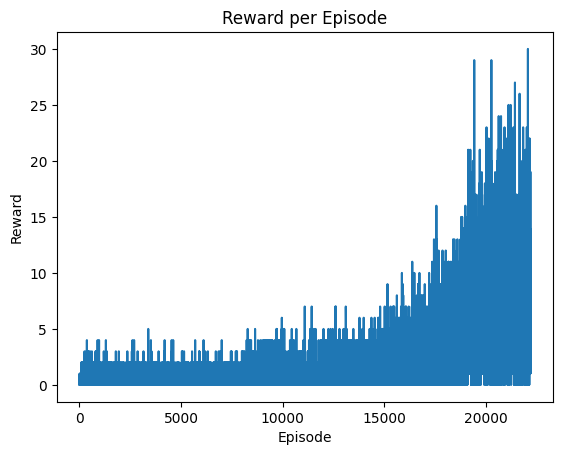

Episode 22200, Reward: 10.0
Episode 22210, Reward: 2.0
Episode 22220, Reward: 1.0
Episode 22230, Reward: 5.0


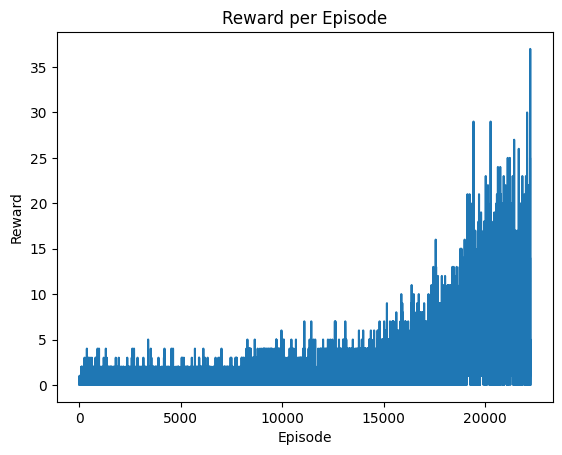

Episode 22240, Reward: 13.0
Episode 22250, Reward: 7.0
Episode 22260, Reward: 2.0
Episode 22270, Reward: 2.0


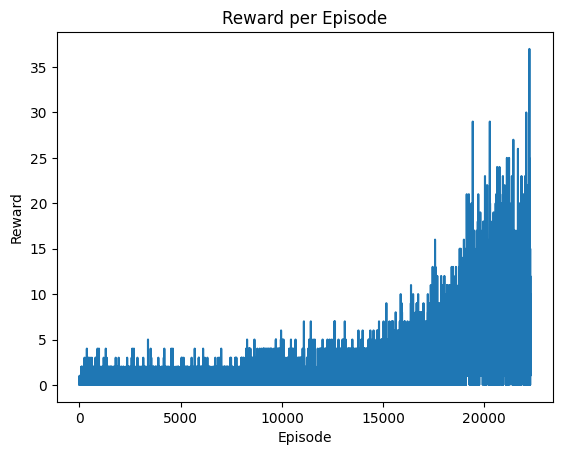

Episode 22280, Reward: 28.0
Episode 22290, Reward: 21.0
Episode 22300, Reward: 6.0
Episode 22310, Reward: 0.0


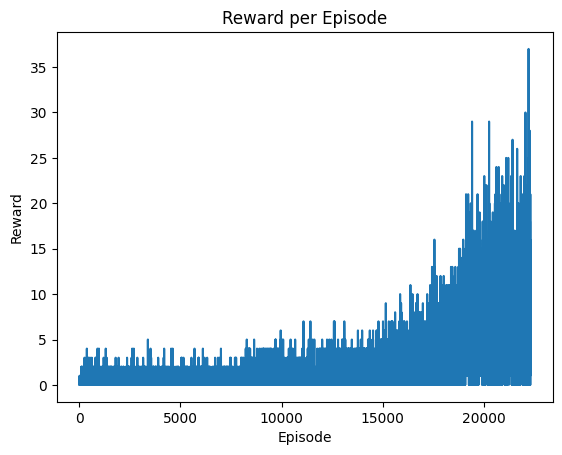

Episode 22320, Reward: 16.0
Episode 22330, Reward: 4.0
Episode 22340, Reward: 13.0
Episode 22350, Reward: 10.0


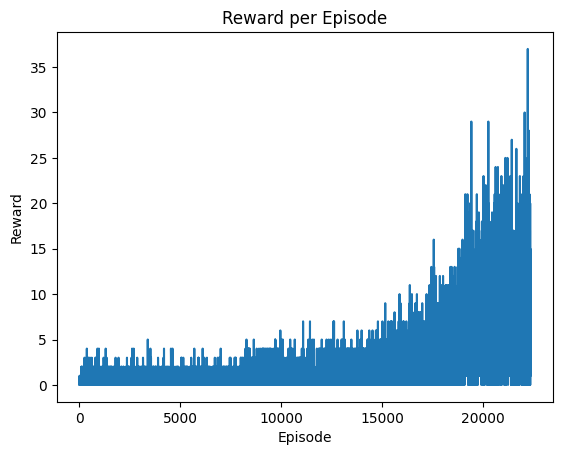

Episode 22360, Reward: 9.0
Episode 22370, Reward: 13.0
Episode 22380, Reward: 12.0
Episode 22390, Reward: 11.0


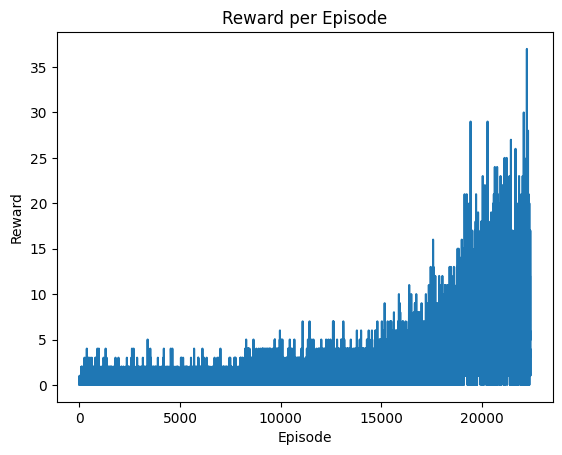

Episode 22400, Reward: 4.0
Episode 22410, Reward: 6.0
Episode 22420, Reward: 21.0
Episode 22430, Reward: 11.0


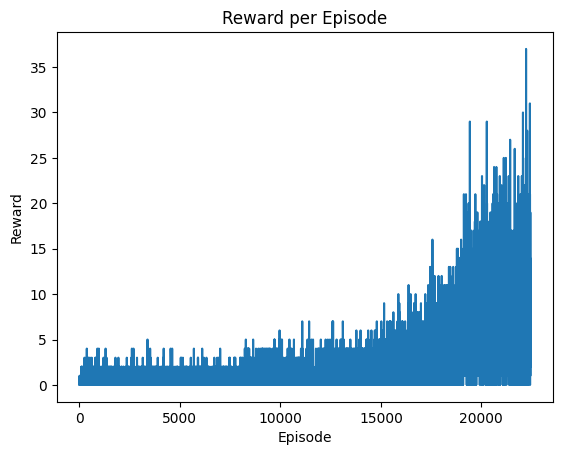

Episode 22440, Reward: 0.0
Episode 22450, Reward: 4.0
Episode 22460, Reward: 8.0
Episode 22470, Reward: 2.0
Episode 22480, Reward: 3.0


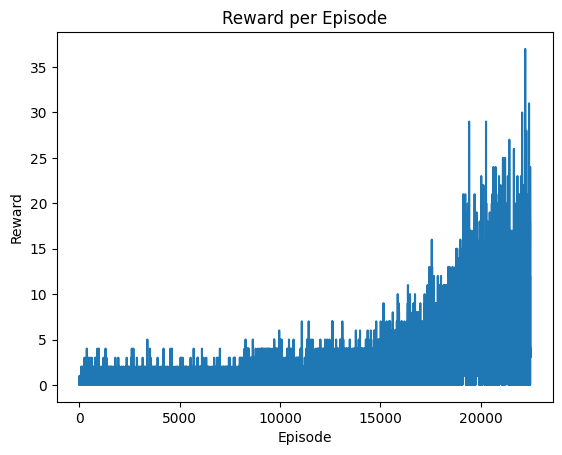

Episode 22490, Reward: 3.0
Episode 22500, Reward: 13.0
Episode 22510, Reward: 14.0
Episode 22520, Reward: 6.0


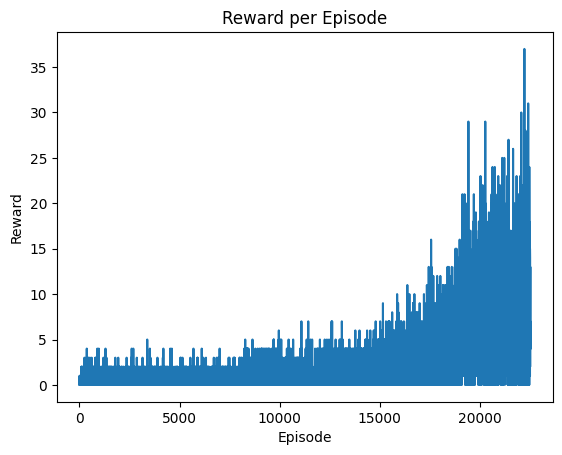

Episode 22530, Reward: 8.0
Episode 22540, Reward: 5.0
Episode 22550, Reward: 7.0
Episode 22560, Reward: 9.0


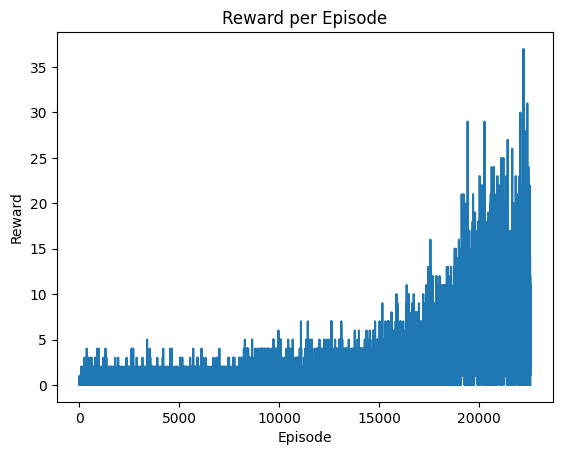

Episode 22570, Reward: 6.0
Episode 22580, Reward: 8.0
Episode 22590, Reward: 27.0
Episode 22600, Reward: 3.0
Episode 22610, Reward: 0.0


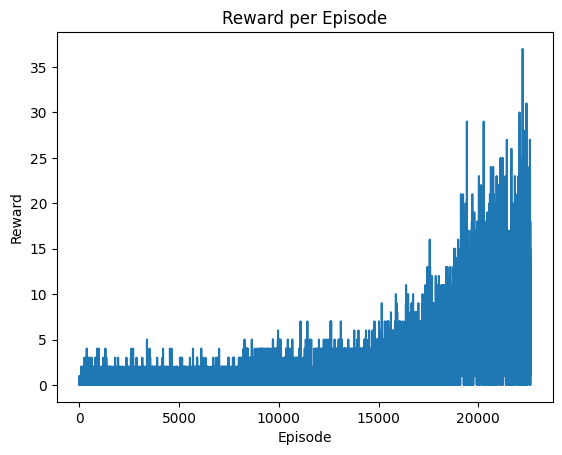

Episode 22620, Reward: 5.0
Episode 22630, Reward: 12.0
Episode 22640, Reward: 12.0
Episode 22650, Reward: 13.0


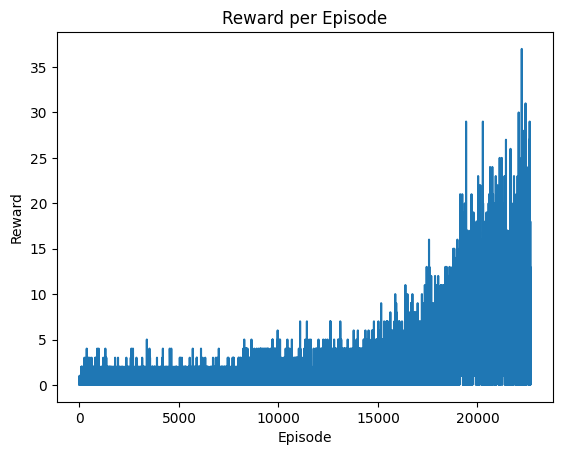

Episode 22660, Reward: 21.0
Episode 22670, Reward: 8.0
Episode 22680, Reward: 7.0
Episode 22690, Reward: 5.0


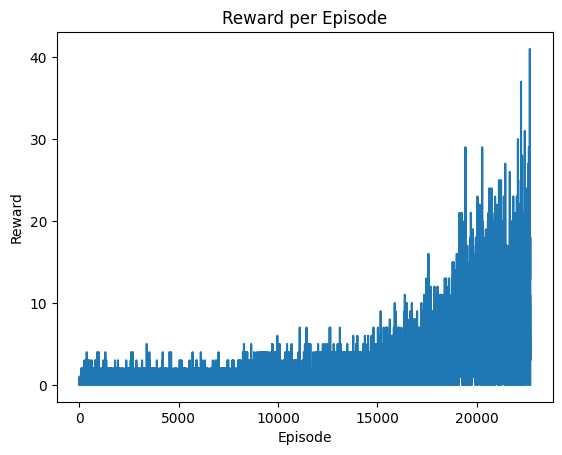

Episode 22700, Reward: 4.0
Episode 22710, Reward: 7.0
Episode 22720, Reward: 4.0
Episode 22730, Reward: 10.0


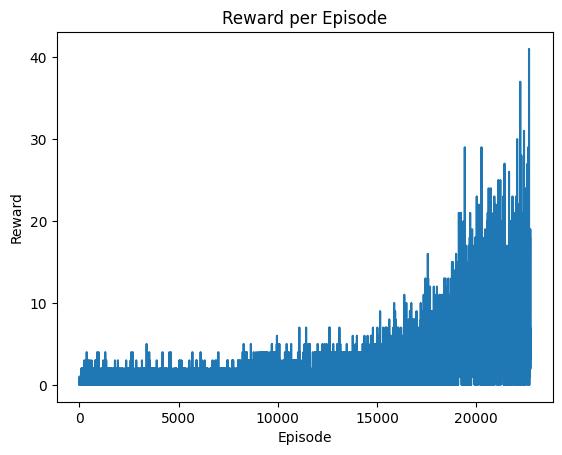

Episode 22740, Reward: 3.0
Episode 22750, Reward: 15.0
Episode 22760, Reward: 8.0
Episode 22770, Reward: 8.0
Episode 22780, Reward: 4.0


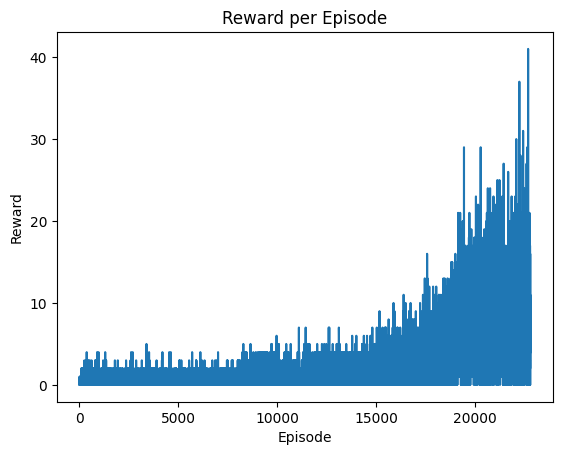

Episode 22790, Reward: 5.0
Episode 22800, Reward: 19.0
Episode 22810, Reward: 1.0
Episode 22820, Reward: 5.0
Episode 22830, Reward: 5.0


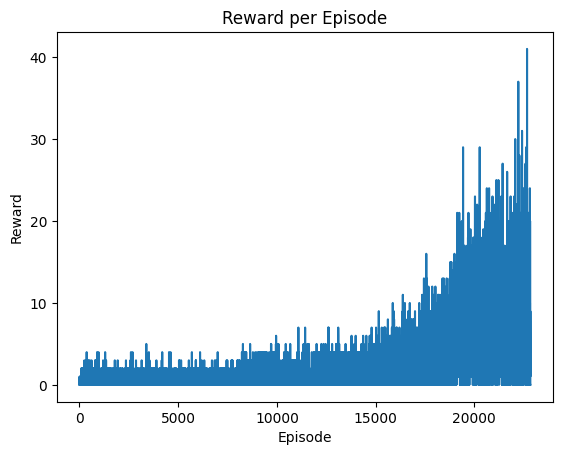

Episode 22840, Reward: 3.0
Episode 22850, Reward: 5.0
Episode 22860, Reward: 21.0
Episode 22870, Reward: 14.0


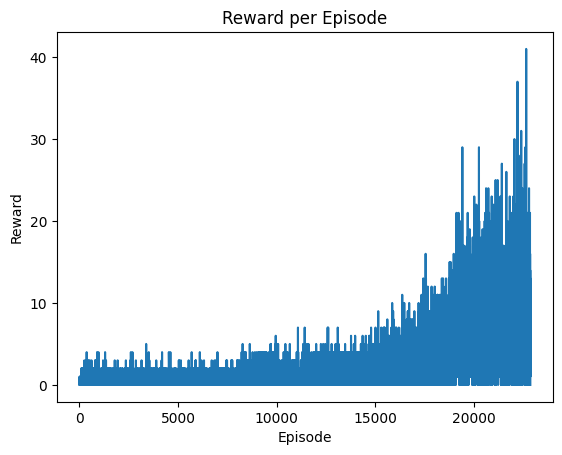

Episode 22880, Reward: 5.0
Episode 22890, Reward: 1.0
Episode 22900, Reward: 2.0
Episode 22910, Reward: 1.0
Episode 22920, Reward: 11.0


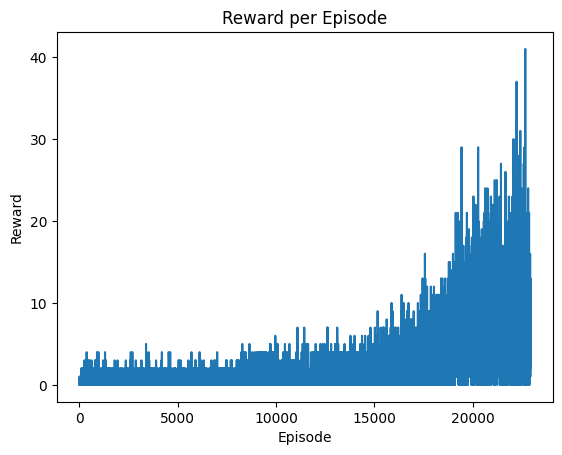

Episode 22930, Reward: 1.0
Episode 22940, Reward: 2.0
Episode 22950, Reward: 1.0
Episode 22960, Reward: 9.0
Episode 22970, Reward: 5.0


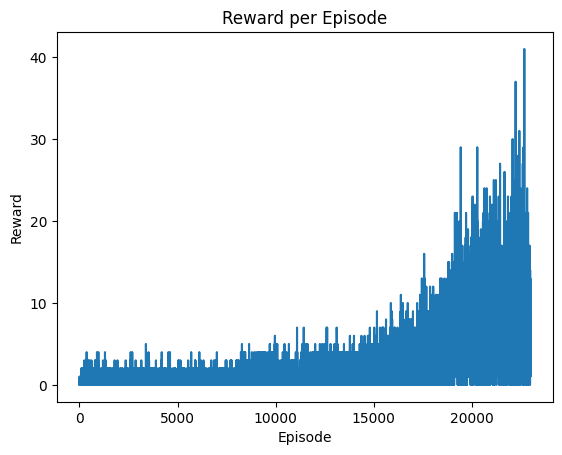

Episode 22980, Reward: 5.0
Episode 22990, Reward: 7.0
Episode 23000, Reward: 11.0
Episode 23010, Reward: 4.0
Episode 23020, Reward: 5.0


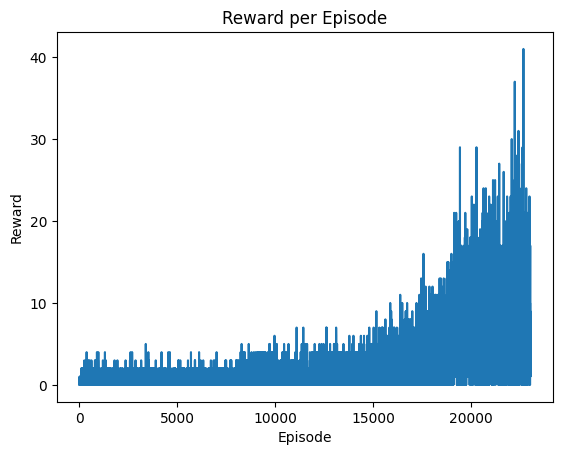

Episode 23030, Reward: 15.0
Episode 23040, Reward: 3.0
Episode 23050, Reward: 4.0
Episode 23060, Reward: 12.0
Episode 23070, Reward: 7.0


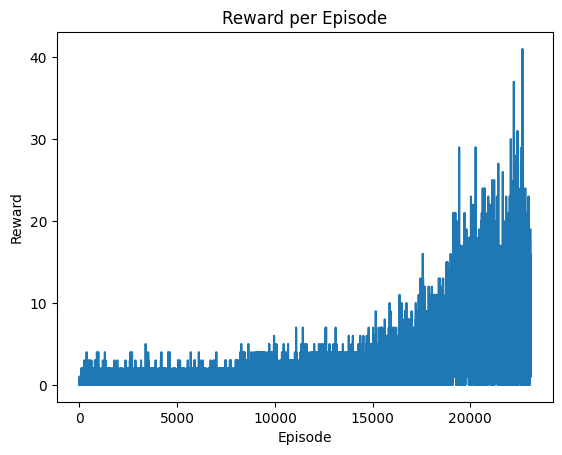

Episode 23080, Reward: 1.0
Episode 23090, Reward: 19.0
Episode 23100, Reward: 11.0
Episode 23110, Reward: 15.0


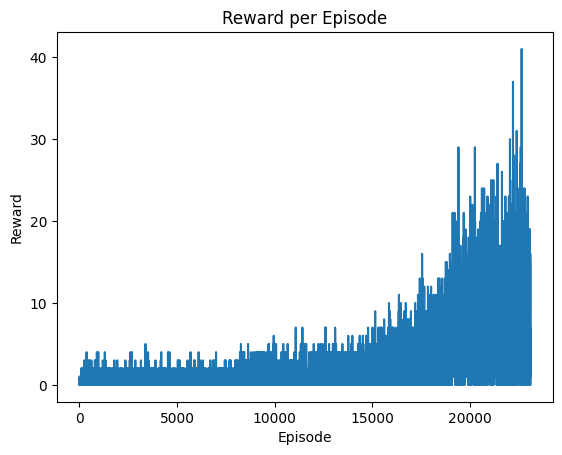

Episode 23120, Reward: 2.0
Episode 23130, Reward: 12.0
Episode 23140, Reward: 14.0
Episode 23150, Reward: 5.0


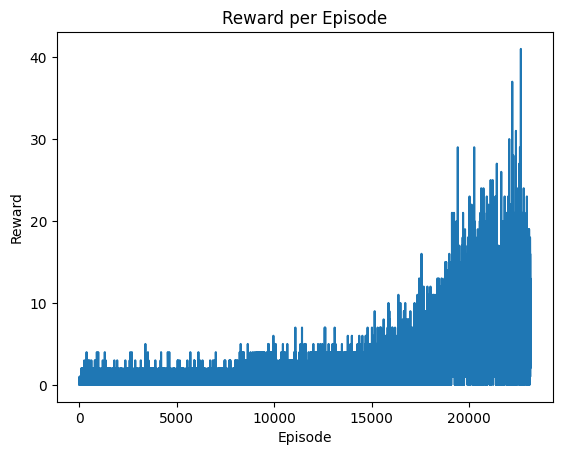

Episode 23160, Reward: 13.0
Episode 23170, Reward: 10.0
Episode 23180, Reward: 24.0
Episode 23190, Reward: 10.0
Episode 23200, Reward: 6.0


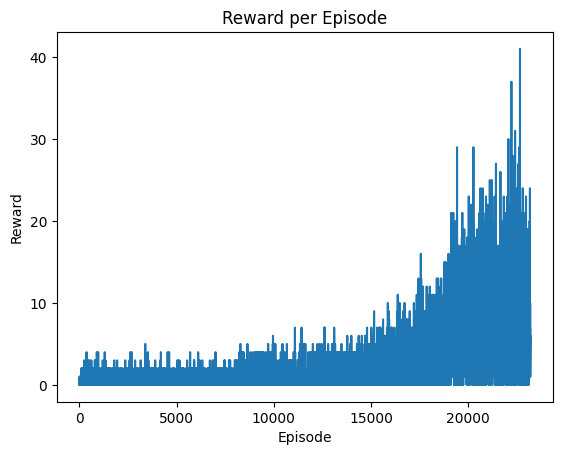

Episode 23210, Reward: 11.0
Episode 23220, Reward: 11.0
Episode 23230, Reward: 2.0
Episode 23240, Reward: 6.0


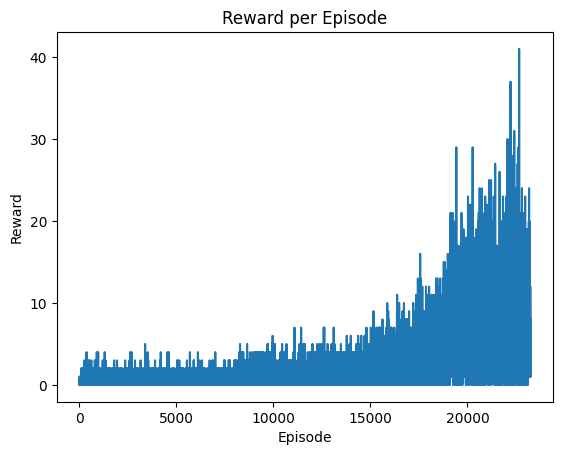

Episode 23250, Reward: 14.0
Episode 23260, Reward: 19.0
Episode 23270, Reward: 7.0
Episode 23280, Reward: 15.0


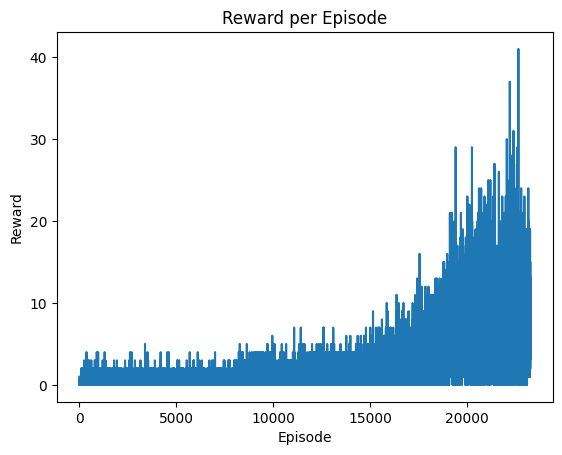

Episode 23290, Reward: 10.0
Episode 23300, Reward: 5.0
Episode 23310, Reward: 2.0
Episode 23320, Reward: 7.0
Episode 23330, Reward: 3.0


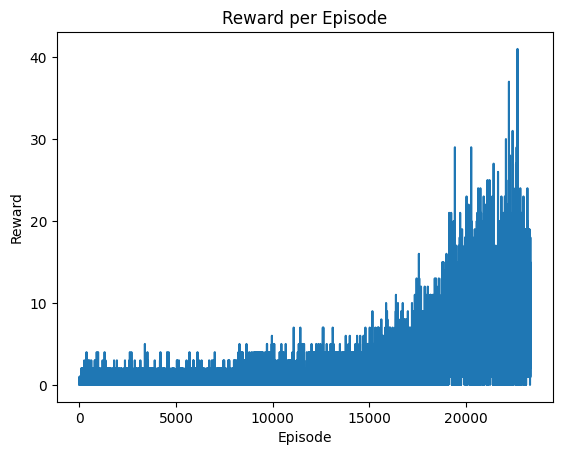

Episode 23340, Reward: 6.0
Episode 23350, Reward: 6.0
Episode 23360, Reward: 6.0
Episode 23370, Reward: 3.0
Episode 23380, Reward: 7.0


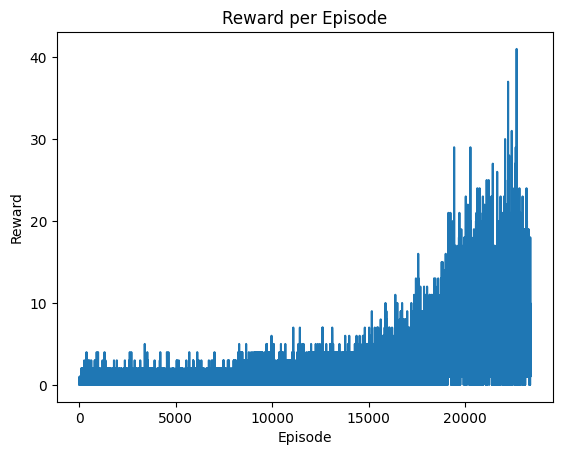

Episode 23390, Reward: 4.0
Episode 23400, Reward: 7.0
Episode 23410, Reward: 4.0
Episode 23420, Reward: 6.0


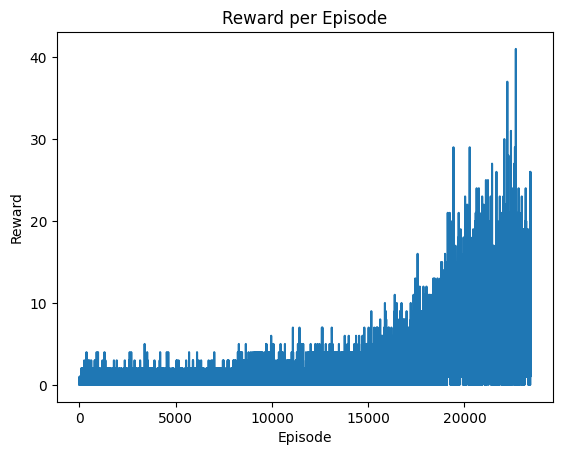

Episode 23430, Reward: 9.0
Episode 23440, Reward: 19.0
Episode 23450, Reward: 6.0
Episode 23460, Reward: 14.0


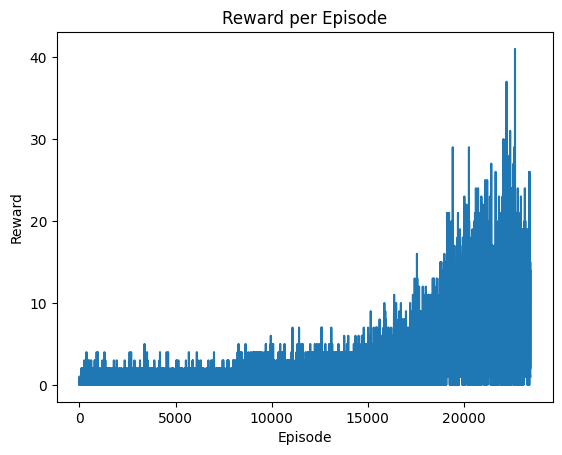

Episode 23470, Reward: 10.0
Episode 23480, Reward: 1.0
Episode 23490, Reward: 14.0
Episode 23500, Reward: 8.0
Episode 23510, Reward: 36.0


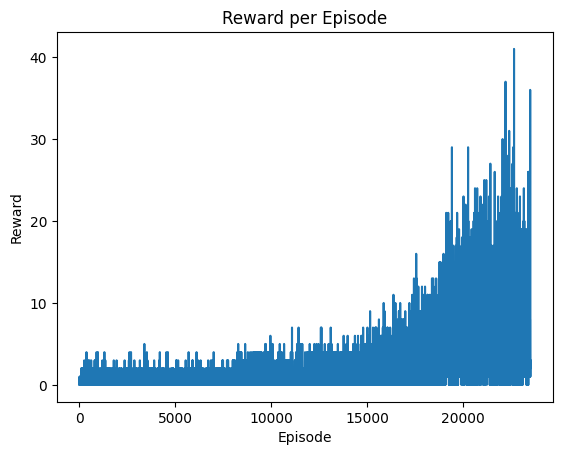

Episode 23520, Reward: 10.0
Episode 23530, Reward: 8.0
Episode 23540, Reward: 6.0
Episode 23550, Reward: 3.0
Episode 23560, Reward: 19.0


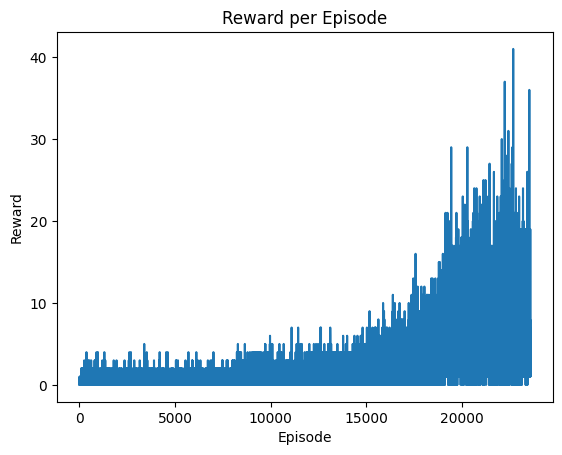

Episode 23570, Reward: 1.0
Episode 23580, Reward: 5.0
Episode 23590, Reward: 1.0
Episode 23600, Reward: 1.0


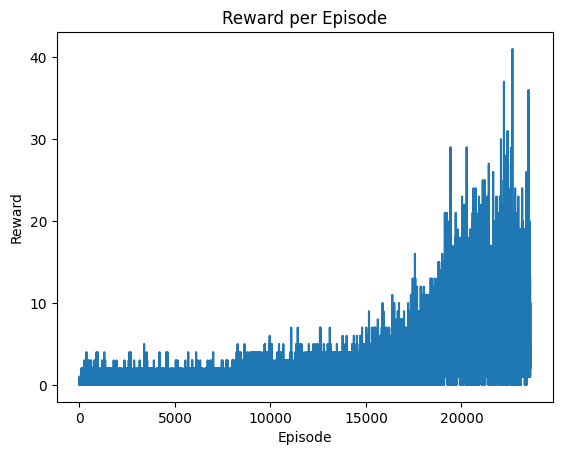

Episode 23610, Reward: 15.0
Episode 23620, Reward: 12.0
Episode 23630, Reward: 19.0
Episode 23640, Reward: 6.0
Episode 23650, Reward: 6.0


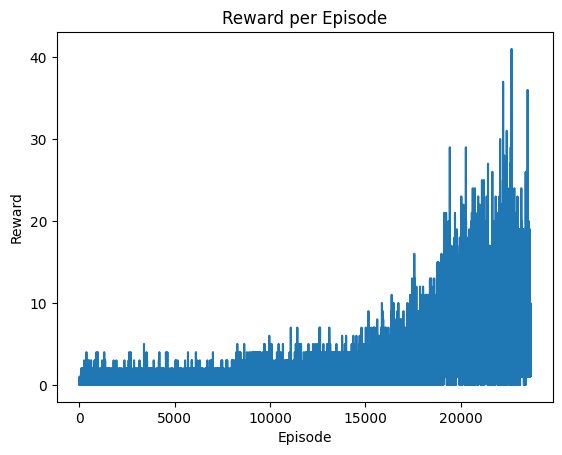

Episode 23660, Reward: 2.0
Episode 23670, Reward: 3.0
Episode 23680, Reward: 9.0
Episode 23690, Reward: 4.0
Episode 23700, Reward: 2.0


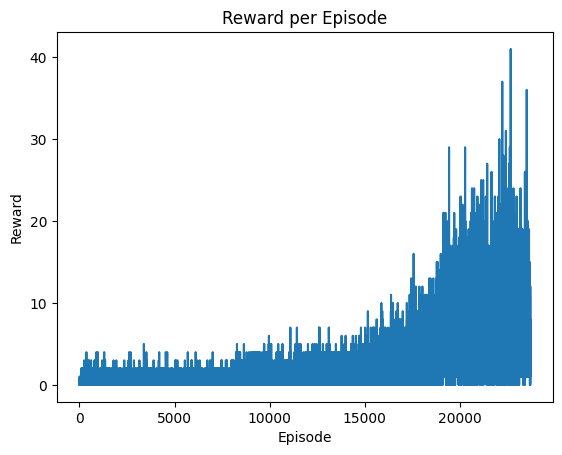

Episode 23710, Reward: 7.0
Episode 23720, Reward: 2.0
Episode 23730, Reward: 5.0
Episode 23740, Reward: 4.0
Episode 23750, Reward: 12.0


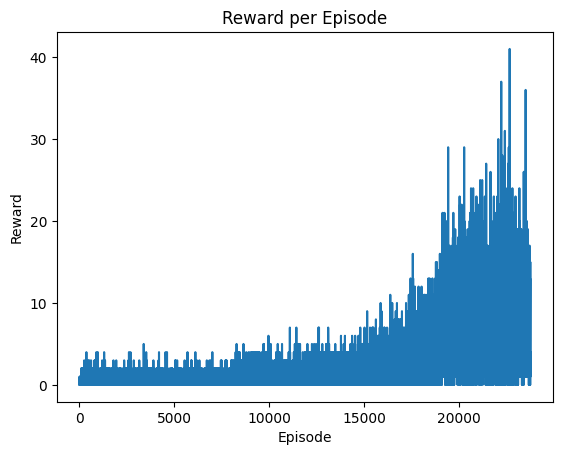

Episode 23760, Reward: 5.0
Episode 23770, Reward: 7.0
Episode 23780, Reward: 29.0
Episode 23790, Reward: 5.0
Episode 23800, Reward: 3.0


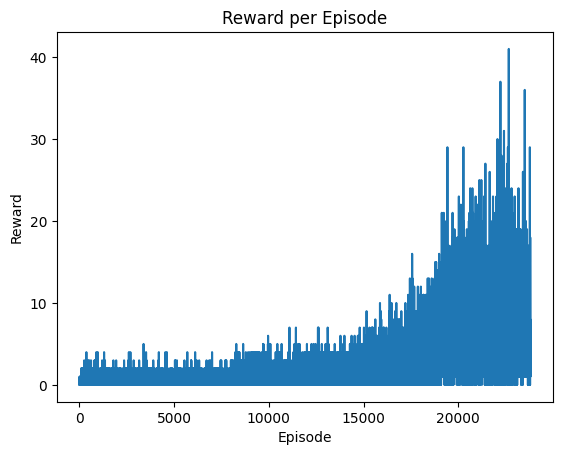

Episode 23810, Reward: 8.0
Episode 23820, Reward: 21.0
Episode 23830, Reward: 7.0
Episode 23840, Reward: 3.0
Episode 23850, Reward: 14.0


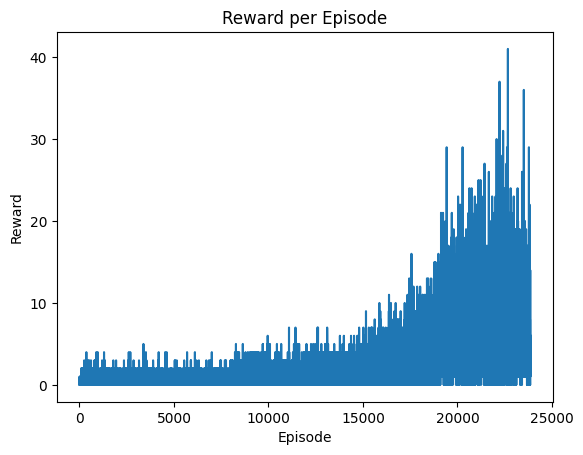

Episode 23860, Reward: 11.0
Episode 23870, Reward: 5.0
Episode 23880, Reward: 4.0
Episode 23890, Reward: 6.0
Episode 23900, Reward: 14.0


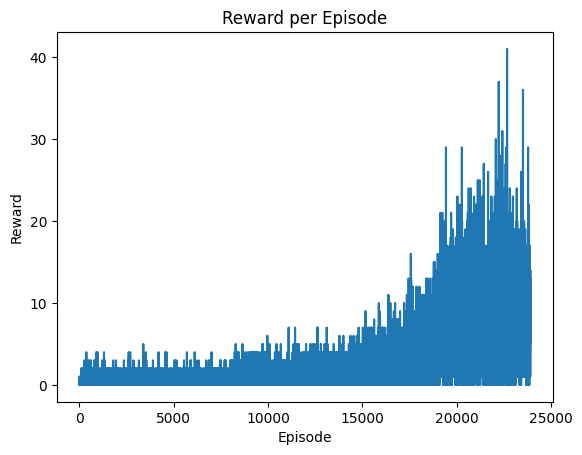

Episode 23910, Reward: 6.0
Episode 23920, Reward: 19.0
Episode 23930, Reward: 4.0
Episode 23940, Reward: 2.0


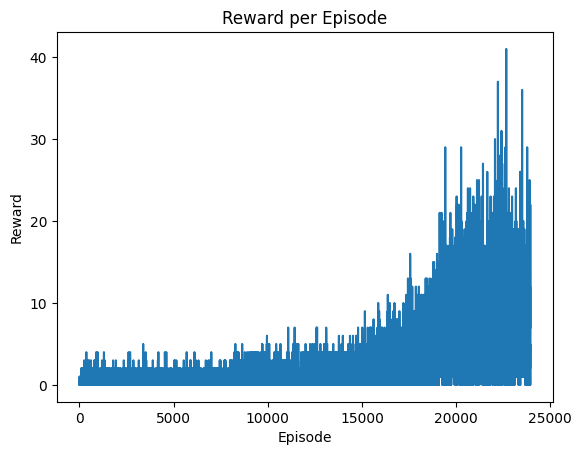

Episode 23950, Reward: 7.0
Episode 23960, Reward: 7.0
Episode 23970, Reward: 19.0
Episode 23980, Reward: 10.0
Episode 23990, Reward: 9.0


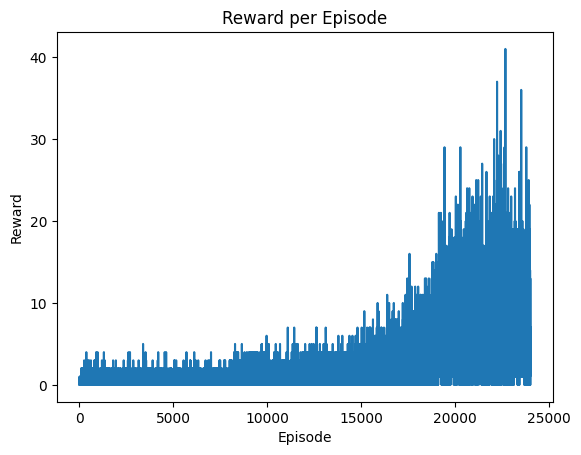

Episode 24000, Reward: 7.0
Episode 24010, Reward: 10.0
Episode 24020, Reward: 12.0
Episode 24030, Reward: 5.0
Episode 24040, Reward: 0.0


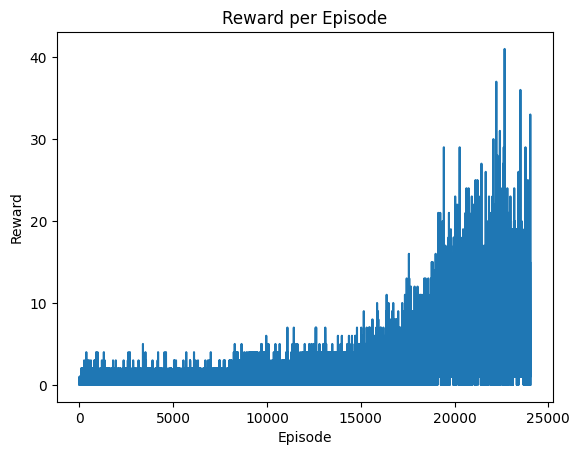

Episode 24050, Reward: 9.0
Episode 24060, Reward: 5.0
Episode 24070, Reward: 16.0
Episode 24080, Reward: 2.0


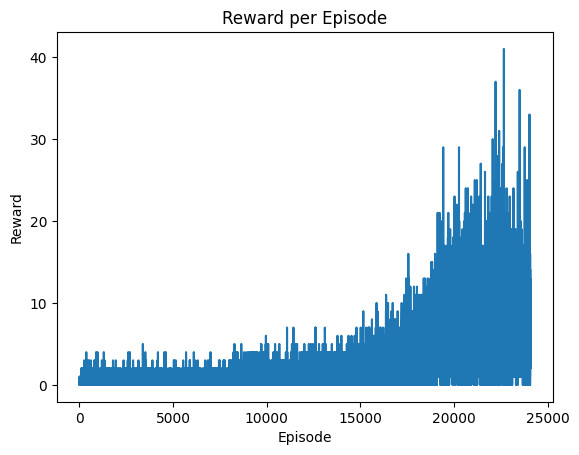

Episode 24090, Reward: 4.0
Episode 24100, Reward: 25.0
Episode 24110, Reward: 16.0
Episode 24120, Reward: 5.0
Episode 24130, Reward: 14.0


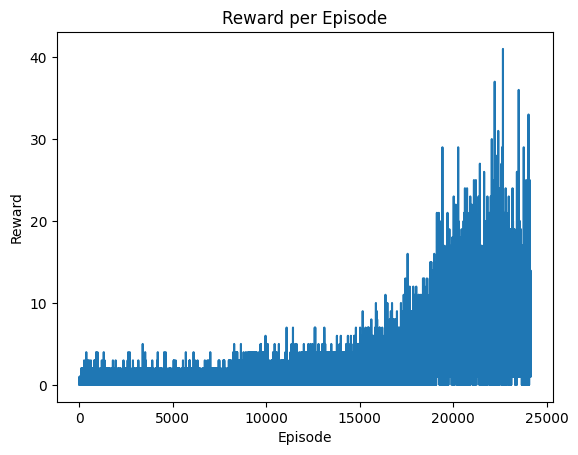

Episode 24140, Reward: 17.0
Episode 24150, Reward: 4.0
Episode 24160, Reward: 1.0
Episode 24170, Reward: 21.0


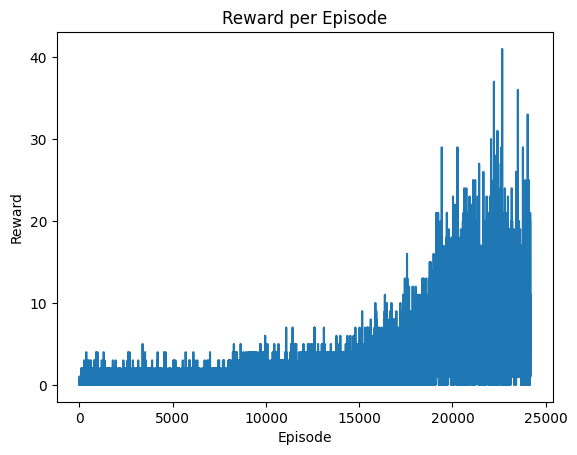

Episode 24180, Reward: 12.0
Episode 24190, Reward: 5.0
Episode 24200, Reward: 7.0
Episode 24210, Reward: 14.0


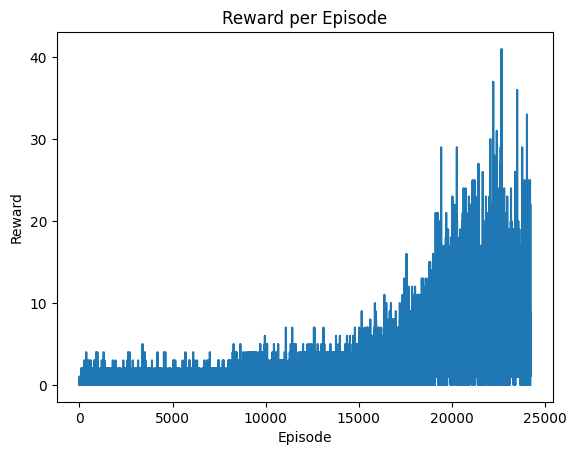

Episode 24220, Reward: 5.0
Episode 24230, Reward: 10.0
Episode 24240, Reward: 17.0
Episode 24250, Reward: 1.0


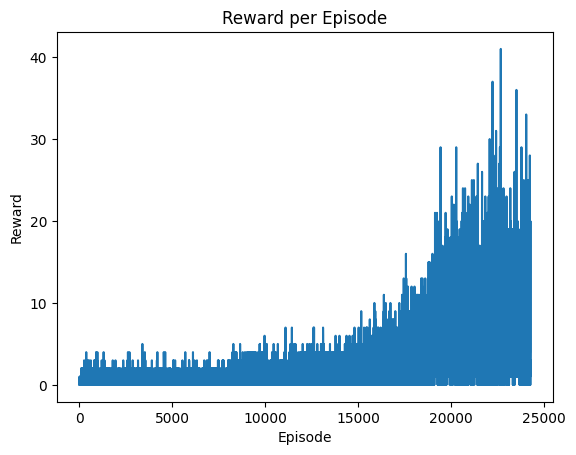

Episode 24260, Reward: 16.0
Episode 24270, Reward: 10.0
Episode 24280, Reward: 16.0
Episode 24290, Reward: 9.0
Episode 24300, Reward: 8.0


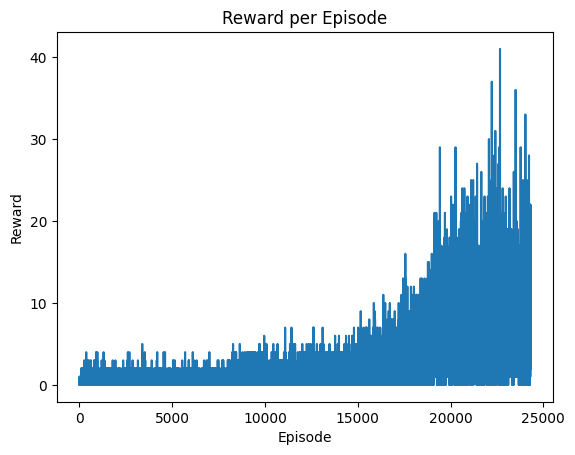

Episode 24310, Reward: 22.0
Episode 24320, Reward: 15.0
Episode 24330, Reward: 1.0
Episode 24340, Reward: 7.0
Episode 24350, Reward: 6.0


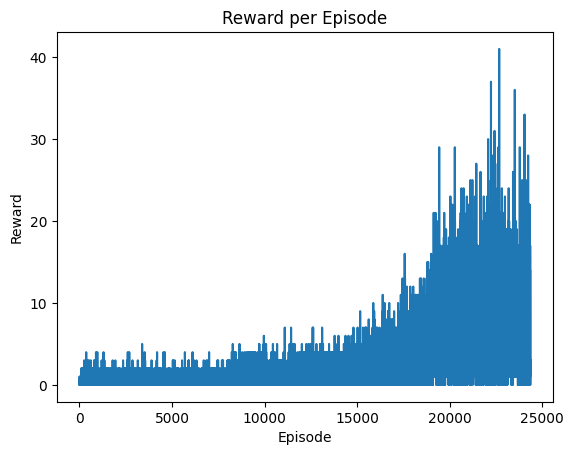

Episode 24360, Reward: 8.0
Episode 24370, Reward: 5.0
Episode 24380, Reward: 19.0


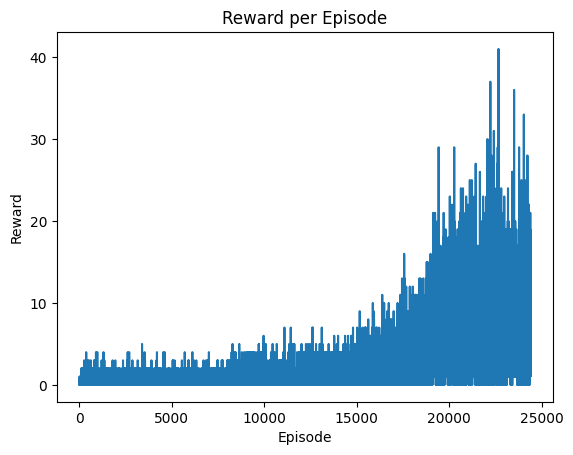

Episode 24390, Reward: 6.0
Episode 24400, Reward: 8.0
Episode 24410, Reward: 8.0
Episode 24420, Reward: 3.0
Episode 24430, Reward: 5.0


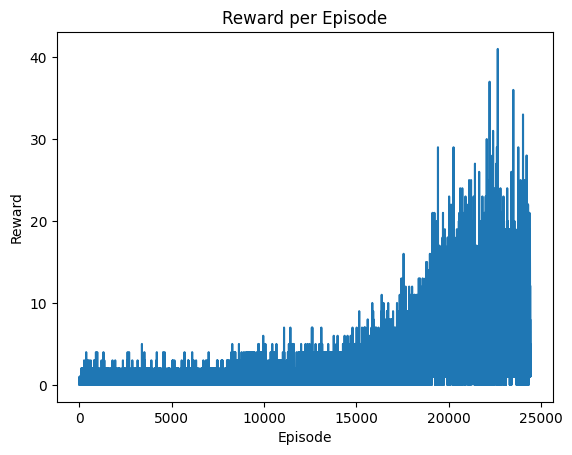

Episode 24440, Reward: 5.0
Episode 24450, Reward: 14.0
Episode 24460, Reward: 1.0
Episode 24470, Reward: 9.0
Episode 24480, Reward: 11.0


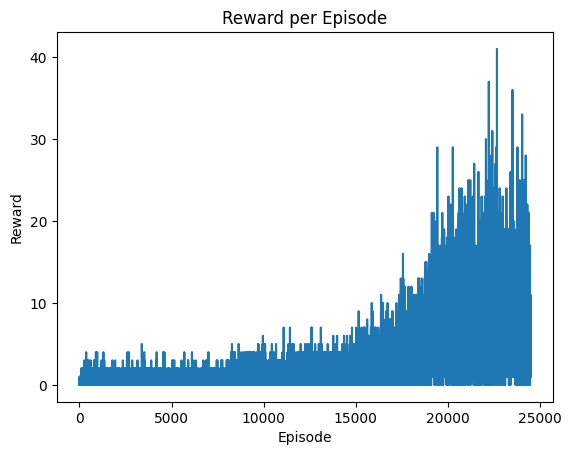

Episode 24490, Reward: 13.0
Episode 24500, Reward: 14.0
Episode 24510, Reward: 3.0
Episode 24520, Reward: 8.0


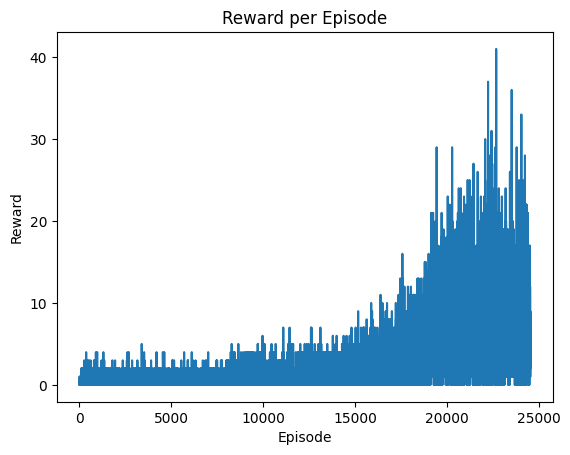

Episode 24530, Reward: 1.0
Episode 24540, Reward: 9.0
Episode 24550, Reward: 3.0
Episode 24560, Reward: 7.0
Episode 24570, Reward: 8.0


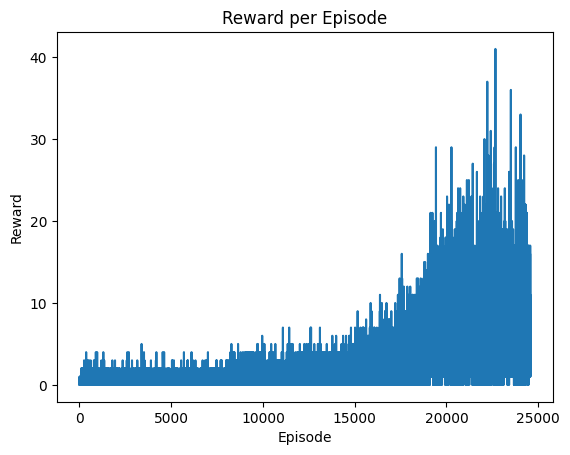

Episode 24580, Reward: 6.0
Episode 24590, Reward: 19.0
Episode 24600, Reward: 1.0
Episode 24610, Reward: 12.0


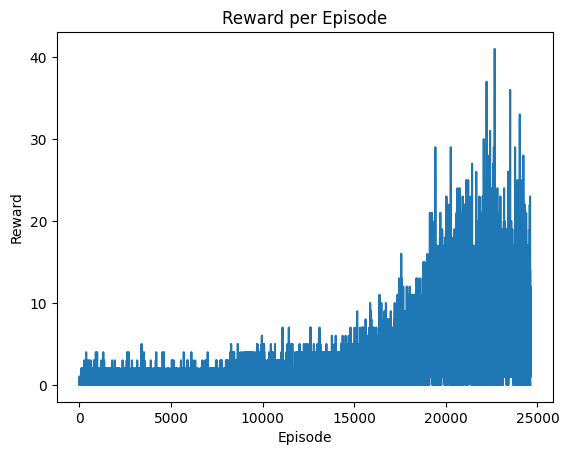

Episode 24620, Reward: 8.0
Episode 24630, Reward: 14.0
Episode 24640, Reward: 6.0
Episode 24650, Reward: 10.0


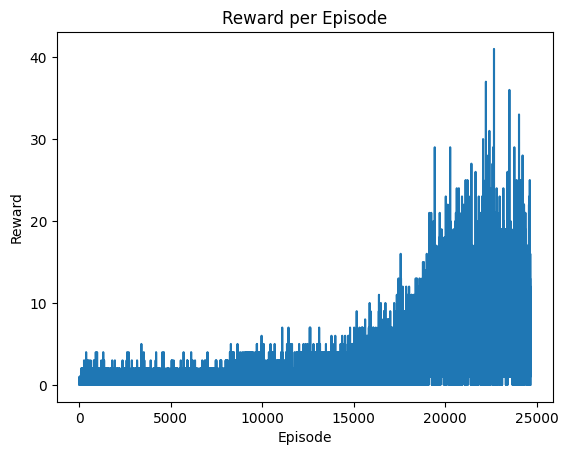

Episode 24660, Reward: 6.0
Episode 24670, Reward: 16.0
Episode 24680, Reward: 1.0
Episode 24690, Reward: 16.0


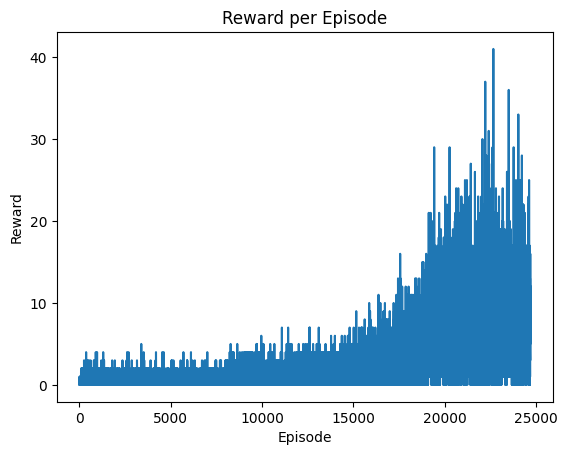

Episode 24700, Reward: 6.0
Episode 24710, Reward: 28.0
Episode 24720, Reward: 20.0
Episode 24730, Reward: 5.0
Episode 24740, Reward: 1.0
Episode 24750, Reward: 1.0


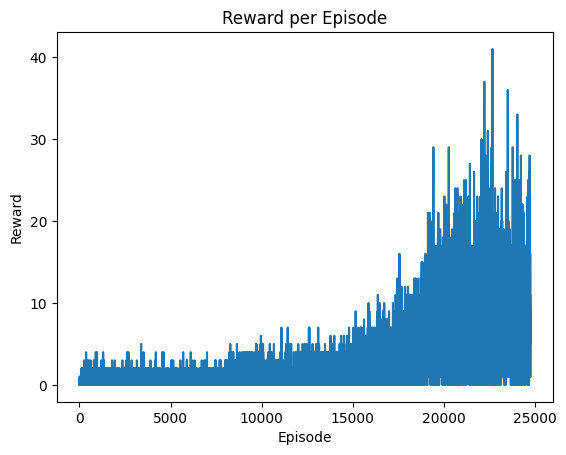

Episode 24760, Reward: 12.0
Episode 24770, Reward: 2.0
Episode 24780, Reward: 15.0
Episode 24790, Reward: 3.0


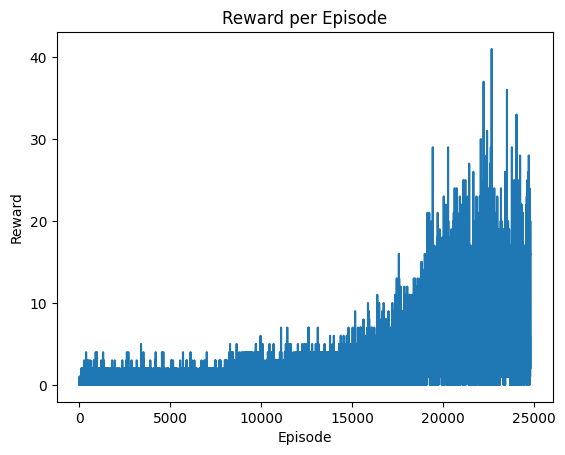

Episode 24800, Reward: 2.0
Episode 24810, Reward: 21.0
Episode 24820, Reward: 10.0
Episode 24830, Reward: 13.0
Episode 24840, Reward: 5.0


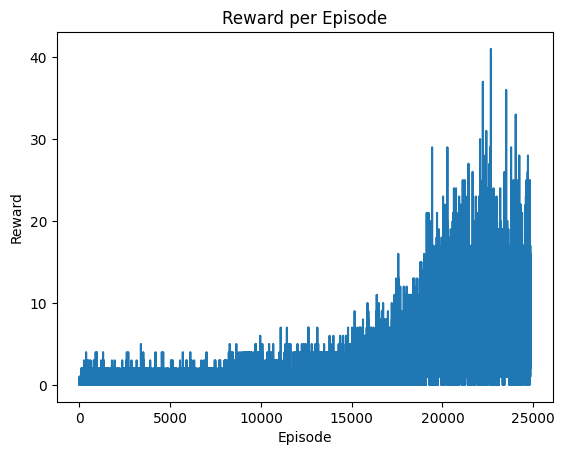

Episode 24850, Reward: 21.0
Episode 24860, Reward: 4.0
Episode 24870, Reward: 0.0
Episode 24880, Reward: 15.0


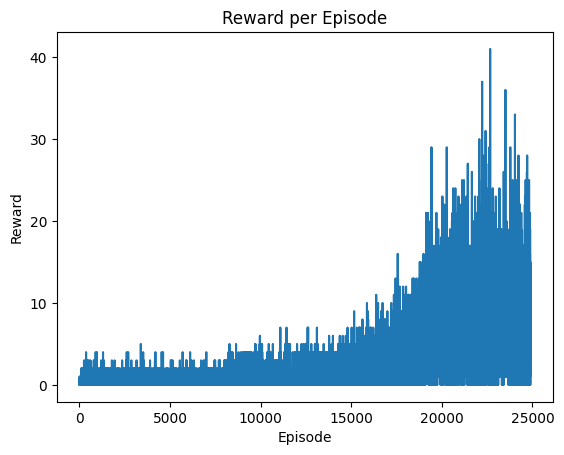

Episode 24890, Reward: 1.0
Episode 24900, Reward: 16.0
Episode 24910, Reward: 7.0
Episode 24920, Reward: 5.0
Episode 24930, Reward: 1.0


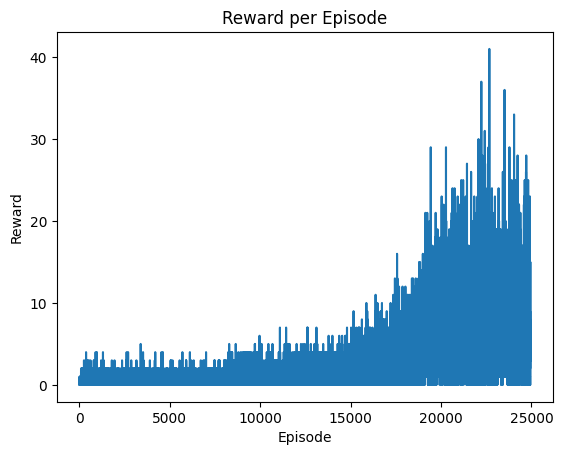

Episode 24940, Reward: 5.0
Episode 24950, Reward: 1.0
Episode 24960, Reward: 11.0
Episode 24970, Reward: 3.0
Episode 24980, Reward: 6.0


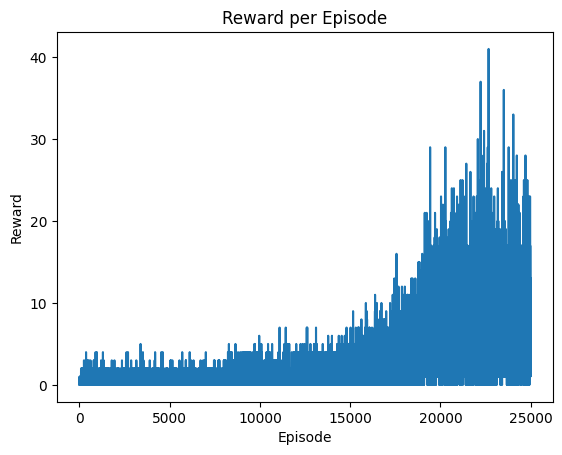

Episode 24990, Reward: 10.0


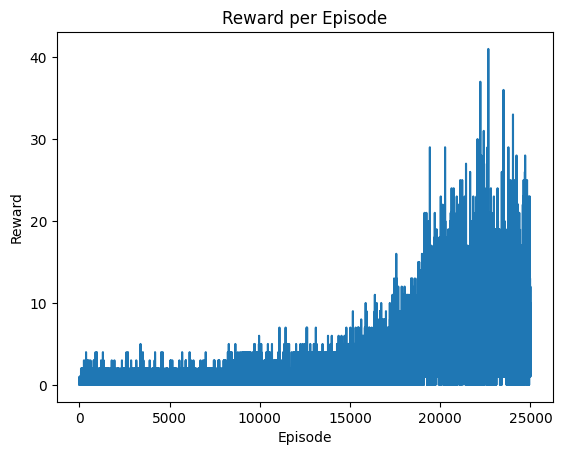

In [ ]:
num_episodes = 25000
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state).unsqueeze(0).to(device)
    episode_reward = 0
    while True:
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        agent.remember((state.to('cpu'), action, next_state, reward, done))
        agent.replay()
        state = torch.tensor(next_state).unsqueeze(0).to(device)
        episode_reward += reward

        if done:
            break
    episode_rewards.append(episode_reward.item())
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward.item()}")

# Plot episode rewards
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.show()

In [ ]:
with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    state = env_monitor.reset()
    done = False
    while not done:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = agent.select_action(state)
        next_state, _, done, _ = env_monitor.step(action)
        state = next_state

In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
print(len(video_paths))
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

1
